In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

In [ ]:
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

In [ ]:
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)


    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model


In [ ]:
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


#VGG19
#We need VGG19 for the feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer.
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:

lr_list = os.listdir("/content/drive/MyDrive/lr_images")
lr_list = sorted(lr_list)



In [ ]:
lr_images = []
i=0
for img in lr_list:
    i+=1
    # print(img)
    img_lr = cv2.imread("/content/drive/MyDrive/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


print(i)


7000


In [ ]:
hr_list = os.listdir("/content/drive/MyDrive/hr_images")
hr_list= sorted(hr_list)

In [ ]:
hr_images = []
c=0
for img in hr_list:
    # print(img)
    c=c+1
    img_hr = cv2.imread("/content/drive/MyDrive/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)


lr_images = np.array(lr_images)
hr_images = np.array(hr_images)
print(c)


7000


6470


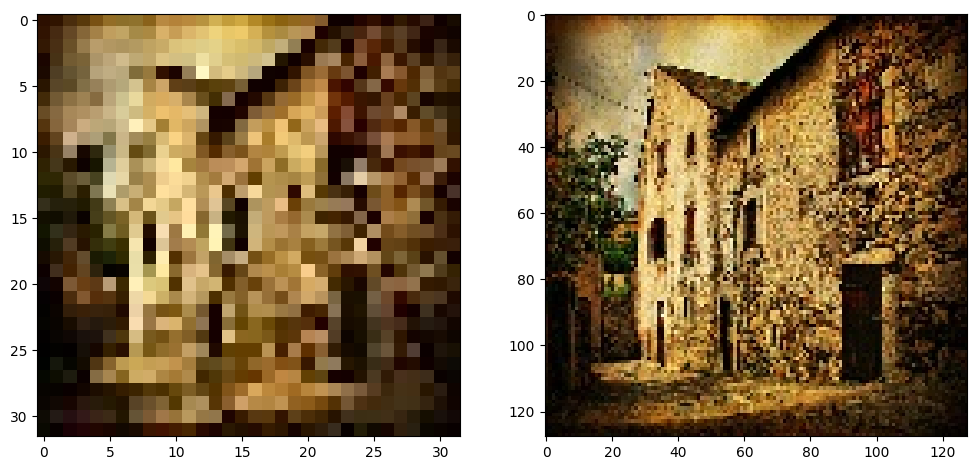

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)

plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [ ]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


In [ ]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# and the reference image.
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

In [ ]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

gan_model.load_weights('/content/drive/MyDrive/Models/gan_md20_3.h5')
epochs = 3
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []


    i=0
    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        i+=1
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    gan_model.save("/content/drive/MyDrive/Models/gan_md23" + str(e + 1) + ".h5")

    if (e+1) % epochs == 0: #Change the frequency for model saving, if needed
        save_path = "/content/drive/MyDrive/Models/gen_e23" + str(e + 1) + ".h5"
        generator.save(save_path)
        print("file saved successfully")



  0%|          | 0/4690 [00:00<?, ?it/s]

1/1 [==============================] - 0s 228ms/step


  0%|          | 1/4690 [00:35<46:17:47, 35.54s/it]

1/1 [==============================] - 0s 159ms/step


  0%|          | 2/4690 [00:42<24:07:26, 18.53s/it]

1/1 [==============================] - 0s 133ms/step


  0%|          | 3/4690 [00:48<16:40:01, 12.80s/it]

1/1 [==============================] - 0s 185ms/step


  0%|          | 4/4690 [00:54<13:34:44, 10.43s/it]

1/1 [==============================] - 0s 138ms/step


  0%|          | 5/4690 [01:00<11:20:16,  8.71s/it]

1/1 [==============================] - 0s 241ms/step


  0%|          | 6/4690 [01:08<10:50:08,  8.33s/it]

1/1 [==============================] - 0s 133ms/step


  0%|          | 7/4690 [01:13<9:43:16,  7.47s/it] 

1/1 [==============================] - 0s 240ms/step


  0%|          | 8/4690 [01:21<9:40:51,  7.44s/it]

1/1 [==============================] - 0s 143ms/step


  0%|          | 9/4690 [01:26<8:57:48,  6.89s/it]

1/1 [==============================] - 0s 138ms/step


  0%|          | 10/4690 [01:34<9:07:13,  7.02s/it]

1/1 [==============================] - 0s 137ms/step


  0%|          | 11/4690 [01:40<8:39:00,  6.66s/it]

1/1 [==============================] - 0s 137ms/step


  0%|          | 12/4690 [01:46<8:33:19,  6.58s/it]

1/1 [==============================] - 0s 146ms/step


  0%|          | 13/4690 [01:53<8:36:45,  6.63s/it]

1/1 [==============================] - 0s 142ms/step


  0%|          | 14/4690 [02:05<10:54:28,  8.40s/it]

1/1 [==============================] - 0s 138ms/step


  0%|          | 15/4690 [02:11<10:01:20,  7.72s/it]

1/1 [==============================] - 0s 268ms/step


  0%|          | 16/4690 [02:19<9:59:04,  7.69s/it] 

1/1 [==============================] - 0s 141ms/step


  0%|          | 17/4690 [02:25<9:16:02,  7.14s/it]

1/1 [==============================] - 0s 135ms/step


  0%|          | 18/4690 [02:32<9:22:23,  7.22s/it]

1/1 [==============================] - 0s 139ms/step


  0%|          | 19/4690 [02:38<8:47:27,  6.78s/it]

1/1 [==============================] - 0s 139ms/step


  0%|          | 20/4690 [02:45<8:41:02,  6.69s/it]

1/1 [==============================] - 0s 160ms/step


  0%|          | 21/4690 [02:51<8:38:23,  6.66s/it]

1/1 [==============================] - 0s 139ms/step


  0%|          | 22/4690 [02:58<8:52:12,  6.84s/it]

1/1 [==============================] - 0s 143ms/step


  0%|          | 23/4690 [03:05<8:39:07,  6.67s/it]

1/1 [==============================] - 0s 148ms/step


  1%|          | 24/4690 [03:11<8:25:45,  6.50s/it]

1/1 [==============================] - 0s 215ms/step


  1%|          | 25/4690 [03:18<8:37:46,  6.66s/it]

1/1 [==============================] - 0s 154ms/step


  1%|          | 26/4690 [03:23<8:13:45,  6.35s/it]

1/1 [==============================] - 0s 244ms/step


  1%|          | 27/4690 [03:31<8:35:10,  6.63s/it]

1/1 [==============================] - 0s 138ms/step


  1%|          | 28/4690 [03:36<8:12:55,  6.34s/it]

1/1 [==============================] - 0s 138ms/step


  1%|          | 29/4690 [03:44<8:35:57,  6.64s/it]

1/1 [==============================] - 0s 133ms/step


  1%|          | 30/4690 [03:49<8:12:29,  6.34s/it]

1/1 [==============================] - 0s 143ms/step


  1%|          | 31/4690 [03:56<8:14:54,  6.37s/it]

1/1 [==============================] - 0s 134ms/step


  1%|          | 32/4690 [04:02<8:15:36,  6.38s/it]

1/1 [==============================] - 0s 137ms/step


  1%|          | 33/4690 [04:09<8:35:47,  6.65s/it]

1/1 [==============================] - 0s 138ms/step


  1%|          | 34/4690 [04:16<8:27:53,  6.55s/it]

1/1 [==============================] - 0s 141ms/step


  1%|          | 35/4690 [04:22<8:11:38,  6.34s/it]

1/1 [==============================] - 0s 236ms/step


  1%|          | 36/4690 [04:30<8:52:54,  6.87s/it]

1/1 [==============================] - 0s 246ms/step


  1%|          | 37/4690 [04:38<9:27:23,  7.32s/it]

1/1 [==============================] - 0s 132ms/step


  1%|          | 38/4690 [04:45<9:06:30,  7.05s/it]

1/1 [==============================] - 0s 135ms/step


  1%|          | 39/4690 [04:50<8:33:09,  6.62s/it]

1/1 [==============================] - 0s 210ms/step


  1%|          | 40/4690 [04:57<8:48:55,  6.82s/it]

1/1 [==============================] - 0s 133ms/step


  1%|          | 41/4690 [05:03<8:22:00,  6.48s/it]

1/1 [==============================] - 0s 251ms/step


  1%|          | 42/4690 [05:11<8:45:48,  6.79s/it]

1/1 [==============================] - 0s 150ms/step


  1%|          | 43/4690 [05:16<8:18:17,  6.43s/it]

1/1 [==============================] - 0s 140ms/step


  1%|          | 44/4690 [05:23<8:32:58,  6.62s/it]

1/1 [==============================] - 0s 138ms/step


  1%|          | 45/4690 [05:29<8:14:24,  6.39s/it]

1/1 [==============================] - 0s 135ms/step


  1%|          | 46/4690 [05:35<8:08:12,  6.31s/it]

1/1 [==============================] - 0s 136ms/step


  1%|          | 47/4690 [05:42<8:18:14,  6.44s/it]

1/1 [==============================] - 0s 134ms/step


  1%|          | 48/4690 [05:48<8:00:09,  6.21s/it]

1/1 [==============================] - 0s 242ms/step


  1%|          | 49/4690 [05:55<8:24:14,  6.52s/it]

1/1 [==============================] - 0s 146ms/step


  1%|          | 50/4690 [06:01<8:03:05,  6.25s/it]

1/1 [==============================] - 0s 143ms/step


  1%|          | 51/4690 [06:08<8:27:39,  6.57s/it]

1/1 [==============================] - 0s 152ms/step


  1%|          | 52/4690 [06:14<8:07:52,  6.31s/it]

1/1 [==============================] - 0s 142ms/step


  1%|          | 53/4690 [06:20<8:21:55,  6.49s/it]

1/1 [==============================] - 0s 137ms/step


  1%|          | 54/4690 [06:26<8:10:23,  6.35s/it]

1/1 [==============================] - 0s 146ms/step


  1%|          | 55/4690 [06:32<8:00:44,  6.22s/it]

1/1 [==============================] - 0s 177ms/step


  1%|          | 56/4690 [06:39<8:17:04,  6.44s/it]

1/1 [==============================] - 0s 133ms/step


  1%|          | 57/4690 [06:45<7:58:42,  6.20s/it]

1/1 [==============================] - 0s 255ms/step


  1%|          | 58/4690 [06:52<8:23:25,  6.52s/it]

1/1 [==============================] - 0s 140ms/step


  1%|▏         | 59/4690 [06:58<8:02:23,  6.25s/it]

1/1 [==============================] - 0s 150ms/step


  1%|▏         | 60/4690 [07:05<8:30:21,  6.61s/it]

1/1 [==============================] - 0s 238ms/step


  1%|▏         | 61/4690 [07:13<8:47:19,  6.84s/it]

1/1 [==============================] - 0s 160ms/step


  1%|▏         | 62/4690 [07:20<8:58:54,  6.99s/it]

1/1 [==============================] - 0s 135ms/step


  1%|▏         | 63/4690 [07:26<8:27:27,  6.58s/it]

1/1 [==============================] - 0s 132ms/step


  1%|▏         | 64/4690 [07:33<8:37:58,  6.72s/it]

1/1 [==============================] - 0s 134ms/step


  1%|▏         | 65/4690 [07:39<8:17:20,  6.45s/it]

1/1 [==============================] - 0s 134ms/step


  1%|▏         | 66/4690 [07:45<8:07:22,  6.32s/it]

1/1 [==============================] - 0s 142ms/step


  1%|▏         | 67/4690 [07:51<8:15:03,  6.43s/it]

1/1 [==============================] - 0s 136ms/step


  1%|▏         | 68/4690 [07:57<7:57:11,  6.19s/it]

1/1 [==============================] - 0s 246ms/step


  1%|▏         | 69/4690 [08:04<8:22:35,  6.53s/it]

1/1 [==============================] - 0s 134ms/step


  1%|▏         | 70/4690 [08:10<8:02:00,  6.26s/it]

1/1 [==============================] - 0s 132ms/step


  2%|▏         | 71/4690 [08:17<8:29:03,  6.61s/it]

1/1 [==============================] - 0s 133ms/step


  2%|▏         | 72/4690 [08:23<8:06:47,  6.32s/it]

1/1 [==============================] - 0s 131ms/step


  2%|▏         | 73/4690 [08:29<8:10:43,  6.38s/it]

1/1 [==============================] - 0s 133ms/step


  2%|▏         | 74/4690 [08:36<8:11:34,  6.39s/it]

1/1 [==============================] - 0s 150ms/step


  2%|▏         | 75/4690 [08:42<7:58:01,  6.21s/it]

1/1 [==============================] - 0s 244ms/step


  2%|▏         | 76/4690 [08:49<8:17:39,  6.47s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 77/4690 [08:54<7:57:25,  6.21s/it]

1/1 [==============================] - 0s 258ms/step


  2%|▏         | 78/4690 [09:02<8:23:22,  6.55s/it]

1/1 [==============================] - 0s 135ms/step


  2%|▏         | 79/4690 [09:07<8:00:32,  6.25s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 80/4690 [09:14<8:22:42,  6.54s/it]

1/1 [==============================] - 0s 133ms/step


  2%|▏         | 81/4690 [09:20<8:03:20,  6.29s/it]

1/1 [==============================] - 0s 133ms/step


  2%|▏         | 82/4690 [09:27<8:25:56,  6.59s/it]

1/1 [==============================] - 0s 134ms/step


  2%|▏         | 83/4690 [09:33<8:08:42,  6.36s/it]

1/1 [==============================] - 0s 133ms/step


  2%|▏         | 84/4690 [09:39<8:04:56,  6.32s/it]

1/1 [==============================] - 0s 252ms/step


  2%|▏         | 85/4690 [09:48<8:54:23,  6.96s/it]

1/1 [==============================] - 0s 133ms/step


  2%|▏         | 86/4690 [09:54<8:30:27,  6.65s/it]

1/1 [==============================] - 0s 221ms/step


  2%|▏         | 87/4690 [10:01<8:35:42,  6.72s/it]

1/1 [==============================] - 0s 135ms/step


  2%|▏         | 88/4690 [10:06<8:10:53,  6.40s/it]

1/1 [==============================] - 0s 249ms/step


  2%|▏         | 89/4690 [10:14<8:33:15,  6.69s/it]

1/1 [==============================] - 0s 147ms/step


  2%|▏         | 90/4690 [10:19<8:09:02,  6.38s/it]

1/1 [==============================] - 0s 148ms/step


  2%|▏         | 91/4690 [10:27<8:33:14,  6.70s/it]

1/1 [==============================] - 0s 253ms/step


  2%|▏         | 92/4690 [10:37<9:43:03,  7.61s/it]

1/1 [==============================] - 0s 223ms/step


  2%|▏         | 93/4690 [10:44<9:35:34,  7.51s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 94/4690 [10:49<8:47:45,  6.89s/it]

1/1 [==============================] - 0s 241ms/step


  2%|▏         | 95/4690 [10:56<8:53:28,  6.97s/it]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 96/4690 [11:02<8:18:25,  6.51s/it]

1/1 [==============================] - 0s 130ms/step


  2%|▏         | 97/4690 [11:09<8:34:28,  6.72s/it]

1/1 [==============================] - 0s 137ms/step


  2%|▏         | 98/4690 [11:15<8:08:29,  6.38s/it]

1/1 [==============================] - 0s 132ms/step


  2%|▏         | 99/4690 [11:21<8:01:28,  6.29s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 100/4690 [11:27<8:05:47,  6.35s/it]

1/1 [==============================] - 0s 134ms/step


  2%|▏         | 101/4690 [11:33<7:46:57,  6.11s/it]

1/1 [==============================] - 0s 252ms/step


  2%|▏         | 102/4690 [11:40<8:10:36,  6.42s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 103/4690 [11:45<7:48:18,  6.13s/it]

1/1 [==============================] - 0s 141ms/step


  2%|▏         | 104/4690 [11:53<8:11:37,  6.43s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 105/4690 [11:58<7:50:11,  6.15s/it]

1/1 [==============================] - 0s 135ms/step


  2%|▏         | 106/4690 [12:04<7:49:26,  6.14s/it]

1/1 [==============================] - 0s 134ms/step


  2%|▏         | 107/4690 [12:11<7:56:42,  6.24s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 108/4690 [12:16<7:41:52,  6.05s/it]

1/1 [==============================] - 0s 300ms/step


  2%|▏         | 109/4690 [12:25<8:50:30,  6.95s/it]

1/1 [==============================] - 0s 132ms/step


  2%|▏         | 110/4690 [12:31<8:17:17,  6.51s/it]

1/1 [==============================] - 0s 134ms/step


  2%|▏         | 111/4690 [12:37<8:21:43,  6.57s/it]

1/1 [==============================] - 0s 135ms/step


  2%|▏         | 112/4690 [12:43<8:08:19,  6.40s/it]

1/1 [==============================] - 0s 141ms/step


  2%|▏         | 113/4690 [12:49<7:54:29,  6.22s/it]

1/1 [==============================] - 0s 241ms/step


  2%|▏         | 114/4690 [12:56<8:06:38,  6.38s/it]

1/1 [==============================] - 0s 140ms/step


  2%|▏         | 115/4690 [13:01<7:45:19,  6.10s/it]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 116/4690 [13:09<8:12:37,  6.46s/it]

1/1 [==============================] - 0s 132ms/step


  2%|▏         | 117/4690 [13:14<7:52:50,  6.20s/it]

1/1 [==============================] - 0s 135ms/step


  3%|▎         | 118/4690 [13:21<8:05:45,  6.37s/it]

1/1 [==============================] - 0s 134ms/step


  3%|▎         | 119/4690 [13:27<7:52:42,  6.20s/it]

1/1 [==============================] - 0s 135ms/step


  3%|▎         | 120/4690 [13:34<8:16:23,  6.52s/it]

1/1 [==============================] - 0s 140ms/step


  3%|▎         | 121/4690 [13:40<8:01:07,  6.32s/it]

1/1 [==============================] - 0s 131ms/step


  3%|▎         | 122/4690 [13:46<7:43:56,  6.09s/it]

1/1 [==============================] - 0s 259ms/step


  3%|▎         | 123/4690 [13:53<8:02:14,  6.34s/it]

1/1 [==============================] - 0s 130ms/step


  3%|▎         | 124/4690 [13:58<7:42:15,  6.07s/it]

1/1 [==============================] - 0s 254ms/step


  3%|▎         | 125/4690 [14:05<8:06:18,  6.39s/it]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 126/4690 [14:11<7:45:19,  6.12s/it]

1/1 [==============================] - 0s 134ms/step


  3%|▎         | 127/4690 [14:18<8:13:17,  6.49s/it]

1/1 [==============================] - 0s 134ms/step


  3%|▎         | 128/4690 [14:24<7:54:33,  6.24s/it]

1/1 [==============================] - 0s 133ms/step


  3%|▎         | 129/4690 [14:31<8:17:29,  6.54s/it]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 130/4690 [14:37<8:02:50,  6.35s/it]

1/1 [==============================] - 0s 140ms/step


  3%|▎         | 131/4690 [14:42<7:47:30,  6.15s/it]

1/1 [==============================] - 0s 216ms/step


  3%|▎         | 132/4690 [14:49<8:01:27,  6.34s/it]

1/1 [==============================] - 0s 150ms/step


  3%|▎         | 133/4690 [14:55<7:56:22,  6.27s/it]

1/1 [==============================] - 0s 246ms/step


  3%|▎         | 134/4690 [15:04<8:39:04,  6.84s/it]

1/1 [==============================] - 0s 135ms/step


  3%|▎         | 135/4690 [15:09<8:08:16,  6.43s/it]

1/1 [==============================] - 0s 133ms/step


  3%|▎         | 136/4690 [15:16<8:26:01,  6.67s/it]

1/1 [==============================] - 0s 135ms/step


  3%|▎         | 137/4690 [15:22<7:57:04,  6.29s/it]

1/1 [==============================] - 0s 140ms/step


  3%|▎         | 138/4690 [15:28<7:49:33,  6.19s/it]

1/1 [==============================] - 0s 137ms/step


  3%|▎         | 139/4690 [15:34<7:58:27,  6.31s/it]

1/1 [==============================] - 0s 135ms/step


  3%|▎         | 140/4690 [15:40<7:40:15,  6.07s/it]

1/1 [==============================] - 0s 257ms/step


  3%|▎         | 141/4690 [15:47<8:03:51,  6.38s/it]

1/1 [==============================] - 0s 138ms/step


  3%|▎         | 142/4690 [15:52<7:43:15,  6.11s/it]

1/1 [==============================] - 0s 131ms/step


  3%|▎         | 143/4690 [15:59<8:06:26,  6.42s/it]

1/1 [==============================] - 0s 134ms/step


  3%|▎         | 144/4690 [16:07<8:23:43,  6.65s/it]

1/1 [==============================] - 0s 133ms/step


  3%|▎         | 145/4690 [16:14<8:36:01,  6.81s/it]

1/1 [==============================] - 0s 149ms/step


  3%|▎         | 146/4690 [16:19<8:08:14,  6.45s/it]

1/1 [==============================] - 0s 132ms/step


  3%|▎         | 147/4690 [16:25<7:57:37,  6.31s/it]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 148/4690 [16:32<8:06:10,  6.42s/it]

1/1 [==============================] - 0s 133ms/step


  3%|▎         | 149/4690 [16:39<8:24:08,  6.66s/it]

1/1 [==============================] - 0s 135ms/step


  3%|▎         | 150/4690 [16:46<8:16:33,  6.56s/it]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 151/4690 [16:51<7:51:12,  6.23s/it]

1/1 [==============================] - 0s 253ms/step


  3%|▎         | 152/4690 [16:58<8:12:07,  6.51s/it]

1/1 [==============================] - 0s 137ms/step


  3%|▎         | 153/4690 [17:04<7:50:19,  6.22s/it]

1/1 [==============================] - 0s 151ms/step


  3%|▎         | 154/4690 [17:11<8:10:42,  6.49s/it]

1/1 [==============================] - 0s 140ms/step


  3%|▎         | 155/4690 [17:16<7:48:52,  6.20s/it]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 156/4690 [17:23<7:48:24,  6.20s/it]

1/1 [==============================] - 0s 138ms/step


  3%|▎         | 157/4690 [17:29<7:52:08,  6.25s/it]

1/1 [==============================] - 0s 233ms/step


  3%|▎         | 158/4690 [17:37<8:25:46,  6.70s/it]

1/1 [==============================] - 0s 142ms/step


  3%|▎         | 159/4690 [17:44<8:29:28,  6.75s/it]

1/1 [==============================] - 0s 135ms/step


  3%|▎         | 160/4690 [17:49<8:00:15,  6.36s/it]

1/1 [==============================] - 0s 248ms/step


  3%|▎         | 161/4690 [17:56<8:17:38,  6.59s/it]

1/1 [==============================] - 0s 133ms/step


  3%|▎         | 162/4690 [18:02<7:51:55,  6.25s/it]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 163/4690 [18:09<8:09:56,  6.49s/it]

1/1 [==============================] - 0s 133ms/step


  3%|▎         | 164/4690 [18:14<7:48:02,  6.20s/it]

1/1 [==============================] - 0s 146ms/step


  4%|▎         | 165/4690 [18:20<7:46:28,  6.19s/it]

1/1 [==============================] - 0s 134ms/step


  4%|▎         | 166/4690 [18:27<7:54:09,  6.29s/it]

1/1 [==============================] - 0s 137ms/step


  4%|▎         | 167/4690 [18:32<7:36:36,  6.06s/it]

1/1 [==============================] - 0s 237ms/step


  4%|▎         | 168/4690 [18:40<8:02:36,  6.40s/it]

1/1 [==============================] - 0s 138ms/step


  4%|▎         | 169/4690 [18:45<7:42:20,  6.14s/it]

1/1 [==============================] - 0s 141ms/step


  4%|▎         | 170/4690 [18:52<8:04:18,  6.43s/it]

1/1 [==============================] - 0s 139ms/step


  4%|▎         | 171/4690 [18:58<7:43:04,  6.15s/it]

1/1 [==============================] - 0s 136ms/step


  4%|▎         | 172/4690 [19:04<7:47:15,  6.21s/it]

1/1 [==============================] - 0s 132ms/step


  4%|▎         | 173/4690 [19:11<7:52:31,  6.28s/it]

1/1 [==============================] - 0s 134ms/step


  4%|▎         | 174/4690 [19:16<7:34:10,  6.03s/it]

1/1 [==============================] - 0s 248ms/step


  4%|▎         | 175/4690 [19:23<8:00:43,  6.39s/it]

1/1 [==============================] - 0s 132ms/step


  4%|▍         | 176/4690 [19:29<7:40:08,  6.12s/it]

1/1 [==============================] - 0s 133ms/step


  4%|▍         | 177/4690 [19:36<8:05:28,  6.45s/it]

1/1 [==============================] - 0s 130ms/step


  4%|▍         | 178/4690 [19:41<7:45:16,  6.19s/it]

1/1 [==============================] - 0s 140ms/step


  4%|▍         | 179/4690 [19:48<7:41:55,  6.14s/it]

1/1 [==============================] - 0s 133ms/step


  4%|▍         | 180/4690 [19:54<7:51:55,  6.28s/it]

1/1 [==============================] - 0s 133ms/step


  4%|▍         | 181/4690 [20:00<7:38:55,  6.11s/it]

1/1 [==============================] - 0s 238ms/step


  4%|▍         | 182/4690 [20:07<8:02:07,  6.42s/it]

1/1 [==============================] - 0s 150ms/step


  4%|▍         | 183/4690 [20:14<8:22:02,  6.68s/it]

1/1 [==============================] - 0s 270ms/step


  4%|▍         | 184/4690 [20:22<8:34:40,  6.85s/it]

1/1 [==============================] - 0s 132ms/step


  4%|▍         | 185/4690 [20:27<8:04:02,  6.45s/it]

1/1 [==============================] - 0s 172ms/step


  4%|▍         | 186/4690 [20:35<8:33:04,  6.83s/it]

1/1 [==============================] - 0s 134ms/step


  4%|▍         | 187/4690 [20:47<10:36:52,  8.49s/it]

1/1 [==============================] - 0s 151ms/step


  4%|▍         | 188/4690 [20:54<9:52:10,  7.89s/it] 

1/1 [==============================] - 0s 157ms/step


  4%|▍         | 189/4690 [21:00<9:23:21,  7.51s/it]

1/1 [==============================] - 0s 137ms/step


  4%|▍         | 190/4690 [21:06<8:48:57,  7.05s/it]

1/1 [==============================] - 0s 159ms/step


  4%|▍         | 191/4690 [21:12<8:19:08,  6.66s/it]

1/1 [==============================] - 0s 236ms/step


  4%|▍         | 192/4690 [21:19<8:26:08,  6.75s/it]

1/1 [==============================] - 0s 135ms/step


  4%|▍         | 193/4690 [21:25<8:01:36,  6.43s/it]

1/1 [==============================] - 0s 227ms/step


  4%|▍         | 194/4690 [21:32<8:16:23,  6.62s/it]

1/1 [==============================] - 0s 149ms/step


  4%|▍         | 195/4690 [21:37<7:49:22,  6.27s/it]

1/1 [==============================] - 0s 133ms/step


  4%|▍         | 196/4690 [21:44<8:00:31,  6.42s/it]

1/1 [==============================] - 0s 132ms/step


  4%|▍         | 197/4690 [21:50<7:45:04,  6.21s/it]

1/1 [==============================] - 0s 147ms/step


  4%|▍         | 198/4690 [21:55<7:30:23,  6.02s/it]

1/1 [==============================] - 0s 240ms/step


  4%|▍         | 199/4690 [22:04<8:25:54,  6.76s/it]

1/1 [==============================] - 0s 137ms/step


  4%|▍         | 200/4690 [22:09<8:00:15,  6.42s/it]

1/1 [==============================] - 0s 236ms/step


  4%|▍         | 201/4690 [22:16<8:11:11,  6.57s/it]

1/1 [==============================] - 0s 133ms/step


  4%|▍         | 202/4690 [22:22<7:48:59,  6.27s/it]

1/1 [==============================] - 0s 228ms/step


  4%|▍         | 203/4690 [22:29<8:09:03,  6.54s/it]

1/1 [==============================] - 0s 132ms/step


  4%|▍         | 204/4690 [22:34<7:44:35,  6.21s/it]

1/1 [==============================] - 0s 133ms/step


  4%|▍         | 205/4690 [22:41<8:01:22,  6.44s/it]

1/1 [==============================] - 0s 136ms/step


  4%|▍         | 206/4690 [22:47<7:45:31,  6.23s/it]

1/1 [==============================] - 0s 148ms/step


  4%|▍         | 207/4690 [22:54<7:53:00,  6.33s/it]

1/1 [==============================] - 0s 282ms/step


  4%|▍         | 208/4690 [23:01<8:24:07,  6.75s/it]

1/1 [==============================] - 0s 139ms/step


  4%|▍         | 209/4690 [23:07<7:54:25,  6.35s/it]

1/1 [==============================] - 0s 233ms/step


  4%|▍         | 210/4690 [23:14<8:12:32,  6.60s/it]

1/1 [==============================] - 0s 134ms/step


  4%|▍         | 211/4690 [23:20<7:49:45,  6.29s/it]

1/1 [==============================] - 0s 138ms/step


  5%|▍         | 212/4690 [23:27<8:10:59,  6.58s/it]

1/1 [==============================] - 0s 133ms/step


  5%|▍         | 213/4690 [23:32<7:45:45,  6.24s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▍         | 214/4690 [23:39<8:07:14,  6.53s/it]

1/1 [==============================] - 0s 147ms/step


  5%|▍         | 215/4690 [23:45<7:51:15,  6.32s/it]

1/1 [==============================] - 0s 134ms/step


  5%|▍         | 216/4690 [23:51<7:35:32,  6.11s/it]

1/1 [==============================] - 0s 133ms/step


  5%|▍         | 217/4690 [23:58<7:57:24,  6.40s/it]

1/1 [==============================] - 0s 131ms/step


  5%|▍         | 218/4690 [24:03<7:36:24,  6.12s/it]

1/1 [==============================] - 0s 243ms/step


  5%|▍         | 219/4690 [24:11<7:57:55,  6.41s/it]

1/1 [==============================] - 0s 143ms/step


  5%|▍         | 220/4690 [24:16<7:36:08,  6.12s/it]

1/1 [==============================] - 0s 131ms/step


  5%|▍         | 221/4690 [24:23<7:59:57,  6.44s/it]

1/1 [==============================] - 0s 135ms/step


  5%|▍         | 222/4690 [24:29<7:38:16,  6.15s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▍         | 223/4690 [24:37<8:20:34,  6.72s/it]

1/1 [==============================] - 0s 138ms/step


  5%|▍         | 224/4690 [24:43<8:01:48,  6.47s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▍         | 225/4690 [24:48<7:43:49,  6.23s/it]

1/1 [==============================] - 0s 232ms/step


  5%|▍         | 226/4690 [24:55<7:55:57,  6.40s/it]

1/1 [==============================] - 0s 134ms/step


  5%|▍         | 227/4690 [25:01<7:34:10,  6.11s/it]

1/1 [==============================] - 0s 241ms/step


  5%|▍         | 228/4690 [25:08<7:57:20,  6.42s/it]

1/1 [==============================] - 0s 135ms/step


  5%|▍         | 229/4690 [25:13<7:34:27,  6.11s/it]

1/1 [==============================] - 0s 132ms/step


  5%|▍         | 230/4690 [25:20<7:50:27,  6.33s/it]

1/1 [==============================] - 0s 150ms/step


  5%|▍         | 231/4690 [25:26<7:37:42,  6.16s/it]

1/1 [==============================] - 0s 132ms/step


  5%|▍         | 232/4690 [25:32<7:33:05,  6.10s/it]

1/1 [==============================] - 0s 301ms/step


  5%|▍         | 233/4690 [25:40<8:27:15,  6.83s/it]

1/1 [==============================] - 0s 135ms/step


  5%|▍         | 234/4690 [25:46<7:56:41,  6.42s/it]

1/1 [==============================] - 0s 133ms/step


  5%|▌         | 235/4690 [25:53<8:08:22,  6.58s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▌         | 236/4690 [25:58<7:43:58,  6.25s/it]

1/1 [==============================] - 0s 147ms/step


  5%|▌         | 237/4690 [26:04<7:34:38,  6.13s/it]

1/1 [==============================] - 0s 156ms/step


  5%|▌         | 238/4690 [26:10<7:45:44,  6.28s/it]

1/1 [==============================] - 0s 134ms/step


  5%|▌         | 239/4690 [26:16<7:27:02,  6.03s/it]

1/1 [==============================] - 0s 222ms/step


  5%|▌         | 240/4690 [26:23<7:54:53,  6.40s/it]

1/1 [==============================] - 0s 154ms/step


  5%|▌         | 241/4690 [26:29<7:34:42,  6.13s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▌         | 242/4690 [26:36<7:52:08,  6.37s/it]

1/1 [==============================] - 0s 150ms/step


  5%|▌         | 243/4690 [26:41<7:36:58,  6.17s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▌         | 244/4690 [26:47<7:27:36,  6.04s/it]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 245/4690 [26:54<7:44:43,  6.27s/it]

1/1 [==============================] - 0s 134ms/step


  5%|▌         | 246/4690 [26:59<7:25:29,  6.01s/it]

1/1 [==============================] - 0s 227ms/step


  5%|▌         | 247/4690 [27:06<7:49:06,  6.34s/it]

1/1 [==============================] - 0s 149ms/step


  5%|▌         | 248/4690 [27:12<7:29:05,  6.07s/it]

1/1 [==============================] - 0s 135ms/step


  5%|▌         | 249/4690 [27:19<7:48:53,  6.34s/it]

1/1 [==============================] - 0s 149ms/step


  5%|▌         | 250/4690 [27:24<7:32:20,  6.11s/it]

1/1 [==============================] - 0s 129ms/step


  5%|▌         | 251/4690 [27:30<7:23:42,  6.00s/it]

1/1 [==============================] - 0s 178ms/step


  5%|▌         | 252/4690 [27:37<7:36:42,  6.17s/it]

1/1 [==============================] - 0s 135ms/step


  5%|▌         | 253/4690 [27:42<7:20:37,  5.96s/it]

1/1 [==============================] - 0s 216ms/step


  5%|▌         | 254/4690 [27:49<7:45:11,  6.29s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▌         | 255/4690 [27:55<7:27:09,  6.05s/it]

1/1 [==============================] - 0s 146ms/step


  5%|▌         | 256/4690 [28:01<7:41:19,  6.24s/it]

1/1 [==============================] - 0s 134ms/step


  5%|▌         | 257/4690 [28:07<7:28:53,  6.08s/it]

1/1 [==============================] - 0s 135ms/step


  6%|▌         | 258/4690 [28:13<7:26:10,  6.04s/it]

1/1 [==============================] - 0s 305ms/step


  6%|▌         | 259/4690 [28:22<8:21:00,  6.78s/it]

1/1 [==============================] - 0s 138ms/step


  6%|▌         | 260/4690 [28:27<7:52:14,  6.40s/it]

1/1 [==============================] - 0s 136ms/step


  6%|▌         | 261/4690 [28:34<8:08:54,  6.62s/it]

1/1 [==============================] - 0s 135ms/step


  6%|▌         | 262/4690 [28:40<7:44:41,  6.30s/it]

1/1 [==============================] - 0s 134ms/step


  6%|▌         | 263/4690 [28:46<7:39:53,  6.23s/it]

1/1 [==============================] - 0s 135ms/step


  6%|▌         | 264/4690 [28:52<7:42:26,  6.27s/it]

1/1 [==============================] - 0s 134ms/step


  6%|▌         | 265/4690 [28:58<7:24:06,  6.02s/it]

1/1 [==============================] - 0s 255ms/step


  6%|▌         | 266/4690 [29:05<7:47:55,  6.35s/it]

1/1 [==============================] - 0s 135ms/step


  6%|▌         | 267/4690 [29:10<7:28:17,  6.08s/it]

1/1 [==============================] - 0s 139ms/step


  6%|▌         | 268/4690 [29:17<7:52:19,  6.41s/it]

1/1 [==============================] - 0s 131ms/step


  6%|▌         | 269/4690 [29:23<7:31:57,  6.13s/it]

1/1 [==============================] - 0s 133ms/step


  6%|▌         | 270/4690 [29:29<7:31:14,  6.13s/it]

1/1 [==============================] - 0s 134ms/step


  6%|▌         | 271/4690 [29:35<7:37:03,  6.21s/it]

1/1 [==============================] - 0s 133ms/step


  6%|▌         | 272/4690 [29:41<7:21:10,  5.99s/it]

1/1 [==============================] - 0s 248ms/step


  6%|▌         | 273/4690 [29:48<7:43:21,  6.29s/it]

1/1 [==============================] - 0s 131ms/step


  6%|▌         | 274/4690 [29:53<7:23:32,  6.03s/it]

1/1 [==============================] - 0s 133ms/step


  6%|▌         | 275/4690 [30:00<7:48:23,  6.37s/it]

1/1 [==============================] - 0s 130ms/step


  6%|▌         | 276/4690 [30:06<7:26:57,  6.08s/it]

1/1 [==============================] - 0s 137ms/step


  6%|▌         | 277/4690 [30:12<7:21:46,  6.01s/it]

1/1 [==============================] - 0s 151ms/step


  6%|▌         | 278/4690 [30:18<7:34:51,  6.19s/it]

1/1 [==============================] - 0s 136ms/step


  6%|▌         | 279/4690 [30:24<7:21:30,  6.01s/it]

1/1 [==============================] - 0s 251ms/step


  6%|▌         | 280/4690 [30:31<7:46:24,  6.35s/it]

1/1 [==============================] - 0s 131ms/step


  6%|▌         | 281/4690 [30:36<7:27:10,  6.09s/it]

1/1 [==============================] - 0s 133ms/step


  6%|▌         | 282/4690 [30:44<7:50:49,  6.41s/it]

1/1 [==============================] - 0s 136ms/step


  6%|▌         | 283/4690 [30:49<7:28:53,  6.11s/it]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 284/4690 [31:01<9:46:56,  7.99s/it]

1/1 [==============================] - 0s 132ms/step


  6%|▌         | 285/4690 [31:07<8:49:39,  7.21s/it]

1/1 [==============================] - 0s 248ms/step


  6%|▌         | 286/4690 [31:14<8:48:54,  7.21s/it]

1/1 [==============================] - 0s 139ms/step


  6%|▌         | 287/4690 [31:19<8:10:58,  6.69s/it]

1/1 [==============================] - 0s 135ms/step


  6%|▌         | 288/4690 [31:26<8:07:38,  6.65s/it]

1/1 [==============================] - 0s 136ms/step


  6%|▌         | 289/4690 [31:32<7:55:55,  6.49s/it]

1/1 [==============================] - 0s 132ms/step


  6%|▌         | 290/4690 [31:38<7:34:06,  6.19s/it]

1/1 [==============================] - 0s 229ms/step


  6%|▌         | 291/4690 [31:45<7:53:51,  6.46s/it]

1/1 [==============================] - 0s 132ms/step


  6%|▌         | 292/4690 [31:50<7:30:23,  6.14s/it]

1/1 [==============================] - 0s 221ms/step


  6%|▌         | 293/4690 [31:57<7:51:49,  6.44s/it]

1/1 [==============================] - 0s 133ms/step


  6%|▋         | 294/4690 [32:03<7:29:37,  6.14s/it]

1/1 [==============================] - 0s 133ms/step


  6%|▋         | 295/4690 [32:09<7:35:33,  6.22s/it]

1/1 [==============================] - 0s 134ms/step


  6%|▋         | 296/4690 [32:15<7:34:22,  6.20s/it]

1/1 [==============================] - 0s 130ms/step


  6%|▋         | 297/4690 [32:21<7:16:54,  5.97s/it]

1/1 [==============================] - 0s 255ms/step


  6%|▋         | 298/4690 [32:28<7:41:59,  6.31s/it]

1/1 [==============================] - 0s 135ms/step


  6%|▋         | 299/4690 [32:33<7:24:03,  6.07s/it]

1/1 [==============================] - 0s 233ms/step


  6%|▋         | 300/4690 [32:41<7:50:11,  6.43s/it]

1/1 [==============================] - 0s 140ms/step


  6%|▋         | 301/4690 [32:46<7:28:22,  6.13s/it]

1/1 [==============================] - 0s 132ms/step


  6%|▋         | 302/4690 [32:53<7:38:38,  6.27s/it]

1/1 [==============================] - 0s 134ms/step


  6%|▋         | 303/4690 [32:59<7:33:51,  6.21s/it]

1/1 [==============================] - 0s 131ms/step


  6%|▋         | 304/4690 [33:04<7:17:37,  5.99s/it]

1/1 [==============================] - 0s 222ms/step


  7%|▋         | 305/4690 [33:11<7:40:33,  6.30s/it]

1/1 [==============================] - 0s 136ms/step


  7%|▋         | 306/4690 [33:17<7:21:49,  6.05s/it]

1/1 [==============================] - 0s 249ms/step


  7%|▋         | 307/4690 [33:24<7:46:18,  6.38s/it]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 308/4690 [33:29<7:27:28,  6.13s/it]

1/1 [==============================] - 0s 244ms/step


  7%|▋         | 309/4690 [33:38<8:18:21,  6.83s/it]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 310/4690 [33:44<8:01:41,  6.60s/it]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 311/4690 [33:49<7:35:27,  6.24s/it]

1/1 [==============================] - 0s 232ms/step


  7%|▋         | 312/4690 [33:56<7:53:06,  6.48s/it]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 313/4690 [34:02<7:30:27,  6.17s/it]

1/1 [==============================] - 0s 153ms/step


  7%|▋         | 314/4690 [34:09<7:51:37,  6.47s/it]

1/1 [==============================] - 0s 130ms/step


  7%|▋         | 315/4690 [34:14<7:29:32,  6.17s/it]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 316/4690 [34:21<7:29:36,  6.17s/it]

1/1 [==============================] - 0s 154ms/step


  7%|▋         | 317/4690 [34:27<7:35:03,  6.24s/it]

1/1 [==============================] - 0s 136ms/step


  7%|▋         | 318/4690 [34:32<7:18:30,  6.02s/it]

1/1 [==============================] - 0s 228ms/step


  7%|▋         | 319/4690 [34:40<7:41:10,  6.33s/it]

1/1 [==============================] - 0s 131ms/step


  7%|▋         | 320/4690 [34:45<7:22:13,  6.07s/it]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 321/4690 [34:52<7:45:19,  6.39s/it]

1/1 [==============================] - 0s 138ms/step


  7%|▋         | 322/4690 [34:58<7:25:41,  6.12s/it]

1/1 [==============================] - 0s 136ms/step


  7%|▋         | 323/4690 [35:04<7:30:48,  6.19s/it]

1/1 [==============================] - 0s 140ms/step


  7%|▋         | 324/4690 [35:10<7:31:07,  6.20s/it]

1/1 [==============================] - 0s 136ms/step


  7%|▋         | 325/4690 [35:16<7:13:05,  5.95s/it]

1/1 [==============================] - 0s 240ms/step


  7%|▋         | 326/4690 [35:23<7:35:32,  6.26s/it]

1/1 [==============================] - 0s 146ms/step


  7%|▋         | 327/4690 [35:28<7:15:56,  6.00s/it]

1/1 [==============================] - 0s 169ms/step


  7%|▋         | 328/4690 [35:35<7:42:33,  6.36s/it]

1/1 [==============================] - 0s 145ms/step


  7%|▋         | 329/4690 [35:41<7:22:33,  6.09s/it]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 330/4690 [35:47<7:27:11,  6.15s/it]

1/1 [==============================] - 0s 137ms/step


  7%|▋         | 331/4690 [35:53<7:25:51,  6.14s/it]

1/1 [==============================] - 0s 142ms/step


  7%|▋         | 332/4690 [35:58<7:09:35,  5.91s/it]

1/1 [==============================] - 0s 231ms/step


  7%|▋         | 333/4690 [36:05<7:31:27,  6.22s/it]

1/1 [==============================] - 0s 131ms/step


  7%|▋         | 334/4690 [36:11<7:14:48,  5.99s/it]

1/1 [==============================] - 0s 244ms/step


  7%|▋         | 335/4690 [36:19<8:09:12,  6.74s/it]

1/1 [==============================] - 0s 130ms/step


  7%|▋         | 336/4690 [36:27<8:33:11,  7.07s/it]

1/1 [==============================] - 0s 252ms/step


  7%|▋         | 337/4690 [36:35<8:40:29,  7.17s/it]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 338/4690 [36:40<8:05:45,  6.70s/it]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 339/4690 [36:47<8:17:02,  6.85s/it]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 340/4690 [36:53<7:45:37,  6.42s/it]

1/1 [==============================] - 0s 138ms/step


  7%|▋         | 341/4690 [36:59<7:38:59,  6.33s/it]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 342/4690 [37:05<7:37:40,  6.32s/it]

1/1 [==============================] - 0s 133ms/step


  7%|▋         | 343/4690 [37:11<7:20:31,  6.08s/it]

1/1 [==============================] - 0s 240ms/step


  7%|▋         | 344/4690 [37:18<7:39:03,  6.34s/it]

1/1 [==============================] - 0s 131ms/step


  7%|▋         | 345/4690 [37:23<7:19:12,  6.06s/it]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 346/4690 [37:30<7:39:46,  6.35s/it]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 347/4690 [37:35<7:18:55,  6.06s/it]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 348/4690 [37:42<7:26:27,  6.17s/it]

1/1 [==============================] - 0s 133ms/step


  7%|▋         | 349/4690 [37:48<7:21:47,  6.11s/it]

1/1 [==============================] - 0s 134ms/step


  7%|▋         | 350/4690 [37:53<7:06:53,  5.90s/it]

1/1 [==============================] - 0s 237ms/step


  7%|▋         | 351/4690 [38:00<7:27:43,  6.19s/it]

1/1 [==============================] - 0s 144ms/step


  8%|▊         | 352/4690 [38:06<7:11:12,  5.96s/it]

1/1 [==============================] - 0s 239ms/step


  8%|▊         | 353/4690 [38:13<7:33:18,  6.27s/it]

1/1 [==============================] - 0s 135ms/step


  8%|▊         | 354/4690 [38:18<7:14:21,  6.01s/it]

1/1 [==============================] - 0s 141ms/step


  8%|▊         | 355/4690 [38:25<7:31:38,  6.25s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 356/4690 [38:30<7:16:00,  6.04s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 357/4690 [38:36<7:10:13,  5.96s/it]

1/1 [==============================] - 0s 132ms/step


  8%|▊         | 358/4690 [38:43<7:22:24,  6.13s/it]

1/1 [==============================] - 0s 133ms/step


  8%|▊         | 359/4690 [38:48<7:07:17,  5.92s/it]

1/1 [==============================] - 0s 244ms/step


  8%|▊         | 360/4690 [38:55<7:28:53,  6.22s/it]

1/1 [==============================] - 0s 134ms/step


  8%|▊         | 361/4690 [39:02<7:43:15,  6.42s/it]

1/1 [==============================] - 0s 223ms/step


  8%|▊         | 362/4690 [39:09<7:54:08,  6.57s/it]

1/1 [==============================] - 0s 132ms/step


  8%|▊         | 363/4690 [39:14<7:28:40,  6.22s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 364/4690 [39:21<7:43:41,  6.43s/it]

1/1 [==============================] - 0s 143ms/step


  8%|▊         | 365/4690 [39:26<7:20:53,  6.12s/it]

1/1 [==============================] - 0s 132ms/step


  8%|▊         | 366/4690 [39:33<7:19:37,  6.10s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 367/4690 [39:39<7:22:40,  6.14s/it]

1/1 [==============================] - 0s 146ms/step


  8%|▊         | 368/4690 [39:44<7:06:29,  5.92s/it]

1/1 [==============================] - 0s 237ms/step


  8%|▊         | 369/4690 [39:51<7:27:25,  6.21s/it]

1/1 [==============================] - 0s 132ms/step


  8%|▊         | 370/4690 [39:57<7:11:01,  5.99s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 371/4690 [40:03<7:31:53,  6.28s/it]

1/1 [==============================] - 0s 130ms/step


  8%|▊         | 372/4690 [40:09<7:13:23,  6.02s/it]

1/1 [==============================] - 0s 133ms/step


  8%|▊         | 373/4690 [40:15<7:20:22,  6.12s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 374/4690 [40:21<7:18:16,  6.09s/it]

1/1 [==============================] - 0s 130ms/step


  8%|▊         | 375/4690 [40:27<7:03:28,  5.89s/it]

1/1 [==============================] - 0s 228ms/step


  8%|▊         | 376/4690 [40:34<7:24:54,  6.19s/it]

1/1 [==============================] - 0s 137ms/step


  8%|▊         | 377/4690 [40:39<7:09:01,  5.97s/it]

1/1 [==============================] - 0s 244ms/step


  8%|▊         | 378/4690 [40:46<7:31:46,  6.29s/it]

1/1 [==============================] - 0s 130ms/step


  8%|▊         | 379/4690 [40:51<7:12:06,  6.01s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 380/4690 [40:58<7:25:12,  6.20s/it]

1/1 [==============================] - 0s 130ms/step


  8%|▊         | 381/4690 [41:04<7:13:26,  6.04s/it]

1/1 [==============================] - 0s 130ms/step


  8%|▊         | 382/4690 [41:09<7:03:14,  5.89s/it]

1/1 [==============================] - 0s 213ms/step


  8%|▊         | 383/4690 [41:16<7:20:15,  6.13s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 384/4690 [41:21<7:04:11,  5.91s/it]

1/1 [==============================] - 0s 238ms/step


  8%|▊         | 385/4690 [41:28<7:25:57,  6.22s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 386/4690 [41:34<7:08:27,  5.97s/it]

1/1 [==============================] - 0s 135ms/step


  8%|▊         | 387/4690 [41:40<7:24:40,  6.20s/it]

1/1 [==============================] - 0s 239ms/step


  8%|▊         | 388/4690 [41:48<7:44:19,  6.48s/it]

1/1 [==============================] - 0s 133ms/step


  8%|▊         | 389/4690 [41:54<7:46:12,  6.50s/it]

1/1 [==============================] - 0s 135ms/step


  8%|▊         | 390/4690 [42:00<7:30:32,  6.29s/it]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 391/4690 [42:05<7:14:16,  6.06s/it]

1/1 [==============================] - 0s 231ms/step


  8%|▊         | 392/4690 [42:12<7:28:23,  6.26s/it]

1/1 [==============================] - 0s 142ms/step


  8%|▊         | 393/4690 [42:18<7:10:41,  6.01s/it]

1/1 [==============================] - 0s 247ms/step


  8%|▊         | 394/4690 [42:25<7:31:42,  6.31s/it]

1/1 [==============================] - 0s 133ms/step


  8%|▊         | 395/4690 [42:30<7:13:11,  6.05s/it]

1/1 [==============================] - 0s 134ms/step


  8%|▊         | 396/4690 [42:37<7:25:41,  6.23s/it]

1/1 [==============================] - 0s 129ms/step


  8%|▊         | 397/4690 [42:42<7:15:39,  6.09s/it]

1/1 [==============================] - 0s 134ms/step


  8%|▊         | 398/4690 [42:48<7:06:08,  5.96s/it]

1/1 [==============================] - 0s 200ms/step


  9%|▊         | 399/4690 [42:55<7:18:48,  6.14s/it]

1/1 [==============================] - 0s 133ms/step


  9%|▊         | 400/4690 [43:00<7:02:56,  5.92s/it]

1/1 [==============================] - 0s 250ms/step


  9%|▊         | 401/4690 [43:07<7:24:09,  6.21s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▊         | 402/4690 [43:12<7:07:26,  5.98s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▊         | 403/4690 [43:19<7:25:28,  6.23s/it]

1/1 [==============================] - 0s 146ms/step


  9%|▊         | 404/4690 [43:25<7:09:13,  6.01s/it]

1/1 [==============================] - 0s 135ms/step


  9%|▊         | 405/4690 [43:30<7:03:47,  5.93s/it]

1/1 [==============================] - 0s 131ms/step


  9%|▊         | 406/4690 [43:37<7:16:14,  6.11s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▊         | 407/4690 [43:42<7:01:11,  5.90s/it]

1/1 [==============================] - 0s 245ms/step


  9%|▊         | 408/4690 [43:49<7:22:13,  6.20s/it]

1/1 [==============================] - 0s 129ms/step


  9%|▊         | 409/4690 [43:55<7:04:43,  5.95s/it]

1/1 [==============================] - 0s 130ms/step


  9%|▊         | 410/4690 [44:02<7:24:07,  6.23s/it]

1/1 [==============================] - 0s 131ms/step


  9%|▉         | 411/4690 [44:07<7:06:30,  5.98s/it]

1/1 [==============================] - 0s 130ms/step


  9%|▉         | 412/4690 [44:13<7:03:40,  5.94s/it]

1/1 [==============================] - 0s 147ms/step


  9%|▉         | 413/4690 [44:19<7:14:02,  6.09s/it]

1/1 [==============================] - 0s 133ms/step


  9%|▉         | 414/4690 [44:25<6:59:31,  5.89s/it]

1/1 [==============================] - 0s 282ms/step


  9%|▉         | 415/4690 [44:33<8:00:22,  6.74s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▉         | 416/4690 [44:39<7:35:55,  6.40s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▉         | 417/4690 [44:46<7:39:07,  6.45s/it]

1/1 [==============================] - 0s 134ms/step


  9%|▉         | 418/4690 [44:51<7:27:39,  6.29s/it]

1/1 [==============================] - 0s 134ms/step


  9%|▉         | 419/4690 [44:57<7:13:40,  6.09s/it]

1/1 [==============================] - 0s 199ms/step


  9%|▉         | 420/4690 [45:04<7:25:56,  6.27s/it]

1/1 [==============================] - 0s 133ms/step


  9%|▉         | 421/4690 [45:09<7:07:07,  6.00s/it]

1/1 [==============================] - 0s 232ms/step


  9%|▉         | 422/4690 [45:16<7:26:39,  6.28s/it]

1/1 [==============================] - 0s 131ms/step


  9%|▉         | 423/4690 [45:22<7:08:23,  6.02s/it]

1/1 [==============================] - 0s 140ms/step


  9%|▉         | 424/4690 [45:28<7:25:52,  6.27s/it]

1/1 [==============================] - 0s 133ms/step


  9%|▉         | 425/4690 [45:34<7:07:59,  6.02s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▉         | 426/4690 [45:40<7:01:32,  5.93s/it]

1/1 [==============================] - 0s 137ms/step


  9%|▉         | 427/4690 [45:46<7:12:48,  6.09s/it]

1/1 [==============================] - 0s 131ms/step


  9%|▉         | 428/4690 [45:51<6:58:28,  5.89s/it]

1/1 [==============================] - 0s 246ms/step


  9%|▉         | 429/4690 [45:58<7:20:51,  6.21s/it]

1/1 [==============================] - 0s 344ms/step


  9%|▉         | 430/4690 [46:11<9:35:28,  8.11s/it]

1/1 [==============================] - 0s 133ms/step


  9%|▉         | 431/4690 [46:16<8:39:46,  7.32s/it]

1/1 [==============================] - 0s 136ms/step


  9%|▉         | 432/4690 [46:22<8:05:49,  6.85s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▉         | 433/4690 [46:29<7:58:50,  6.75s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▉         | 434/4690 [46:34<7:30:27,  6.35s/it]

1/1 [==============================] - 0s 253ms/step


  9%|▉         | 435/4690 [46:41<7:41:42,  6.51s/it]

1/1 [==============================] - 0s 131ms/step


  9%|▉         | 436/4690 [46:46<7:16:57,  6.16s/it]

1/1 [==============================] - 0s 133ms/step


  9%|▉         | 437/4690 [46:53<7:32:07,  6.38s/it]

1/1 [==============================] - 0s 146ms/step


  9%|▉         | 438/4690 [46:59<7:10:39,  6.08s/it]

1/1 [==============================] - 0s 130ms/step


  9%|▉         | 439/4690 [47:04<7:05:20,  6.00s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▉         | 440/4690 [47:11<7:16:55,  6.17s/it]

1/1 [==============================] - 0s 211ms/step


  9%|▉         | 441/4690 [47:18<7:31:08,  6.37s/it]

1/1 [==============================] - 0s 132ms/step


  9%|▉         | 442/4690 [47:24<7:34:19,  6.42s/it]

1/1 [==============================] - 0s 130ms/step


  9%|▉         | 443/4690 [47:30<7:11:34,  6.10s/it]

1/1 [==============================] - 0s 247ms/step


  9%|▉         | 444/4690 [47:37<7:28:01,  6.33s/it]

1/1 [==============================] - 0s 135ms/step


  9%|▉         | 445/4690 [47:42<7:08:22,  6.05s/it]

1/1 [==============================] - 0s 135ms/step


 10%|▉         | 446/4690 [47:49<7:22:13,  6.25s/it]

1/1 [==============================] - 0s 133ms/step


 10%|▉         | 447/4690 [47:54<7:07:19,  6.04s/it]

1/1 [==============================] - 0s 153ms/step


 10%|▉         | 448/4690 [48:00<6:58:47,  5.92s/it]

1/1 [==============================] - 0s 132ms/step


 10%|▉         | 449/4690 [48:06<7:12:00,  6.11s/it]

1/1 [==============================] - 0s 136ms/step


 10%|▉         | 450/4690 [48:12<6:57:01,  5.90s/it]

1/1 [==============================] - 0s 244ms/step


 10%|▉         | 451/4690 [48:19<7:18:37,  6.21s/it]

1/1 [==============================] - 0s 133ms/step


 10%|▉         | 452/4690 [48:24<7:00:07,  5.95s/it]

1/1 [==============================] - 0s 132ms/step


 10%|▉         | 453/4690 [48:31<7:19:51,  6.23s/it]

1/1 [==============================] - 0s 145ms/step


 10%|▉         | 454/4690 [48:36<7:03:03,  5.99s/it]

1/1 [==============================] - 0s 140ms/step


 10%|▉         | 455/4690 [48:42<7:04:07,  6.01s/it]

1/1 [==============================] - 0s 134ms/step


 10%|▉         | 456/4690 [48:49<7:10:56,  6.11s/it]

1/1 [==============================] - 0s 147ms/step


 10%|▉         | 457/4690 [48:54<6:55:09,  5.88s/it]

1/1 [==============================] - 0s 242ms/step


 10%|▉         | 458/4690 [49:01<7:15:54,  6.18s/it]

1/1 [==============================] - 0s 136ms/step


 10%|▉         | 459/4690 [49:06<6:58:53,  5.94s/it]

1/1 [==============================] - 0s 133ms/step


 10%|▉         | 460/4690 [49:13<7:20:20,  6.25s/it]

1/1 [==============================] - 0s 130ms/step


 10%|▉         | 461/4690 [49:19<7:02:07,  5.99s/it]

1/1 [==============================] - 0s 129ms/step


 10%|▉         | 462/4690 [49:25<7:03:20,  6.01s/it]

1/1 [==============================] - 0s 145ms/step


 10%|▉         | 463/4690 [49:31<7:06:43,  6.06s/it]

1/1 [==============================] - 0s 132ms/step


 10%|▉         | 464/4690 [49:36<6:51:26,  5.84s/it]

1/1 [==============================] - 0s 226ms/step


 10%|▉         | 465/4690 [49:43<7:12:52,  6.15s/it]

1/1 [==============================] - 0s 132ms/step


 10%|▉         | 466/4690 [49:49<6:55:01,  5.90s/it]

1/1 [==============================] - 0s 133ms/step


 10%|▉         | 467/4690 [49:56<7:23:07,  6.30s/it]

1/1 [==============================] - 0s 184ms/step


 10%|▉         | 468/4690 [50:02<7:28:02,  6.37s/it]

1/1 [==============================] - 0s 132ms/step


 10%|█         | 469/4690 [50:09<7:34:54,  6.47s/it]

1/1 [==============================] - 0s 130ms/step


 10%|█         | 470/4690 [50:14<7:13:46,  6.17s/it]

1/1 [==============================] - 0s 133ms/step


 10%|█         | 471/4690 [50:20<7:01:51,  6.00s/it]

1/1 [==============================] - 0s 132ms/step


 10%|█         | 472/4690 [50:27<7:12:51,  6.16s/it]

1/1 [==============================] - 0s 136ms/step


 10%|█         | 473/4690 [50:32<6:55:57,  5.92s/it]

1/1 [==============================] - 0s 244ms/step


 10%|█         | 474/4690 [50:39<7:16:42,  6.22s/it]

1/1 [==============================] - 0s 134ms/step


 10%|█         | 475/4690 [50:44<6:57:59,  5.95s/it]

1/1 [==============================] - 0s 130ms/step


 10%|█         | 476/4690 [50:51<7:10:17,  6.13s/it]

1/1 [==============================] - 0s 137ms/step


 10%|█         | 477/4690 [50:56<6:59:15,  5.97s/it]

1/1 [==============================] - 0s 131ms/step


 10%|█         | 478/4690 [51:02<6:48:39,  5.82s/it]

1/1 [==============================] - 0s 213ms/step


 10%|█         | 479/4690 [51:08<7:05:38,  6.06s/it]

1/1 [==============================] - 0s 147ms/step


 10%|█         | 480/4690 [51:14<6:51:01,  5.86s/it]

1/1 [==============================] - 0s 242ms/step


 10%|█         | 481/4690 [51:21<7:11:53,  6.16s/it]

1/1 [==============================] - 0s 132ms/step


 10%|█         | 482/4690 [51:26<6:56:30,  5.94s/it]

1/1 [==============================] - 0s 137ms/step


 10%|█         | 483/4690 [51:33<7:13:34,  6.18s/it]

1/1 [==============================] - 0s 133ms/step


 10%|█         | 484/4690 [51:38<6:58:18,  5.97s/it]

1/1 [==============================] - 0s 130ms/step


 10%|█         | 485/4690 [51:44<6:52:31,  5.89s/it]

1/1 [==============================] - 0s 149ms/step


 10%|█         | 486/4690 [51:50<7:04:31,  6.06s/it]

1/1 [==============================] - 0s 132ms/step


 10%|█         | 487/4690 [51:56<6:50:09,  5.86s/it]

1/1 [==============================] - 0s 223ms/step


 10%|█         | 488/4690 [52:03<7:11:25,  6.16s/it]

1/1 [==============================] - 0s 137ms/step


 10%|█         | 489/4690 [52:08<6:56:10,  5.94s/it]

1/1 [==============================] - 0s 152ms/step


 10%|█         | 490/4690 [52:15<7:10:49,  6.15s/it]

1/1 [==============================] - 0s 130ms/step


 10%|█         | 491/4690 [52:20<6:58:22,  5.98s/it]

1/1 [==============================] - 0s 136ms/step


 10%|█         | 492/4690 [52:26<6:50:37,  5.87s/it]

1/1 [==============================] - 0s 218ms/step


 11%|█         | 493/4690 [52:33<7:06:16,  6.09s/it]

1/1 [==============================] - 0s 135ms/step


 11%|█         | 494/4690 [52:41<7:45:18,  6.65s/it]

1/1 [==============================] - 0s 264ms/step


 11%|█         | 495/4690 [52:49<8:17:00,  7.11s/it]

1/1 [==============================] - 0s 143ms/step


 11%|█         | 496/4690 [52:54<7:40:42,  6.59s/it]

1/1 [==============================] - 0s 211ms/step


 11%|█         | 497/4690 [53:01<7:48:56,  6.71s/it]

1/1 [==============================] - 0s 133ms/step


 11%|█         | 498/4690 [53:06<7:20:54,  6.31s/it]

1/1 [==============================] - 0s 155ms/step


 11%|█         | 499/4690 [53:13<7:30:14,  6.45s/it]

1/1 [==============================] - 0s 133ms/step


 11%|█         | 500/4690 [53:19<7:12:59,  6.20s/it]

1/1 [==============================] - 0s 131ms/step


 11%|█         | 501/4690 [53:24<6:59:52,  6.01s/it]

1/1 [==============================] - 0s 214ms/step


 11%|█         | 502/4690 [53:31<7:11:51,  6.19s/it]

1/1 [==============================] - 0s 133ms/step


 11%|█         | 503/4690 [53:36<6:55:41,  5.96s/it]

1/1 [==============================] - 0s 245ms/step


 11%|█         | 504/4690 [53:43<7:15:58,  6.25s/it]

1/1 [==============================] - 0s 143ms/step


 11%|█         | 505/4690 [53:49<6:57:08,  5.98s/it]

1/1 [==============================] - 0s 133ms/step


 11%|█         | 506/4690 [53:55<7:12:06,  6.20s/it]

1/1 [==============================] - 0s 133ms/step


 11%|█         | 507/4690 [54:01<6:58:10,  6.00s/it]

1/1 [==============================] - 0s 131ms/step


 11%|█         | 508/4690 [54:07<6:50:05,  5.88s/it]

1/1 [==============================] - 0s 135ms/step


 11%|█         | 509/4690 [54:13<7:04:12,  6.09s/it]

1/1 [==============================] - 0s 135ms/step


 11%|█         | 510/4690 [54:19<6:49:43,  5.88s/it]

1/1 [==============================] - 0s 241ms/step


 11%|█         | 511/4690 [54:25<7:10:46,  6.18s/it]

1/1 [==============================] - 0s 132ms/step


 11%|█         | 512/4690 [54:31<6:54:39,  5.95s/it]

1/1 [==============================] - 0s 135ms/step


 11%|█         | 513/4690 [54:38<7:14:20,  6.24s/it]

1/1 [==============================] - 0s 131ms/step


 11%|█         | 514/4690 [54:43<6:57:15,  6.00s/it]

1/1 [==============================] - 0s 135ms/step


 11%|█         | 515/4690 [54:49<6:56:06,  5.98s/it]

1/1 [==============================] - 0s 131ms/step


 11%|█         | 516/4690 [54:55<7:02:07,  6.07s/it]

1/1 [==============================] - 0s 141ms/step


 11%|█         | 517/4690 [55:01<6:47:43,  5.86s/it]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 518/4690 [55:08<7:09:01,  6.17s/it]

1/1 [==============================] - 0s 132ms/step


 11%|█         | 519/4690 [55:13<6:51:59,  5.93s/it]

1/1 [==============================] - 0s 130ms/step


 11%|█         | 520/4690 [55:20<7:11:27,  6.21s/it]

1/1 [==============================] - 0s 144ms/step


 11%|█         | 521/4690 [55:25<6:53:55,  5.96s/it]

1/1 [==============================] - 0s 236ms/step


 11%|█         | 522/4690 [55:33<7:34:57,  6.55s/it]

1/1 [==============================] - 0s 144ms/step


 11%|█         | 523/4690 [55:39<7:22:13,  6.37s/it]

1/1 [==============================] - 0s 137ms/step


 11%|█         | 524/4690 [55:45<7:01:12,  6.07s/it]

1/1 [==============================] - 0s 241ms/step


 11%|█         | 525/4690 [55:51<7:14:46,  6.26s/it]

1/1 [==============================] - 0s 130ms/step


 11%|█         | 526/4690 [55:57<6:55:37,  5.99s/it]

1/1 [==============================] - 0s 262ms/step


 11%|█         | 527/4690 [56:03<7:14:26,  6.26s/it]

1/1 [==============================] - 0s 129ms/step


 11%|█▏        | 528/4690 [56:09<6:55:50,  5.99s/it]

1/1 [==============================] - 1s 762ms/step


 11%|█▏        | 529/4690 [56:22<9:24:26,  8.14s/it]

1/1 [==============================] - 0s 141ms/step


 11%|█▏        | 530/4690 [56:27<8:28:55,  7.34s/it]

1/1 [==============================] - 0s 247ms/step


 11%|█▏        | 531/4690 [56:34<8:21:30,  7.24s/it]

1/1 [==============================] - 0s 133ms/step


 11%|█▏        | 532/4690 [56:40<7:45:03,  6.71s/it]

1/1 [==============================] - 0s 132ms/step


 11%|█▏        | 533/4690 [56:47<7:42:09,  6.67s/it]

1/1 [==============================] - 0s 143ms/step


 11%|█▏        | 534/4690 [56:52<7:20:32,  6.36s/it]

1/1 [==============================] - 0s 144ms/step


 11%|█▏        | 535/4690 [56:58<7:01:39,  6.09s/it]

1/1 [==============================] - 0s 227ms/step


 11%|█▏        | 536/4690 [57:04<7:12:33,  6.25s/it]

1/1 [==============================] - 0s 134ms/step


 11%|█▏        | 537/4690 [57:10<6:52:39,  5.96s/it]

1/1 [==============================] - 0s 228ms/step


 11%|█▏        | 538/4690 [57:16<7:12:58,  6.26s/it]

1/1 [==============================] - 0s 134ms/step


 11%|█▏        | 539/4690 [57:22<6:53:51,  5.98s/it]

1/1 [==============================] - 0s 134ms/step


 12%|█▏        | 540/4690 [57:28<7:05:56,  6.16s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 541/4690 [57:34<6:54:45,  6.00s/it]

1/1 [==============================] - 0s 144ms/step


 12%|█▏        | 542/4690 [57:40<6:45:54,  5.87s/it]

1/1 [==============================] - 0s 212ms/step


 12%|█▏        | 543/4690 [57:46<7:00:27,  6.08s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 544/4690 [57:51<6:44:15,  5.85s/it]

1/1 [==============================] - 0s 235ms/step


 12%|█▏        | 545/4690 [57:58<7:05:52,  6.16s/it]

1/1 [==============================] - 0s 141ms/step


 12%|█▏        | 546/4690 [58:04<6:49:23,  5.93s/it]

1/1 [==============================] - 0s 130ms/step


 12%|█▏        | 547/4690 [58:10<7:03:17,  6.13s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 548/4690 [58:18<7:25:28,  6.45s/it]

1/1 [==============================] - 0s 136ms/step


 12%|█▏        | 549/4690 [58:24<7:24:56,  6.45s/it]

1/1 [==============================] - 0s 136ms/step


 12%|█▏        | 550/4690 [58:30<7:13:14,  6.28s/it]

1/1 [==============================] - 0s 148ms/step


 12%|█▏        | 551/4690 [58:37<7:33:05,  6.57s/it]

1/1 [==============================] - 0s 139ms/step


 12%|█▏        | 552/4690 [58:43<7:14:11,  6.30s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 553/4690 [58:48<6:59:12,  6.08s/it]

1/1 [==============================] - 0s 224ms/step


 12%|█▏        | 554/4690 [58:55<7:09:47,  6.23s/it]

1/1 [==============================] - 0s 134ms/step


 12%|█▏        | 555/4690 [59:00<6:52:01,  5.98s/it]

1/1 [==============================] - 0s 240ms/step


 12%|█▏        | 556/4690 [59:07<7:11:27,  6.26s/it]

1/1 [==============================] - 0s 133ms/step


 12%|█▏        | 557/4690 [59:13<6:53:22,  6.00s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 558/4690 [59:19<7:06:14,  6.19s/it]

1/1 [==============================] - 0s 137ms/step


 12%|█▏        | 559/4690 [59:25<6:53:40,  6.01s/it]

1/1 [==============================] - 0s 134ms/step


 12%|█▏        | 560/4690 [59:30<6:45:14,  5.89s/it]

1/1 [==============================] - 0s 175ms/step


 12%|█▏        | 561/4690 [59:37<6:58:04,  6.08s/it]

1/1 [==============================] - 0s 137ms/step


 12%|█▏        | 562/4690 [59:42<6:43:40,  5.87s/it]

1/1 [==============================] - 0s 223ms/step


 12%|█▏        | 563/4690 [59:49<7:04:24,  6.17s/it]

1/1 [==============================] - 0s 135ms/step


 12%|█▏        | 564/4690 [59:55<6:47:39,  5.93s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 565/4690 [1:00:01<7:01:08,  6.13s/it]

1/1 [==============================] - 0s 130ms/step


 12%|█▏        | 566/4690 [1:00:07<6:49:00,  5.95s/it]

1/1 [==============================] - 0s 131ms/step


 12%|█▏        | 567/4690 [1:00:12<6:41:25,  5.84s/it]

1/1 [==============================] - 0s 230ms/step


 12%|█▏        | 568/4690 [1:00:19<6:58:08,  6.09s/it]

1/1 [==============================] - 0s 133ms/step


 12%|█▏        | 569/4690 [1:00:24<6:42:35,  5.86s/it]

1/1 [==============================] - 0s 249ms/step


 12%|█▏        | 570/4690 [1:00:31<7:04:11,  6.18s/it]

1/1 [==============================] - 0s 135ms/step


 12%|█▏        | 571/4690 [1:00:37<6:46:42,  5.92s/it]

1/1 [==============================] - 0s 135ms/step


 12%|█▏        | 572/4690 [1:00:45<7:46:23,  6.80s/it]

1/1 [==============================] - 0s 130ms/step


 12%|█▏        | 573/4690 [1:00:51<7:21:29,  6.43s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 574/4690 [1:00:57<7:05:02,  6.20s/it]

1/1 [==============================] - 0s 272ms/step


 12%|█▏        | 575/4690 [1:01:05<7:45:45,  6.79s/it]

1/1 [==============================] - 0s 131ms/step


 12%|█▏        | 576/4690 [1:01:10<7:16:51,  6.37s/it]

1/1 [==============================] - 0s 242ms/step


 12%|█▏        | 577/4690 [1:01:17<7:27:01,  6.52s/it]

1/1 [==============================] - 0s 130ms/step


 12%|█▏        | 578/4690 [1:01:22<7:01:48,  6.15s/it]

1/1 [==============================] - 0s 226ms/step


 12%|█▏        | 579/4690 [1:01:29<7:18:27,  6.40s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 580/4690 [1:01:35<7:09:02,  6.26s/it]

1/1 [==============================] - 0s 133ms/step


 12%|█▏        | 581/4690 [1:01:42<7:16:43,  6.38s/it]

1/1 [==============================] - 0s 130ms/step


 12%|█▏        | 582/4690 [1:01:47<6:59:35,  6.13s/it]

1/1 [==============================] - 0s 128ms/step


 12%|█▏        | 583/4690 [1:01:53<6:47:14,  5.95s/it]

1/1 [==============================] - 0s 131ms/step


 12%|█▏        | 584/4690 [1:02:00<7:00:23,  6.14s/it]

1/1 [==============================] - 0s 145ms/step


 12%|█▏        | 585/4690 [1:02:05<6:44:09,  5.91s/it]

1/1 [==============================] - 0s 233ms/step


 12%|█▏        | 586/4690 [1:02:12<7:04:45,  6.21s/it]

1/1 [==============================] - 0s 131ms/step


 13%|█▎        | 587/4690 [1:02:17<6:46:54,  5.95s/it]

1/1 [==============================] - 0s 134ms/step


 13%|█▎        | 588/4690 [1:02:24<7:04:03,  6.20s/it]

1/1 [==============================] - 0s 131ms/step


 13%|█▎        | 589/4690 [1:02:29<6:49:25,  5.99s/it]

1/1 [==============================] - 0s 132ms/step


 13%|█▎        | 590/4690 [1:02:35<6:42:14,  5.89s/it]

1/1 [==============================] - 0s 149ms/step


 13%|█▎        | 591/4690 [1:02:42<6:55:39,  6.08s/it]

1/1 [==============================] - 0s 130ms/step


 13%|█▎        | 592/4690 [1:02:47<6:40:35,  5.87s/it]

1/1 [==============================] - 0s 245ms/step


 13%|█▎        | 593/4690 [1:02:54<7:01:55,  6.18s/it]

1/1 [==============================] - 0s 130ms/step


 13%|█▎        | 594/4690 [1:02:59<6:45:44,  5.94s/it]

1/1 [==============================] - 0s 146ms/step


 13%|█▎        | 595/4690 [1:03:06<7:00:59,  6.17s/it]

1/1 [==============================] - 0s 134ms/step


 13%|█▎        | 596/4690 [1:03:12<6:47:05,  5.97s/it]

1/1 [==============================] - 0s 135ms/step


 13%|█▎        | 597/4690 [1:03:17<6:41:30,  5.89s/it]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 598/4690 [1:03:24<6:53:16,  6.06s/it]

1/1 [==============================] - 0s 135ms/step


 13%|█▎        | 599/4690 [1:03:29<6:39:27,  5.86s/it]

1/1 [==============================] - 0s 230ms/step


 13%|█▎        | 600/4690 [1:03:36<7:00:45,  6.17s/it]

1/1 [==============================] - 0s 134ms/step


 13%|█▎        | 601/4690 [1:03:41<6:44:43,  5.94s/it]

1/1 [==============================] - 0s 133ms/step


 13%|█▎        | 602/4690 [1:03:49<7:08:41,  6.29s/it]

1/1 [==============================] - 0s 217ms/step


 13%|█▎        | 603/4690 [1:03:55<7:18:02,  6.43s/it]

1/1 [==============================] - 0s 132ms/step


 13%|█▎        | 604/4690 [1:04:01<7:10:07,  6.32s/it]

1/1 [==============================] - 0s 130ms/step


 13%|█▎        | 605/4690 [1:04:07<7:07:25,  6.28s/it]

1/1 [==============================] - 0s 133ms/step


 13%|█▎        | 606/4690 [1:04:13<6:48:30,  6.00s/it]

1/1 [==============================] - 0s 223ms/step


 13%|█▎        | 607/4690 [1:04:20<7:04:57,  6.24s/it]

1/1 [==============================] - 0s 130ms/step


 13%|█▎        | 608/4690 [1:04:25<6:47:02,  5.98s/it]

1/1 [==============================] - 0s 134ms/step


 13%|█▎        | 609/4690 [1:04:32<7:06:05,  6.26s/it]

1/1 [==============================] - 0s 131ms/step


 13%|█▎        | 610/4690 [1:04:37<6:47:52,  6.00s/it]

1/1 [==============================] - 0s 132ms/step


 13%|█▎        | 611/4690 [1:04:43<6:48:57,  6.02s/it]

1/1 [==============================] - 0s 132ms/step


 13%|█▎        | 612/4690 [1:04:50<6:52:35,  6.07s/it]

1/1 [==============================] - 0s 140ms/step


 13%|█▎        | 613/4690 [1:04:55<6:37:03,  5.84s/it]

1/1 [==============================] - 0s 245ms/step


 13%|█▎        | 614/4690 [1:05:02<6:56:55,  6.14s/it]

1/1 [==============================] - 0s 135ms/step


 13%|█▎        | 615/4690 [1:05:07<6:40:48,  5.90s/it]

1/1 [==============================] - 0s 135ms/step


 13%|█▎        | 616/4690 [1:05:14<7:01:09,  6.20s/it]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 617/4690 [1:05:19<6:42:35,  5.93s/it]

1/1 [==============================] - 0s 130ms/step


 13%|█▎        | 618/4690 [1:05:25<6:46:04,  5.98s/it]

1/1 [==============================] - 0s 132ms/step


 13%|█▎        | 619/4690 [1:05:31<6:47:09,  6.00s/it]

1/1 [==============================] - 0s 132ms/step


 13%|█▎        | 620/4690 [1:05:37<6:34:08,  5.81s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█▎        | 621/4690 [1:05:44<6:53:02,  6.09s/it]

1/1 [==============================] - 0s 133ms/step


 13%|█▎        | 622/4690 [1:05:49<6:37:55,  5.87s/it]

1/1 [==============================] - 0s 207ms/step


 13%|█▎        | 623/4690 [1:05:56<6:58:38,  6.18s/it]

1/1 [==============================] - 0s 130ms/step


 13%|█▎        | 624/4690 [1:06:01<6:41:08,  5.92s/it]

1/1 [==============================] - 0s 132ms/step


 13%|█▎        | 625/4690 [1:06:07<6:45:58,  5.99s/it]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 626/4690 [1:06:13<6:46:33,  6.00s/it]

1/1 [==============================] - 0s 133ms/step


 13%|█▎        | 627/4690 [1:06:19<6:33:24,  5.81s/it]

1/1 [==============================] - 0s 381ms/step


 13%|█▎        | 628/4690 [1:06:32<8:59:21,  7.97s/it]

1/1 [==============================] - 0s 144ms/step


 13%|█▎        | 629/4690 [1:06:39<8:51:37,  7.85s/it]

1/1 [==============================] - 0s 134ms/step


 13%|█▎        | 630/4690 [1:06:46<8:20:32,  7.40s/it]

1/1 [==============================] - 0s 134ms/step


 13%|█▎        | 631/4690 [1:06:51<7:39:24,  6.79s/it]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 632/4690 [1:06:58<7:40:11,  6.80s/it]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 633/4690 [1:07:03<7:11:03,  6.38s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▎        | 634/4690 [1:07:10<7:19:31,  6.50s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▎        | 635/4690 [1:07:15<6:57:48,  6.18s/it]

1/1 [==============================] - 0s 144ms/step


 14%|█▎        | 636/4690 [1:07:21<6:48:13,  6.04s/it]

1/1 [==============================] - 0s 131ms/step


 14%|█▎        | 637/4690 [1:07:27<6:55:16,  6.15s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▎        | 638/4690 [1:07:33<6:39:12,  5.91s/it]

1/1 [==============================] - 0s 224ms/step


 14%|█▎        | 639/4690 [1:07:40<6:58:51,  6.20s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▎        | 640/4690 [1:07:45<6:41:16,  5.94s/it]

1/1 [==============================] - 0s 131ms/step


 14%|█▎        | 641/4690 [1:07:52<6:59:31,  6.22s/it]

1/1 [==============================] - 0s 135ms/step


 14%|█▎        | 642/4690 [1:07:57<6:40:58,  5.94s/it]

1/1 [==============================] - 0s 138ms/step


 14%|█▎        | 643/4690 [1:08:03<6:34:35,  5.85s/it]

1/1 [==============================] - 0s 131ms/step


 14%|█▎        | 644/4690 [1:08:09<6:46:24,  6.03s/it]

1/1 [==============================] - 0s 130ms/step


 14%|█▍        | 645/4690 [1:08:15<6:32:34,  5.82s/it]

1/1 [==============================] - 0s 248ms/step


 14%|█▍        | 646/4690 [1:08:22<6:54:09,  6.14s/it]

1/1 [==============================] - 0s 145ms/step


 14%|█▍        | 647/4690 [1:08:27<6:38:46,  5.92s/it]

1/1 [==============================] - 0s 133ms/step


 14%|█▍        | 648/4690 [1:08:34<6:56:26,  6.18s/it]

1/1 [==============================] - 0s 137ms/step


 14%|█▍        | 649/4690 [1:08:39<6:41:51,  5.97s/it]

1/1 [==============================] - 0s 130ms/step


 14%|█▍        | 650/4690 [1:08:46<7:01:49,  6.26s/it]

1/1 [==============================] - 0s 146ms/step


 14%|█▍        | 651/4690 [1:08:52<6:59:22,  6.23s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▍        | 652/4690 [1:08:58<6:41:37,  5.97s/it]

1/1 [==============================] - 0s 247ms/step


 14%|█▍        | 653/4690 [1:09:04<6:57:39,  6.21s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▍        | 654/4690 [1:09:10<6:41:21,  5.97s/it]

1/1 [==============================] - 0s 130ms/step


 14%|█▍        | 655/4690 [1:09:17<7:02:25,  6.28s/it]

1/1 [==============================] - 0s 135ms/step


 14%|█▍        | 656/4690 [1:09:22<6:44:40,  6.02s/it]

1/1 [==============================] - 0s 225ms/step


 14%|█▍        | 657/4690 [1:09:31<7:32:51,  6.74s/it]

1/1 [==============================] - 0s 131ms/step


 14%|█▍        | 658/4690 [1:09:36<7:05:00,  6.32s/it]

1/1 [==============================] - 0s 136ms/step


 14%|█▍        | 659/4690 [1:09:42<6:57:51,  6.22s/it]

1/1 [==============================] - 0s 130ms/step


 14%|█▍        | 660/4690 [1:09:48<6:56:52,  6.21s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▍        | 661/4690 [1:09:54<6:38:52,  5.94s/it]

1/1 [==============================] - 0s 256ms/step


 14%|█▍        | 662/4690 [1:10:00<6:57:57,  6.23s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▍        | 663/4690 [1:10:06<6:39:18,  5.95s/it]

1/1 [==============================] - 0s 143ms/step


 14%|█▍        | 664/4690 [1:10:13<6:59:00,  6.24s/it]

1/1 [==============================] - 0s 133ms/step


 14%|█▍        | 665/4690 [1:10:18<6:41:03,  5.98s/it]

1/1 [==============================] - 0s 133ms/step


 14%|█▍        | 666/4690 [1:10:24<6:43:03,  6.01s/it]

1/1 [==============================] - 0s 135ms/step


 14%|█▍        | 667/4690 [1:10:30<6:46:28,  6.06s/it]

1/1 [==============================] - 0s 133ms/step


 14%|█▍        | 668/4690 [1:10:36<6:33:33,  5.87s/it]

1/1 [==============================] - 0s 247ms/step


 14%|█▍        | 669/4690 [1:10:43<6:52:31,  6.16s/it]

1/1 [==============================] - 0s 146ms/step


 14%|█▍        | 670/4690 [1:10:48<6:35:21,  5.90s/it]

1/1 [==============================] - 0s 131ms/step


 14%|█▍        | 671/4690 [1:10:55<6:55:30,  6.20s/it]

1/1 [==============================] - 0s 128ms/step


 14%|█▍        | 672/4690 [1:11:00<6:38:22,  5.95s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▍        | 673/4690 [1:11:06<6:39:17,  5.96s/it]

1/1 [==============================] - 0s 130ms/step


 14%|█▍        | 674/4690 [1:11:12<6:43:55,  6.03s/it]

1/1 [==============================] - 0s 131ms/step


 14%|█▍        | 675/4690 [1:11:18<6:31:01,  5.84s/it]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 676/4690 [1:11:25<6:51:04,  6.14s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▍        | 677/4690 [1:11:30<6:34:03,  5.89s/it]

1/1 [==============================] - 0s 129ms/step


 14%|█▍        | 678/4690 [1:11:37<6:54:11,  6.19s/it]

1/1 [==============================] - 0s 139ms/step


 14%|█▍        | 679/4690 [1:11:42<6:37:54,  5.95s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▍        | 680/4690 [1:11:48<6:36:15,  5.93s/it]

1/1 [==============================] - 0s 131ms/step


 15%|█▍        | 681/4690 [1:11:54<6:42:32,  6.02s/it]

1/1 [==============================] - 0s 129ms/step


 15%|█▍        | 682/4690 [1:12:00<6:28:47,  5.82s/it]

1/1 [==============================] - 0s 246ms/step


 15%|█▍        | 683/4690 [1:12:06<6:48:35,  6.12s/it]

1/1 [==============================] - 0s 135ms/step


 15%|█▍        | 684/4690 [1:12:12<6:34:22,  5.91s/it]

1/1 [==============================] - 0s 254ms/step


 15%|█▍        | 685/4690 [1:12:20<7:23:49,  6.65s/it]

1/1 [==============================] - 0s 136ms/step


 15%|█▍        | 686/4690 [1:12:26<6:57:50,  6.26s/it]

1/1 [==============================] - 0s 132ms/step


 15%|█▍        | 687/4690 [1:12:32<6:54:58,  6.22s/it]

1/1 [==============================] - 0s 130ms/step


 15%|█▍        | 688/4690 [1:12:38<6:51:25,  6.17s/it]

1/1 [==============================] - 0s 131ms/step


 15%|█▍        | 689/4690 [1:12:43<6:35:02,  5.92s/it]

1/1 [==============================] - 0s 236ms/step


 15%|█▍        | 690/4690 [1:12:50<6:52:24,  6.19s/it]

1/1 [==============================] - 0s 131ms/step


 15%|█▍        | 691/4690 [1:12:55<6:35:31,  5.93s/it]

1/1 [==============================] - 0s 133ms/step


 15%|█▍        | 692/4690 [1:13:02<6:54:41,  6.22s/it]

1/1 [==============================] - 0s 130ms/step


 15%|█▍        | 693/4690 [1:13:07<6:36:45,  5.96s/it]

1/1 [==============================] - 0s 129ms/step


 15%|█▍        | 694/4690 [1:13:13<6:38:25,  5.98s/it]

1/1 [==============================] - 0s 132ms/step


 15%|█▍        | 695/4690 [1:13:20<6:42:19,  6.04s/it]

1/1 [==============================] - 0s 130ms/step


 15%|█▍        | 696/4690 [1:13:25<6:28:35,  5.84s/it]

1/1 [==============================] - 0s 241ms/step


 15%|█▍        | 697/4690 [1:13:32<6:47:38,  6.13s/it]

1/1 [==============================] - 0s 131ms/step


 15%|█▍        | 698/4690 [1:13:37<6:32:15,  5.90s/it]

1/1 [==============================] - 0s 135ms/step


 15%|█▍        | 699/4690 [1:13:44<6:52:17,  6.20s/it]

1/1 [==============================] - 0s 146ms/step


 15%|█▍        | 700/4690 [1:13:49<6:34:59,  5.94s/it]

1/1 [==============================] - 0s 129ms/step


 15%|█▍        | 701/4690 [1:13:55<6:35:00,  5.94s/it]

1/1 [==============================] - 0s 133ms/step


 15%|█▍        | 702/4690 [1:14:02<6:38:43,  6.00s/it]

1/1 [==============================] - 0s 132ms/step


 15%|█▍        | 703/4690 [1:14:07<6:24:47,  5.79s/it]

1/1 [==============================] - 0s 238ms/step


 15%|█▌        | 704/4690 [1:14:14<6:45:55,  6.11s/it]

1/1 [==============================] - 0s 130ms/step


 15%|█▌        | 705/4690 [1:14:19<6:31:06,  5.89s/it]

1/1 [==============================] - 0s 133ms/step


 15%|█▌        | 706/4690 [1:14:26<6:50:56,  6.19s/it]

1/1 [==============================] - 0s 131ms/step


 15%|█▌        | 707/4690 [1:14:31<6:35:27,  5.96s/it]

1/1 [==============================] - 0s 132ms/step


 15%|█▌        | 708/4690 [1:14:37<6:33:14,  5.93s/it]

1/1 [==============================] - 0s 137ms/step


 15%|█▌        | 709/4690 [1:14:44<6:41:46,  6.06s/it]

1/1 [==============================] - 0s 133ms/step


 15%|█▌        | 710/4690 [1:14:49<6:28:23,  5.86s/it]

1/1 [==============================] - 0s 246ms/step


 15%|█▌        | 711/4690 [1:14:56<6:49:16,  6.17s/it]

1/1 [==============================] - 0s 130ms/step


 15%|█▌        | 712/4690 [1:15:01<6:32:48,  5.92s/it]

1/1 [==============================] - 0s 268ms/step


 15%|█▌        | 713/4690 [1:15:10<7:20:36,  6.65s/it]

1/1 [==============================] - 0s 132ms/step


 15%|█▌        | 714/4690 [1:15:15<6:56:12,  6.28s/it]

1/1 [==============================] - 0s 132ms/step


 15%|█▌        | 715/4690 [1:15:21<6:42:06,  6.07s/it]

1/1 [==============================] - 0s 191ms/step


 15%|█▌        | 716/4690 [1:15:27<6:54:02,  6.25s/it]

1/1 [==============================] - 0s 135ms/step


 15%|█▌        | 717/4690 [1:15:33<6:36:46,  5.99s/it]

1/1 [==============================] - 0s 227ms/step


 15%|█▌        | 718/4690 [1:15:39<6:53:15,  6.24s/it]

1/1 [==============================] - 0s 133ms/step


 15%|█▌        | 719/4690 [1:15:45<6:34:30,  5.96s/it]

1/1 [==============================] - 0s 132ms/step


 15%|█▌        | 720/4690 [1:15:51<6:50:17,  6.20s/it]

1/1 [==============================] - 0s 142ms/step


 15%|█▌        | 721/4690 [1:15:57<6:35:13,  5.97s/it]

1/1 [==============================] - 0s 139ms/step


 15%|█▌        | 722/4690 [1:16:03<6:29:08,  5.88s/it]

1/1 [==============================] - 0s 230ms/step


 15%|█▌        | 723/4690 [1:16:09<6:42:44,  6.09s/it]

1/1 [==============================] - 0s 129ms/step


 15%|█▌        | 724/4690 [1:16:15<6:28:37,  5.88s/it]

1/1 [==============================] - 0s 243ms/step


 15%|█▌        | 725/4690 [1:16:22<6:49:27,  6.20s/it]

1/1 [==============================] - 0s 130ms/step


 15%|█▌        | 726/4690 [1:16:27<6:32:18,  5.94s/it]

1/1 [==============================] - 0s 134ms/step


 16%|█▌        | 727/4690 [1:16:39<8:34:32,  7.79s/it]

1/1 [==============================] - 0s 133ms/step


 16%|█▌        | 728/4690 [1:16:51<10:03:51,  9.14s/it]

1/1 [==============================] - 0s 131ms/step


 16%|█▌        | 729/4690 [1:16:57<8:54:19,  8.09s/it] 

1/1 [==============================] - 0s 134ms/step


 16%|█▌        | 730/4690 [1:17:04<8:29:12,  7.72s/it]

1/1 [==============================] - 0s 133ms/step


 16%|█▌        | 731/4690 [1:17:09<7:43:12,  7.02s/it]

1/1 [==============================] - 0s 131ms/step


 16%|█▌        | 732/4690 [1:17:15<7:17:53,  6.64s/it]

1/1 [==============================] - 0s 152ms/step


 16%|█▌        | 733/4690 [1:17:21<7:11:59,  6.55s/it]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 734/4690 [1:17:27<6:48:03,  6.19s/it]

1/1 [==============================] - 0s 233ms/step


 16%|█▌        | 735/4690 [1:17:34<7:03:01,  6.42s/it]

1/1 [==============================] - 0s 145ms/step


 16%|█▌        | 736/4690 [1:17:39<6:45:12,  6.15s/it]

1/1 [==============================] - 0s 131ms/step


 16%|█▌        | 737/4690 [1:17:46<6:59:15,  6.36s/it]

1/1 [==============================] - 0s 139ms/step


 16%|█▌        | 738/4690 [1:17:51<6:39:32,  6.07s/it]

1/1 [==============================] - 0s 147ms/step


 16%|█▌        | 739/4690 [1:17:59<7:02:17,  6.41s/it]

1/1 [==============================] - 0s 133ms/step


 16%|█▌        | 740/4690 [1:18:05<7:10:01,  6.53s/it]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 741/4690 [1:18:11<6:46:13,  6.17s/it]

1/1 [==============================] - 0s 245ms/step


 16%|█▌        | 742/4690 [1:18:18<7:01:01,  6.40s/it]

1/1 [==============================] - 0s 132ms/step


 16%|█▌        | 743/4690 [1:18:23<6:40:29,  6.09s/it]

1/1 [==============================] - 0s 145ms/step


 16%|█▌        | 744/4690 [1:18:30<6:52:57,  6.28s/it]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 745/4690 [1:18:35<6:37:47,  6.05s/it]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 746/4690 [1:18:41<6:29:15,  5.92s/it]

1/1 [==============================] - 0s 201ms/step


 16%|█▌        | 747/4690 [1:18:47<6:44:19,  6.15s/it]

1/1 [==============================] - 0s 133ms/step


 16%|█▌        | 748/4690 [1:18:53<6:28:55,  5.92s/it]

1/1 [==============================] - 0s 244ms/step


 16%|█▌        | 749/4690 [1:19:00<6:47:59,  6.21s/it]

1/1 [==============================] - 0s 145ms/step


 16%|█▌        | 750/4690 [1:19:05<6:30:27,  5.95s/it]

1/1 [==============================] - 0s 131ms/step


 16%|█▌        | 751/4690 [1:19:12<6:47:14,  6.20s/it]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 752/4690 [1:19:17<6:30:15,  5.95s/it]

1/1 [==============================] - 0s 129ms/step


 16%|█▌        | 753/4690 [1:19:23<6:25:50,  5.88s/it]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 754/4690 [1:19:29<6:37:49,  6.06s/it]

1/1 [==============================] - 0s 133ms/step


 16%|█▌        | 755/4690 [1:19:35<6:23:47,  5.85s/it]

1/1 [==============================] - 0s 227ms/step


 16%|█▌        | 756/4690 [1:19:42<6:43:07,  6.15s/it]

1/1 [==============================] - 0s 147ms/step


 16%|█▌        | 757/4690 [1:19:47<6:27:14,  5.91s/it]

1/1 [==============================] - 0s 131ms/step


 16%|█▌        | 758/4690 [1:19:54<6:42:33,  6.14s/it]

1/1 [==============================] - 0s 135ms/step


 16%|█▌        | 759/4690 [1:19:59<6:31:24,  5.97s/it]

1/1 [==============================] - 0s 133ms/step


 16%|█▌        | 760/4690 [1:20:06<6:55:28,  6.34s/it]

1/1 [==============================] - 0s 132ms/step


 16%|█▌        | 761/4690 [1:20:12<6:41:25,  6.13s/it]

1/1 [==============================] - 0s 136ms/step


 16%|█▌        | 762/4690 [1:20:18<6:30:19,  5.96s/it]

1/1 [==============================] - 0s 224ms/step


 16%|█▋        | 763/4690 [1:20:24<6:43:10,  6.16s/it]

1/1 [==============================] - 0s 129ms/step


 16%|█▋        | 764/4690 [1:20:30<6:27:49,  5.93s/it]

1/1 [==============================] - 0s 240ms/step


 16%|█▋        | 765/4690 [1:20:37<6:47:13,  6.23s/it]

1/1 [==============================] - 0s 133ms/step


 16%|█▋        | 766/4690 [1:20:42<6:30:52,  5.98s/it]

1/1 [==============================] - 0s 131ms/step


 16%|█▋        | 767/4690 [1:20:49<6:54:31,  6.34s/it]

1/1 [==============================] - 0s 131ms/step


 16%|█▋        | 768/4690 [1:20:56<7:03:02,  6.47s/it]

1/1 [==============================] - 0s 134ms/step


 16%|█▋        | 769/4690 [1:21:01<6:41:23,  6.14s/it]

1/1 [==============================] - 0s 248ms/step


 16%|█▋        | 770/4690 [1:21:08<6:55:55,  6.37s/it]

1/1 [==============================] - 0s 133ms/step


 16%|█▋        | 771/4690 [1:21:14<6:36:10,  6.07s/it]

1/1 [==============================] - 0s 130ms/step


 16%|█▋        | 772/4690 [1:21:21<6:52:40,  6.32s/it]

1/1 [==============================] - 0s 139ms/step


 16%|█▋        | 773/4690 [1:21:26<6:33:12,  6.02s/it]

1/1 [==============================] - 0s 143ms/step


 17%|█▋        | 774/4690 [1:21:32<6:29:36,  5.97s/it]

1/1 [==============================] - 0s 138ms/step


 17%|█▋        | 775/4690 [1:21:38<6:36:10,  6.07s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 776/4690 [1:21:43<6:22:12,  5.86s/it]

1/1 [==============================] - 0s 238ms/step


 17%|█▋        | 777/4690 [1:21:50<6:41:37,  6.16s/it]

1/1 [==============================] - 0s 129ms/step


 17%|█▋        | 778/4690 [1:21:56<6:25:30,  5.91s/it]

1/1 [==============================] - 0s 130ms/step


 17%|█▋        | 779/4690 [1:22:02<6:45:32,  6.22s/it]

1/1 [==============================] - 0s 130ms/step


 17%|█▋        | 780/4690 [1:22:08<6:28:02,  5.95s/it]

1/1 [==============================] - 0s 137ms/step


 17%|█▋        | 781/4690 [1:22:14<6:26:58,  5.94s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 782/4690 [1:22:20<6:33:23,  6.04s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 783/4690 [1:22:25<6:19:59,  5.84s/it]

1/1 [==============================] - 0s 248ms/step


 17%|█▋        | 784/4690 [1:22:32<6:41:15,  6.16s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 785/4690 [1:22:38<6:25:52,  5.93s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 786/4690 [1:22:45<6:44:51,  6.22s/it]

1/1 [==============================] - 0s 148ms/step


 17%|█▋        | 787/4690 [1:22:50<6:29:02,  5.98s/it]

1/1 [==============================] - 0s 130ms/step


 17%|█▋        | 788/4690 [1:22:56<6:27:08,  5.95s/it]

1/1 [==============================] - 0s 130ms/step


 17%|█▋        | 789/4690 [1:23:02<6:32:28,  6.04s/it]

1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 790/4690 [1:23:07<6:19:27,  5.84s/it]

1/1 [==============================] - 0s 249ms/step


 17%|█▋        | 791/4690 [1:23:15<6:44:28,  6.22s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 792/4690 [1:23:20<6:28:05,  5.97s/it]

1/1 [==============================] - 0s 167ms/step


 17%|█▋        | 793/4690 [1:23:27<6:46:35,  6.26s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 794/4690 [1:23:32<6:29:33,  6.00s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 795/4690 [1:23:39<6:44:48,  6.24s/it]

1/1 [==============================] - 0s 237ms/step


 17%|█▋        | 796/4690 [1:23:46<7:03:53,  6.53s/it]

1/1 [==============================] - 0s 131ms/step


 17%|█▋        | 797/4690 [1:23:52<6:41:24,  6.19s/it]

1/1 [==============================] - 0s 207ms/step


 17%|█▋        | 798/4690 [1:23:59<6:54:12,  6.39s/it]

1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 799/4690 [1:24:04<6:34:05,  6.08s/it]

1/1 [==============================] - 0s 130ms/step


 17%|█▋        | 800/4690 [1:24:11<6:49:45,  6.32s/it]

1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 801/4690 [1:24:16<6:31:07,  6.03s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 802/4690 [1:24:22<6:26:50,  5.97s/it]

1/1 [==============================] - 0s 130ms/step


 17%|█▋        | 803/4690 [1:24:28<6:36:10,  6.12s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 804/4690 [1:24:34<6:22:48,  5.91s/it]

1/1 [==============================] - 0s 227ms/step


 17%|█▋        | 805/4690 [1:24:41<6:41:37,  6.20s/it]

1/1 [==============================] - 0s 131ms/step


 17%|█▋        | 806/4690 [1:24:46<6:25:55,  5.96s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 807/4690 [1:24:53<6:45:25,  6.26s/it]

1/1 [==============================] - 0s 130ms/step


 17%|█▋        | 808/4690 [1:24:59<6:28:18,  6.00s/it]

1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 809/4690 [1:25:04<6:25:54,  5.97s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 810/4690 [1:25:11<6:32:20,  6.07s/it]

1/1 [==============================] - 0s 146ms/step


 17%|█▋        | 811/4690 [1:25:16<6:18:48,  5.86s/it]

1/1 [==============================] - 0s 255ms/step


 17%|█▋        | 812/4690 [1:25:23<6:38:44,  6.17s/it]

1/1 [==============================] - 0s 131ms/step


 17%|█▋        | 813/4690 [1:25:28<6:23:50,  5.94s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 814/4690 [1:25:35<6:43:23,  6.24s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 815/4690 [1:25:41<6:26:59,  5.99s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 816/4690 [1:25:47<6:25:43,  5.97s/it]

1/1 [==============================] - 0s 156ms/step


 17%|█▋        | 817/4690 [1:25:53<6:30:14,  6.05s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 818/4690 [1:25:58<6:16:27,  5.83s/it]

1/1 [==============================] - 0s 246ms/step


 17%|█▋        | 819/4690 [1:26:05<6:37:02,  6.15s/it]

1/1 [==============================] - 0s 131ms/step


 17%|█▋        | 820/4690 [1:26:11<6:22:13,  5.93s/it]

1/1 [==============================] - 0s 148ms/step


 18%|█▊        | 821/4690 [1:26:17<6:40:10,  6.21s/it]

1/1 [==============================] - 0s 131ms/step


 18%|█▊        | 822/4690 [1:26:23<6:24:51,  5.97s/it]

1/1 [==============================] - 0s 130ms/step


 18%|█▊        | 823/4690 [1:26:29<6:31:48,  6.08s/it]

1/1 [==============================] - 0s 246ms/step


 18%|█▊        | 824/4690 [1:26:37<7:02:18,  6.55s/it]

1/1 [==============================] - 0s 134ms/step


 18%|█▊        | 825/4690 [1:26:49<8:45:59,  8.17s/it]

1/1 [==============================] - 0s 132ms/step


 18%|█▊        | 826/4690 [1:26:55<8:00:34,  7.46s/it]

1/1 [==============================] - 0s 130ms/step


 18%|█▊        | 827/4690 [1:27:01<7:34:32,  7.06s/it]

1/1 [==============================] - 0s 132ms/step


 18%|█▊        | 828/4690 [1:27:07<7:16:42,  6.78s/it]

1/1 [==============================] - 0s 147ms/step


 18%|█▊        | 829/4690 [1:27:12<6:49:32,  6.36s/it]

1/1 [==============================] - 0s 246ms/step


 18%|█▊        | 830/4690 [1:27:19<6:58:45,  6.51s/it]

1/1 [==============================] - 0s 131ms/step


 18%|█▊        | 831/4690 [1:27:24<6:36:19,  6.16s/it]

1/1 [==============================] - 0s 129ms/step


 18%|█▊        | 832/4690 [1:27:31<6:50:51,  6.39s/it]

1/1 [==============================] - 0s 130ms/step


 18%|█▊        | 833/4690 [1:27:37<6:30:43,  6.08s/it]

1/1 [==============================] - 0s 131ms/step


 18%|█▊        | 834/4690 [1:27:43<6:29:38,  6.06s/it]

1/1 [==============================] - 0s 129ms/step


 18%|█▊        | 835/4690 [1:27:49<6:31:52,  6.10s/it]

1/1 [==============================] - 0s 145ms/step


 18%|█▊        | 836/4690 [1:27:54<6:17:46,  5.88s/it]

1/1 [==============================] - 0s 246ms/step


 18%|█▊        | 837/4690 [1:28:01<6:36:29,  6.17s/it]

1/1 [==============================] - 0s 129ms/step


 18%|█▊        | 838/4690 [1:28:06<6:20:32,  5.93s/it]

1/1 [==============================] - 0s 135ms/step


 18%|█▊        | 839/4690 [1:28:13<6:38:58,  6.22s/it]

1/1 [==============================] - 0s 136ms/step


 18%|█▊        | 840/4690 [1:28:19<6:22:10,  5.96s/it]

1/1 [==============================] - 0s 129ms/step


 18%|█▊        | 841/4690 [1:28:25<6:19:57,  5.92s/it]

1/1 [==============================] - 0s 135ms/step


 18%|█▊        | 842/4690 [1:28:31<6:28:26,  6.06s/it]

1/1 [==============================] - 0s 144ms/step


 18%|█▊        | 843/4690 [1:28:36<6:14:14,  5.84s/it]

1/1 [==============================] - 0s 207ms/step


 18%|█▊        | 844/4690 [1:28:43<6:34:54,  6.16s/it]

1/1 [==============================] - 0s 134ms/step


 18%|█▊        | 845/4690 [1:28:50<6:55:31,  6.48s/it]

1/1 [==============================] - 0s 253ms/step


 18%|█▊        | 846/4690 [1:28:57<7:03:53,  6.62s/it]

1/1 [==============================] - 0s 130ms/step


 18%|█▊        | 847/4690 [1:29:03<6:39:28,  6.24s/it]

1/1 [==============================] - 0s 147ms/step


 18%|█▊        | 848/4690 [1:29:10<6:52:28,  6.44s/it]

1/1 [==============================] - 0s 131ms/step


 18%|█▊        | 849/4690 [1:29:15<6:31:32,  6.12s/it]

1/1 [==============================] - 0s 132ms/step


 18%|█▊        | 850/4690 [1:29:21<6:39:53,  6.25s/it]

1/1 [==============================] - 0s 270ms/step


 18%|█▊        | 851/4690 [1:29:29<7:01:48,  6.59s/it]

1/1 [==============================] - 0s 129ms/step


 18%|█▊        | 852/4690 [1:29:34<6:38:30,  6.23s/it]

1/1 [==============================] - 0s 250ms/step


 18%|█▊        | 853/4690 [1:29:41<6:53:26,  6.47s/it]

1/1 [==============================] - 0s 132ms/step


 18%|█▊        | 854/4690 [1:29:47<6:33:38,  6.16s/it]

1/1 [==============================] - 0s 137ms/step


 18%|█▊        | 855/4690 [1:29:53<6:42:51,  6.30s/it]

1/1 [==============================] - 0s 134ms/step


 18%|█▊        | 856/4690 [1:29:59<6:30:49,  6.12s/it]

1/1 [==============================] - 0s 135ms/step


 18%|█▊        | 857/4690 [1:30:05<6:21:17,  5.97s/it]

1/1 [==============================] - 0s 195ms/step


 18%|█▊        | 858/4690 [1:30:11<6:33:25,  6.16s/it]

1/1 [==============================] - 0s 132ms/step


 18%|█▊        | 859/4690 [1:30:17<6:19:07,  5.94s/it]

1/1 [==============================] - 0s 243ms/step


 18%|█▊        | 860/4690 [1:30:24<6:41:27,  6.29s/it]

1/1 [==============================] - 0s 131ms/step


 18%|█▊        | 861/4690 [1:30:29<6:23:34,  6.01s/it]

1/1 [==============================] - 0s 131ms/step


 18%|█▊        | 862/4690 [1:30:36<6:40:22,  6.28s/it]

1/1 [==============================] - 0s 150ms/step


 18%|█▊        | 863/4690 [1:30:42<6:25:43,  6.05s/it]

1/1 [==============================] - 0s 136ms/step


 18%|█▊        | 864/4690 [1:30:47<6:19:53,  5.96s/it]

1/1 [==============================] - 0s 133ms/step


 18%|█▊        | 865/4690 [1:30:54<6:31:18,  6.14s/it]

1/1 [==============================] - 0s 130ms/step


 18%|█▊        | 866/4690 [1:30:59<6:16:37,  5.91s/it]

1/1 [==============================] - 0s 224ms/step


 18%|█▊        | 867/4690 [1:31:06<6:35:01,  6.20s/it]

1/1 [==============================] - 0s 130ms/step


 19%|█▊        | 868/4690 [1:31:12<6:19:36,  5.96s/it]

1/1 [==============================] - 0s 134ms/step


 19%|█▊        | 869/4690 [1:31:18<6:36:25,  6.23s/it]

1/1 [==============================] - 0s 128ms/step


 19%|█▊        | 870/4690 [1:31:26<6:54:57,  6.52s/it]

1/1 [==============================] - 0s 131ms/step


 19%|█▊        | 871/4690 [1:31:32<7:02:02,  6.63s/it]

1/1 [==============================] - 0s 135ms/step


 19%|█▊        | 872/4690 [1:31:38<6:43:03,  6.33s/it]

1/1 [==============================] - 0s 141ms/step


 19%|█▊        | 873/4690 [1:31:44<6:34:42,  6.20s/it]

1/1 [==============================] - 0s 138ms/step


 19%|█▊        | 874/4690 [1:31:50<6:37:30,  6.25s/it]

1/1 [==============================] - 0s 132ms/step


 19%|█▊        | 875/4690 [1:31:56<6:21:44,  6.00s/it]

1/1 [==============================] - 0s 248ms/step


 19%|█▊        | 876/4690 [1:32:03<6:38:28,  6.27s/it]

1/1 [==============================] - 0s 131ms/step


 19%|█▊        | 877/4690 [1:32:08<6:22:00,  6.01s/it]

1/1 [==============================] - 0s 129ms/step


 19%|█▊        | 878/4690 [1:32:16<6:48:57,  6.44s/it]

1/1 [==============================] - 0s 135ms/step


 19%|█▊        | 879/4690 [1:32:22<6:48:33,  6.43s/it]

1/1 [==============================] - 0s 134ms/step


 19%|█▉        | 880/4690 [1:32:28<6:44:41,  6.37s/it]

1/1 [==============================] - 0s 132ms/step


 19%|█▉        | 881/4690 [1:32:34<6:40:06,  6.30s/it]

1/1 [==============================] - 0s 137ms/step


 19%|█▉        | 882/4690 [1:32:40<6:24:27,  6.06s/it]

1/1 [==============================] - 0s 243ms/step


 19%|█▉        | 883/4690 [1:32:47<6:39:41,  6.30s/it]

1/1 [==============================] - 0s 145ms/step


 19%|█▉        | 884/4690 [1:32:53<6:40:15,  6.31s/it]

1/1 [==============================] - 0s 212ms/step


 19%|█▉        | 885/4690 [1:33:00<6:51:04,  6.48s/it]

1/1 [==============================] - 0s 131ms/step


 19%|█▉        | 886/4690 [1:33:05<6:30:39,  6.16s/it]

1/1 [==============================] - 0s 131ms/step


 19%|█▉        | 887/4690 [1:33:12<6:44:55,  6.39s/it]

1/1 [==============================] - 0s 132ms/step


 19%|█▉        | 888/4690 [1:33:18<6:25:33,  6.08s/it]

1/1 [==============================] - 0s 134ms/step


 19%|█▉        | 889/4690 [1:33:23<6:20:18,  6.00s/it]

1/1 [==============================] - 0s 131ms/step


 19%|█▉        | 890/4690 [1:33:30<6:28:59,  6.14s/it]

1/1 [==============================] - 0s 131ms/step


 19%|█▉        | 891/4690 [1:33:35<6:16:02,  5.94s/it]

1/1 [==============================] - 0s 245ms/step


 19%|█▉        | 892/4690 [1:33:42<6:35:32,  6.25s/it]

1/1 [==============================] - 0s 129ms/step


 19%|█▉        | 893/4690 [1:33:48<6:18:17,  5.98s/it]

1/1 [==============================] - 0s 134ms/step


 19%|█▉        | 894/4690 [1:33:55<6:36:40,  6.27s/it]

1/1 [==============================] - 0s 130ms/step


 19%|█▉        | 895/4690 [1:34:00<6:18:21,  5.98s/it]

1/1 [==============================] - 0s 144ms/step


 19%|█▉        | 896/4690 [1:34:06<6:17:37,  5.97s/it]

1/1 [==============================] - 0s 136ms/step


 19%|█▉        | 897/4690 [1:34:12<6:22:30,  6.05s/it]

1/1 [==============================] - 0s 140ms/step


 19%|█▉        | 898/4690 [1:34:18<6:10:11,  5.86s/it]

1/1 [==============================] - 0s 242ms/step


 19%|█▉        | 899/4690 [1:34:24<6:29:14,  6.16s/it]

1/1 [==============================] - 0s 130ms/step


 19%|█▉        | 900/4690 [1:34:30<6:15:19,  5.94s/it]

1/1 [==============================] - 0s 132ms/step


 19%|█▉        | 901/4690 [1:34:37<6:34:03,  6.24s/it]

1/1 [==============================] - 0s 152ms/step


 19%|█▉        | 902/4690 [1:34:42<6:18:56,  6.00s/it]

1/1 [==============================] - 0s 136ms/step


 19%|█▉        | 903/4690 [1:34:48<6:18:23,  6.00s/it]

1/1 [==============================] - 0s 129ms/step


 19%|█▉        | 904/4690 [1:34:54<6:23:17,  6.07s/it]

1/1 [==============================] - 0s 132ms/step


 19%|█▉        | 905/4690 [1:35:00<6:09:26,  5.86s/it]

1/1 [==============================] - 0s 246ms/step


 19%|█▉        | 906/4690 [1:35:07<6:28:29,  6.16s/it]

1/1 [==============================] - 0s 225ms/step


 19%|█▉        | 907/4690 [1:35:14<6:42:42,  6.39s/it]

1/1 [==============================] - 0s 247ms/step


 19%|█▉        | 908/4690 [1:35:20<6:50:06,  6.51s/it]

1/1 [==============================] - 0s 129ms/step


 19%|█▉        | 909/4690 [1:35:26<6:28:00,  6.16s/it]

1/1 [==============================] - 0s 129ms/step


 19%|█▉        | 910/4690 [1:35:33<6:42:25,  6.39s/it]

1/1 [==============================] - 0s 137ms/step


 19%|█▉        | 911/4690 [1:35:38<6:23:36,  6.09s/it]

1/1 [==============================] - 0s 135ms/step


 19%|█▉        | 912/4690 [1:35:44<6:18:49,  6.02s/it]

1/1 [==============================] - 0s 133ms/step


 19%|█▉        | 913/4690 [1:35:50<6:25:48,  6.13s/it]

1/1 [==============================] - 0s 143ms/step


 19%|█▉        | 914/4690 [1:35:56<6:11:46,  5.91s/it]

1/1 [==============================] - 0s 222ms/step


 20%|█▉        | 915/4690 [1:36:03<6:30:00,  6.20s/it]

1/1 [==============================] - 0s 132ms/step


 20%|█▉        | 916/4690 [1:36:08<6:14:27,  5.95s/it]

1/1 [==============================] - 0s 131ms/step


 20%|█▉        | 917/4690 [1:36:15<6:33:39,  6.26s/it]

1/1 [==============================] - 0s 132ms/step


 20%|█▉        | 918/4690 [1:36:20<6:17:06,  6.00s/it]

1/1 [==============================] - 0s 131ms/step


 20%|█▉        | 919/4690 [1:36:26<6:17:14,  6.00s/it]

1/1 [==============================] - 0s 152ms/step


 20%|█▉        | 920/4690 [1:36:33<6:21:20,  6.07s/it]

1/1 [==============================] - 0s 129ms/step


 20%|█▉        | 921/4690 [1:36:38<6:07:40,  5.85s/it]

1/1 [==============================] - 0s 259ms/step


 20%|█▉        | 922/4690 [1:36:45<6:25:35,  6.14s/it]

1/1 [==============================] - 0s 133ms/step


 20%|█▉        | 923/4690 [1:36:57<8:22:35,  8.01s/it]

1/1 [==============================] - 0s 133ms/step


 20%|█▉        | 924/4690 [1:37:03<7:46:07,  7.43s/it]

1/1 [==============================] - 0s 132ms/step


 20%|█▉        | 925/4690 [1:37:10<7:41:50,  7.36s/it]

1/1 [==============================] - 0s 133ms/step


 20%|█▉        | 926/4690 [1:37:16<7:04:41,  6.77s/it]

1/1 [==============================] - 0s 132ms/step


 20%|█▉        | 927/4690 [1:37:22<6:48:11,  6.51s/it]

1/1 [==============================] - 0s 130ms/step


 20%|█▉        | 928/4690 [1:37:28<6:45:34,  6.47s/it]

1/1 [==============================] - 0s 130ms/step


 20%|█▉        | 929/4690 [1:37:33<6:26:01,  6.16s/it]

1/1 [==============================] - 0s 246ms/step


 20%|█▉        | 930/4690 [1:37:40<6:41:10,  6.40s/it]

1/1 [==============================] - 0s 129ms/step


 20%|█▉        | 931/4690 [1:37:46<6:21:44,  6.09s/it]

1/1 [==============================] - 0s 130ms/step


 20%|█▉        | 932/4690 [1:37:53<6:38:02,  6.36s/it]

1/1 [==============================] - 0s 149ms/step


 20%|█▉        | 933/4690 [1:37:58<6:19:51,  6.07s/it]

1/1 [==============================] - 0s 132ms/step


 20%|█▉        | 934/4690 [1:38:05<6:43:16,  6.44s/it]

1/1 [==============================] - 0s 134ms/step


 20%|█▉        | 935/4690 [1:38:12<6:45:32,  6.48s/it]

1/1 [==============================] - 0s 133ms/step


 20%|█▉        | 936/4690 [1:38:17<6:25:19,  6.16s/it]

1/1 [==============================] - 0s 244ms/step


 20%|█▉        | 937/4690 [1:38:24<6:39:23,  6.39s/it]

1/1 [==============================] - 0s 148ms/step


 20%|██        | 938/4690 [1:38:30<6:23:35,  6.13s/it]

1/1 [==============================] - 0s 135ms/step


 20%|██        | 939/4690 [1:38:37<6:40:31,  6.41s/it]

1/1 [==============================] - 0s 142ms/step


 20%|██        | 940/4690 [1:38:42<6:22:48,  6.12s/it]

1/1 [==============================] - 0s 130ms/step


 20%|██        | 941/4690 [1:38:49<6:23:13,  6.13s/it]

1/1 [==============================] - 0s 129ms/step


 20%|██        | 942/4690 [1:38:55<6:23:11,  6.13s/it]

1/1 [==============================] - 0s 132ms/step


 20%|██        | 943/4690 [1:39:00<6:09:26,  5.92s/it]

1/1 [==============================] - 0s 243ms/step


 20%|██        | 944/4690 [1:39:07<6:26:35,  6.19s/it]

1/1 [==============================] - 0s 131ms/step


 20%|██        | 945/4690 [1:39:12<6:11:50,  5.96s/it]

1/1 [==============================] - 0s 176ms/step


 20%|██        | 946/4690 [1:39:19<6:29:10,  6.24s/it]

1/1 [==============================] - 0s 131ms/step


 20%|██        | 947/4690 [1:39:25<6:13:11,  5.98s/it]

1/1 [==============================] - 0s 134ms/step


 20%|██        | 948/4690 [1:39:31<6:14:59,  6.01s/it]

1/1 [==============================] - 0s 148ms/step


 20%|██        | 949/4690 [1:39:37<6:17:48,  6.06s/it]

1/1 [==============================] - 0s 134ms/step


 20%|██        | 950/4690 [1:39:42<6:04:43,  5.85s/it]

1/1 [==============================] - 0s 257ms/step


 20%|██        | 951/4690 [1:39:49<6:22:55,  6.14s/it]

1/1 [==============================] - 0s 132ms/step


 20%|██        | 952/4690 [1:39:54<6:08:37,  5.92s/it]

1/1 [==============================] - 0s 131ms/step


 20%|██        | 953/4690 [1:40:01<6:28:12,  6.23s/it]

1/1 [==============================] - 0s 129ms/step


 20%|██        | 954/4690 [1:40:07<6:11:47,  5.97s/it]

1/1 [==============================] - 0s 135ms/step


 20%|██        | 955/4690 [1:40:13<6:15:49,  6.04s/it]

1/1 [==============================] - 0s 134ms/step


 20%|██        | 956/4690 [1:40:19<6:16:55,  6.06s/it]

1/1 [==============================] - 0s 131ms/step


 20%|██        | 957/4690 [1:40:24<6:04:29,  5.86s/it]

1/1 [==============================] - 0s 239ms/step


 20%|██        | 958/4690 [1:40:31<6:22:57,  6.16s/it]

1/1 [==============================] - 0s 145ms/step


 20%|██        | 959/4690 [1:40:37<6:09:49,  5.95s/it]

1/1 [==============================] - 0s 231ms/step


 20%|██        | 960/4690 [1:40:44<6:27:47,  6.24s/it]

1/1 [==============================] - 0s 130ms/step


 20%|██        | 961/4690 [1:40:49<6:12:04,  5.99s/it]

1/1 [==============================] - 0s 134ms/step


 21%|██        | 962/4690 [1:40:56<6:27:35,  6.24s/it]

1/1 [==============================] - 0s 169ms/step


 21%|██        | 963/4690 [1:41:03<6:42:46,  6.48s/it]

1/1 [==============================] - 0s 143ms/step


 21%|██        | 964/4690 [1:41:08<6:21:20,  6.14s/it]

1/1 [==============================] - 0s 250ms/step


 21%|██        | 965/4690 [1:41:15<6:37:20,  6.40s/it]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 966/4690 [1:41:21<6:18:58,  6.11s/it]

1/1 [==============================] - 0s 181ms/step


 21%|██        | 967/4690 [1:41:27<6:30:16,  6.29s/it]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 968/4690 [1:41:33<6:16:42,  6.07s/it]

1/1 [==============================] - 0s 129ms/step


 21%|██        | 969/4690 [1:41:39<6:08:56,  5.95s/it]

1/1 [==============================] - 0s 144ms/step


 21%|██        | 970/4690 [1:41:45<6:19:43,  6.12s/it]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 971/4690 [1:41:51<6:06:16,  5.91s/it]

1/1 [==============================] - 0s 269ms/step


 21%|██        | 972/4690 [1:41:58<6:26:10,  6.23s/it]

1/1 [==============================] - 0s 144ms/step


 21%|██        | 973/4690 [1:42:03<6:09:31,  5.96s/it]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 974/4690 [1:42:10<6:23:00,  6.18s/it]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 975/4690 [1:42:15<6:10:14,  5.98s/it]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 976/4690 [1:42:21<6:03:52,  5.88s/it]

1/1 [==============================] - 0s 195ms/step


 21%|██        | 977/4690 [1:42:27<6:15:51,  6.07s/it]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 978/4690 [1:42:33<6:02:48,  5.86s/it]

1/1 [==============================] - 0s 239ms/step


 21%|██        | 979/4690 [1:42:40<6:22:52,  6.19s/it]

1/1 [==============================] - 0s 137ms/step


 21%|██        | 980/4690 [1:42:45<6:08:18,  5.96s/it]

1/1 [==============================] - 0s 130ms/step


 21%|██        | 981/4690 [1:42:52<6:31:46,  6.34s/it]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 982/4690 [1:42:58<6:13:48,  6.05s/it]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 983/4690 [1:43:03<6:09:57,  5.99s/it]

1/1 [==============================] - 0s 130ms/step


 21%|██        | 984/4690 [1:43:10<6:15:04,  6.07s/it]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 985/4690 [1:43:15<6:02:05,  5.86s/it]

1/1 [==============================] - 0s 222ms/step


 21%|██        | 986/4690 [1:43:22<6:20:42,  6.17s/it]

1/1 [==============================] - 0s 135ms/step


 21%|██        | 987/4690 [1:43:27<6:06:25,  5.94s/it]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 988/4690 [1:43:34<6:25:28,  6.25s/it]

1/1 [==============================] - 0s 129ms/step


 21%|██        | 989/4690 [1:43:40<6:09:29,  5.99s/it]

1/1 [==============================] - 0s 130ms/step


 21%|██        | 990/4690 [1:43:46<6:08:39,  5.98s/it]

1/1 [==============================] - 0s 232ms/step


 21%|██        | 991/4690 [1:43:54<6:42:20,  6.53s/it]

1/1 [==============================] - 0s 130ms/step


 21%|██        | 992/4690 [1:43:59<6:26:15,  6.27s/it]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 993/4690 [1:44:06<6:30:32,  6.34s/it]

1/1 [==============================] - 0s 145ms/step


 21%|██        | 994/4690 [1:44:11<6:12:53,  6.05s/it]

1/1 [==============================] - 0s 244ms/step


 21%|██        | 995/4690 [1:44:18<6:28:08,  6.30s/it]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 996/4690 [1:44:23<6:11:19,  6.03s/it]

1/1 [==============================] - 0s 147ms/step


 21%|██▏       | 997/4690 [1:44:30<6:29:52,  6.33s/it]

1/1 [==============================] - 0s 134ms/step


 21%|██▏       | 998/4690 [1:44:36<6:12:57,  6.06s/it]

1/1 [==============================] - 0s 138ms/step


 21%|██▏       | 999/4690 [1:44:42<6:10:16,  6.02s/it]

1/1 [==============================] - 0s 130ms/step


 21%|██▏       | 1000/4690 [1:44:48<6:17:09,  6.13s/it]

1/1 [==============================] - 0s 135ms/step


 21%|██▏       | 1001/4690 [1:44:56<6:41:48,  6.54s/it]

1/1 [==============================] - 0s 130ms/step


 21%|██▏       | 1002/4690 [1:45:02<6:40:43,  6.52s/it]

1/1 [==============================] - 0s 129ms/step


 21%|██▏       | 1003/4690 [1:45:07<6:19:40,  6.18s/it]

1/1 [==============================] - 0s 203ms/step


 21%|██▏       | 1004/4690 [1:45:14<6:32:37,  6.39s/it]

1/1 [==============================] - 0s 130ms/step


 21%|██▏       | 1005/4690 [1:45:20<6:14:03,  6.09s/it]

1/1 [==============================] - 0s 130ms/step


 21%|██▏       | 1006/4690 [1:45:27<6:29:06,  6.34s/it]

1/1 [==============================] - 0s 137ms/step


 21%|██▏       | 1007/4690 [1:45:32<6:11:29,  6.05s/it]

1/1 [==============================] - 0s 147ms/step


 21%|██▏       | 1008/4690 [1:45:38<6:05:18,  5.95s/it]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 1009/4690 [1:45:44<6:14:41,  6.11s/it]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 1010/4690 [1:45:50<6:01:42,  5.90s/it]

1/1 [==============================] - 0s 203ms/step


 22%|██▏       | 1011/4690 [1:45:57<6:20:27,  6.20s/it]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 1012/4690 [1:46:02<6:04:38,  5.95s/it]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 1013/4690 [1:46:09<6:21:49,  6.23s/it]

1/1 [==============================] - 0s 146ms/step


 22%|██▏       | 1014/4690 [1:46:14<6:06:05,  5.98s/it]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 1015/4690 [1:46:20<6:03:10,  5.93s/it]

1/1 [==============================] - 0s 132ms/step


 22%|██▏       | 1016/4690 [1:46:26<6:11:15,  6.06s/it]

1/1 [==============================] - 0s 135ms/step


 22%|██▏       | 1017/4690 [1:46:32<5:59:15,  5.87s/it]

1/1 [==============================] - 0s 247ms/step


 22%|██▏       | 1018/4690 [1:46:39<6:18:51,  6.19s/it]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 1019/4690 [1:46:45<6:22:10,  6.25s/it]

1/1 [==============================] - 0s 244ms/step


 22%|██▏       | 1020/4690 [1:46:53<6:43:32,  6.60s/it]

1/1 [==============================] - 0s 136ms/step


 22%|██▏       | 1021/4690 [1:46:58<6:21:10,  6.23s/it]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 1022/4690 [1:47:05<6:32:32,  6.42s/it]

1/1 [==============================] - 0s 147ms/step


 22%|██▏       | 1023/4690 [1:47:10<6:13:07,  6.11s/it]

1/1 [==============================] - 0s 132ms/step


 22%|██▏       | 1024/4690 [1:47:16<6:07:28,  6.01s/it]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 1025/4690 [1:47:22<6:12:31,  6.10s/it]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 1026/4690 [1:47:28<5:59:19,  5.88s/it]

1/1 [==============================] - 0s 251ms/step


 22%|██▏       | 1027/4690 [1:47:35<6:17:44,  6.19s/it]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 1028/4690 [1:47:40<6:01:55,  5.93s/it]

1/1 [==============================] - 0s 128ms/step


 22%|██▏       | 1029/4690 [1:47:47<6:18:18,  6.20s/it]

1/1 [==============================] - 0s 145ms/step


 22%|██▏       | 1030/4690 [1:47:52<6:02:49,  5.95s/it]

1/1 [==============================] - 0s 139ms/step


 22%|██▏       | 1031/4690 [1:47:58<6:02:50,  5.95s/it]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 1032/4690 [1:48:04<6:07:57,  6.04s/it]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 1033/4690 [1:48:10<5:55:31,  5.83s/it]

1/1 [==============================] - 0s 260ms/step


 22%|██▏       | 1034/4690 [1:48:16<6:14:31,  6.15s/it]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 1035/4690 [1:48:22<6:00:07,  5.91s/it]

1/1 [==============================] - 0s 134ms/step


 22%|██▏       | 1036/4690 [1:48:29<6:18:00,  6.21s/it]

1/1 [==============================] - 0s 147ms/step


 22%|██▏       | 1037/4690 [1:48:34<6:02:45,  5.96s/it]

1/1 [==============================] - 0s 135ms/step


 22%|██▏       | 1038/4690 [1:48:40<6:00:13,  5.92s/it]

1/1 [==============================] - 0s 136ms/step


 22%|██▏       | 1039/4690 [1:48:46<6:09:39,  6.07s/it]

1/1 [==============================] - 0s 135ms/step


 22%|██▏       | 1040/4690 [1:48:52<5:57:22,  5.87s/it]

1/1 [==============================] - 0s 249ms/step


 22%|██▏       | 1041/4690 [1:48:59<6:22:14,  6.29s/it]

1/1 [==============================] - 0s 134ms/step


 22%|██▏       | 1042/4690 [1:49:04<6:05:11,  6.01s/it]

1/1 [==============================] - 0s 143ms/step


 22%|██▏       | 1043/4690 [1:49:11<6:20:02,  6.25s/it]

1/1 [==============================] - 0s 129ms/step


 22%|██▏       | 1044/4690 [1:49:17<6:04:02,  5.99s/it]

1/1 [==============================] - 0s 137ms/step


 22%|██▏       | 1045/4690 [1:49:22<5:57:47,  5.89s/it]

1/1 [==============================] - 0s 149ms/step


 22%|██▏       | 1046/4690 [1:49:29<6:09:32,  6.08s/it]

1/1 [==============================] - 0s 132ms/step


 22%|██▏       | 1047/4690 [1:49:34<5:56:13,  5.87s/it]

1/1 [==============================] - 0s 230ms/step


 22%|██▏       | 1048/4690 [1:49:42<6:37:11,  6.54s/it]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 1049/4690 [1:49:48<6:21:50,  6.29s/it]

1/1 [==============================] - 0s 237ms/step


 22%|██▏       | 1050/4690 [1:49:55<6:33:37,  6.49s/it]

1/1 [==============================] - 0s 147ms/step


 22%|██▏       | 1051/4690 [1:50:00<6:13:57,  6.17s/it]

1/1 [==============================] - 0s 132ms/step


 22%|██▏       | 1052/4690 [1:50:07<6:16:39,  6.21s/it]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 1053/4690 [1:50:13<6:11:13,  6.12s/it]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 1054/4690 [1:50:18<5:57:38,  5.90s/it]

1/1 [==============================] - 0s 260ms/step


 22%|██▏       | 1055/4690 [1:50:25<6:14:00,  6.17s/it]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 1056/4690 [1:50:30<6:01:37,  5.97s/it]

1/1 [==============================] - 0s 230ms/step


 23%|██▎       | 1057/4690 [1:50:37<6:19:44,  6.27s/it]

1/1 [==============================] - 0s 132ms/step


 23%|██▎       | 1058/4690 [1:50:43<6:03:31,  6.01s/it]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 1059/4690 [1:50:49<6:11:14,  6.13s/it]

1/1 [==============================] - 0s 132ms/step


 23%|██▎       | 1060/4690 [1:50:55<6:04:32,  6.03s/it]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 1061/4690 [1:51:00<5:56:01,  5.89s/it]

1/1 [==============================] - 0s 231ms/step


 23%|██▎       | 1062/4690 [1:51:07<6:09:24,  6.11s/it]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 1063/4690 [1:51:12<5:57:20,  5.91s/it]

1/1 [==============================] - 0s 239ms/step


 23%|██▎       | 1064/4690 [1:51:19<6:16:42,  6.23s/it]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 1065/4690 [1:51:25<6:01:14,  5.98s/it]

1/1 [==============================] - 0s 133ms/step


 23%|██▎       | 1066/4690 [1:51:31<6:11:11,  6.15s/it]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 1067/4690 [1:51:37<6:04:14,  6.03s/it]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 1068/4690 [1:51:43<5:55:33,  5.89s/it]

1/1 [==============================] - 0s 234ms/step


 23%|██▎       | 1069/4690 [1:51:49<6:08:18,  6.10s/it]

1/1 [==============================] - 0s 141ms/step


 23%|██▎       | 1070/4690 [1:51:55<5:53:58,  5.87s/it]

1/1 [==============================] - 0s 230ms/step


 23%|██▎       | 1071/4690 [1:52:02<6:12:49,  6.18s/it]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 1072/4690 [1:52:07<5:58:24,  5.94s/it]

1/1 [==============================] - 0s 135ms/step


 23%|██▎       | 1073/4690 [1:52:14<6:10:23,  6.14s/it]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 1074/4690 [1:52:19<6:03:15,  6.03s/it]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 1075/4690 [1:52:25<5:54:47,  5.89s/it]

1/1 [==============================] - 0s 232ms/step


 23%|██▎       | 1076/4690 [1:52:32<6:08:23,  6.12s/it]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 1077/4690 [1:52:38<6:12:35,  6.19s/it]

1/1 [==============================] - 0s 243ms/step


 23%|██▎       | 1078/4690 [1:52:45<6:35:39,  6.57s/it]

1/1 [==============================] - 0s 136ms/step


 23%|██▎       | 1079/4690 [1:52:51<6:14:18,  6.22s/it]

1/1 [==============================] - 0s 133ms/step


 23%|██▎       | 1080/4690 [1:52:59<6:42:34,  6.69s/it]

1/1 [==============================] - 0s 135ms/step


 23%|██▎       | 1081/4690 [1:53:04<6:19:01,  6.30s/it]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 1082/4690 [1:53:10<6:13:50,  6.22s/it]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 1083/4690 [1:53:16<6:13:35,  6.21s/it]

1/1 [==============================] - 0s 133ms/step


 23%|██▎       | 1084/4690 [1:53:22<5:58:24,  5.96s/it]

1/1 [==============================] - 0s 232ms/step


 23%|██▎       | 1085/4690 [1:53:28<6:14:37,  6.24s/it]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 1086/4690 [1:53:34<5:59:32,  5.99s/it]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 1087/4690 [1:53:41<6:18:22,  6.30s/it]

1/1 [==============================] - 0s 145ms/step


 23%|██▎       | 1088/4690 [1:53:46<6:00:30,  6.01s/it]

1/1 [==============================] - 0s 142ms/step


 23%|██▎       | 1089/4690 [1:53:53<6:21:26,  6.36s/it]

1/1 [==============================] - 0s 145ms/step


 23%|██▎       | 1090/4690 [1:53:59<6:04:56,  6.08s/it]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 1091/4690 [1:54:04<5:57:01,  5.95s/it]

1/1 [==============================] - 0s 178ms/step


 23%|██▎       | 1092/4690 [1:54:11<6:07:09,  6.12s/it]

1/1 [==============================] - 0s 132ms/step


 23%|██▎       | 1093/4690 [1:54:16<5:54:03,  5.91s/it]

1/1 [==============================] - 0s 239ms/step


 23%|██▎       | 1094/4690 [1:54:23<6:13:03,  6.22s/it]

1/1 [==============================] - 0s 132ms/step


 23%|██▎       | 1095/4690 [1:54:29<5:59:17,  6.00s/it]

1/1 [==============================] - 0s 139ms/step


 23%|██▎       | 1096/4690 [1:54:36<6:13:27,  6.23s/it]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 1097/4690 [1:54:41<5:59:19,  6.00s/it]

1/1 [==============================] - 0s 137ms/step


 23%|██▎       | 1098/4690 [1:54:47<5:52:25,  5.89s/it]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 1099/4690 [1:54:53<6:04:15,  6.09s/it]

1/1 [==============================] - 0s 132ms/step


 23%|██▎       | 1100/4690 [1:54:59<5:53:04,  5.90s/it]

1/1 [==============================] - 0s 201ms/step


 23%|██▎       | 1101/4690 [1:55:06<6:10:43,  6.20s/it]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 1102/4690 [1:55:11<5:56:15,  5.96s/it]

1/1 [==============================] - 0s 149ms/step


 24%|██▎       | 1103/4690 [1:55:18<6:09:36,  6.18s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██▎       | 1104/4690 [1:55:23<5:56:29,  5.96s/it]

1/1 [==============================] - 0s 131ms/step


 24%|██▎       | 1105/4690 [1:55:29<5:51:49,  5.89s/it]

1/1 [==============================] - 0s 249ms/step


 24%|██▎       | 1106/4690 [1:55:38<6:43:49,  6.76s/it]

1/1 [==============================] - 0s 136ms/step


 24%|██▎       | 1107/4690 [1:55:43<6:26:30,  6.47s/it]

1/1 [==============================] - 0s 133ms/step


 24%|██▎       | 1108/4690 [1:55:50<6:25:33,  6.46s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██▎       | 1109/4690 [1:55:55<6:04:43,  6.11s/it]

1/1 [==============================] - 0s 241ms/step


 24%|██▎       | 1110/4690 [1:56:02<6:19:47,  6.37s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██▎       | 1111/4690 [1:56:07<6:02:42,  6.08s/it]

1/1 [==============================] - 0s 133ms/step


 24%|██▎       | 1112/4690 [1:56:14<6:17:22,  6.33s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██▎       | 1113/4690 [1:56:20<6:00:03,  6.04s/it]

1/1 [==============================] - 0s 136ms/step


 24%|██▍       | 1114/4690 [1:56:26<5:57:04,  5.99s/it]

1/1 [==============================] - 0s 138ms/step


 24%|██▍       | 1115/4690 [1:56:32<6:03:11,  6.10s/it]

1/1 [==============================] - 0s 147ms/step


 24%|██▍       | 1116/4690 [1:56:37<5:51:11,  5.90s/it]

1/1 [==============================] - 0s 259ms/step


 24%|██▍       | 1117/4690 [1:56:44<6:08:50,  6.19s/it]

1/1 [==============================] - 0s 131ms/step


 24%|██▍       | 1118/4690 [1:56:50<5:53:49,  5.94s/it]

1/1 [==============================] - 0s 149ms/step


 24%|██▍       | 1119/4690 [1:56:57<6:18:54,  6.37s/it]

1/1 [==============================] - 0s 132ms/step


 24%|██▍       | 1120/4690 [1:57:02<6:01:21,  6.07s/it]

1/1 [==============================] - 0s 145ms/step


 24%|██▍       | 1121/4690 [1:57:08<5:58:39,  6.03s/it]

1/1 [==============================] - 0s 139ms/step


 24%|██▍       | 1122/4690 [1:57:15<6:02:48,  6.10s/it]

1/1 [==============================] - 0s 135ms/step


 24%|██▍       | 1123/4690 [1:57:20<5:49:55,  5.89s/it]

1/1 [==============================] - 0s 237ms/step


 24%|██▍       | 1124/4690 [1:57:27<6:07:48,  6.19s/it]

1/1 [==============================] - 0s 137ms/step


 24%|██▍       | 1125/4690 [1:57:32<5:54:29,  5.97s/it]

1/1 [==============================] - 0s 133ms/step


 24%|██▍       | 1126/4690 [1:57:39<6:11:34,  6.26s/it]

1/1 [==============================] - 0s 147ms/step


 24%|██▍       | 1127/4690 [1:57:45<5:56:00,  6.00s/it]

1/1 [==============================] - 0s 136ms/step


 24%|██▍       | 1128/4690 [1:57:51<5:58:59,  6.05s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██▍       | 1129/4690 [1:57:57<5:59:47,  6.06s/it]

1/1 [==============================] - 0s 137ms/step


 24%|██▍       | 1130/4690 [1:58:02<5:47:44,  5.86s/it]

1/1 [==============================] - 0s 251ms/step


 24%|██▍       | 1131/4690 [1:58:09<6:04:34,  6.15s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██▍       | 1132/4690 [1:58:15<5:52:07,  5.94s/it]

1/1 [==============================] - 0s 233ms/step


 24%|██▍       | 1133/4690 [1:58:22<6:11:12,  6.26s/it]

1/1 [==============================] - 0s 135ms/step


 24%|██▍       | 1134/4690 [1:58:27<5:57:44,  6.04s/it]

1/1 [==============================] - 0s 243ms/step


 24%|██▍       | 1135/4690 [1:58:36<6:41:26,  6.78s/it]

1/1 [==============================] - 0s 136ms/step


 24%|██▍       | 1136/4690 [1:58:41<6:17:52,  6.38s/it]

1/1 [==============================] - 0s 136ms/step


 24%|██▍       | 1137/4690 [1:58:47<6:08:41,  6.23s/it]

1/1 [==============================] - 0s 132ms/step


 24%|██▍       | 1138/4690 [1:58:53<6:12:02,  6.28s/it]

1/1 [==============================] - 0s 133ms/step


 24%|██▍       | 1139/4690 [1:58:59<5:57:50,  6.05s/it]

1/1 [==============================] - 0s 244ms/step


 24%|██▍       | 1140/4690 [1:59:06<6:12:15,  6.29s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██▍       | 1141/4690 [1:59:11<5:55:53,  6.02s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██▍       | 1142/4690 [1:59:18<6:09:59,  6.26s/it]

1/1 [==============================] - 0s 139ms/step


 24%|██▍       | 1143/4690 [1:59:23<5:55:39,  6.02s/it]

1/1 [==============================] - 0s 137ms/step


 24%|██▍       | 1144/4690 [1:59:29<5:48:58,  5.90s/it]

1/1 [==============================] - 0s 157ms/step


 24%|██▍       | 1145/4690 [1:59:35<5:59:00,  6.08s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██▍       | 1146/4690 [1:59:41<5:46:50,  5.87s/it]

1/1 [==============================] - 0s 238ms/step


 24%|██▍       | 1147/4690 [1:59:48<6:05:51,  6.20s/it]

1/1 [==============================] - 0s 136ms/step


 24%|██▍       | 1148/4690 [1:59:53<5:51:13,  5.95s/it]

1/1 [==============================] - 0s 132ms/step


 24%|██▍       | 1149/4690 [2:00:00<6:01:58,  6.13s/it]

1/1 [==============================] - 0s 146ms/step


 25%|██▍       | 1150/4690 [2:00:05<5:53:24,  5.99s/it]

1/1 [==============================] - 0s 135ms/step


 25%|██▍       | 1151/4690 [2:00:13<6:14:37,  6.35s/it]

1/1 [==============================] - 0s 135ms/step


 25%|██▍       | 1152/4690 [2:00:18<6:01:25,  6.13s/it]

1/1 [==============================] - 0s 135ms/step


 25%|██▍       | 1153/4690 [2:00:24<5:53:54,  6.00s/it]

1/1 [==============================] - 0s 169ms/step


 25%|██▍       | 1154/4690 [2:00:30<6:03:37,  6.17s/it]

1/1 [==============================] - 0s 134ms/step


 25%|██▍       | 1155/4690 [2:00:36<5:49:18,  5.93s/it]

1/1 [==============================] - 0s 248ms/step


 25%|██▍       | 1156/4690 [2:00:43<6:07:28,  6.24s/it]

1/1 [==============================] - 0s 132ms/step


 25%|██▍       | 1157/4690 [2:00:48<5:51:59,  5.98s/it]

1/1 [==============================] - 0s 139ms/step


 25%|██▍       | 1158/4690 [2:00:55<6:02:53,  6.16s/it]

1/1 [==============================] - 0s 132ms/step


 25%|██▍       | 1159/4690 [2:01:01<5:55:26,  6.04s/it]

1/1 [==============================] - 0s 134ms/step


 25%|██▍       | 1160/4690 [2:01:06<5:48:37,  5.93s/it]

1/1 [==============================] - 0s 220ms/step


 25%|██▍       | 1161/4690 [2:01:13<6:01:18,  6.14s/it]

1/1 [==============================] - 0s 130ms/step


 25%|██▍       | 1162/4690 [2:01:18<5:46:54,  5.90s/it]

1/1 [==============================] - 0s 243ms/step


 25%|██▍       | 1163/4690 [2:01:25<6:05:51,  6.22s/it]

1/1 [==============================] - 0s 224ms/step


 25%|██▍       | 1164/4690 [2:01:32<6:18:33,  6.44s/it]

1/1 [==============================] - 0s 247ms/step


 25%|██▍       | 1165/4690 [2:01:39<6:28:05,  6.61s/it]

1/1 [==============================] - 0s 131ms/step


 25%|██▍       | 1166/4690 [2:01:44<6:05:28,  6.22s/it]

1/1 [==============================] - 0s 130ms/step


 25%|██▍       | 1167/4690 [2:01:52<6:21:32,  6.50s/it]

1/1 [==============================] - 0s 134ms/step


 25%|██▍       | 1168/4690 [2:01:57<6:01:41,  6.16s/it]

1/1 [==============================] - 0s 135ms/step


 25%|██▍       | 1169/4690 [2:02:03<5:57:41,  6.10s/it]

1/1 [==============================] - 0s 132ms/step


 25%|██▍       | 1170/4690 [2:02:09<6:01:29,  6.16s/it]

1/1 [==============================] - 0s 145ms/step


 25%|██▍       | 1171/4690 [2:02:15<5:47:38,  5.93s/it]

1/1 [==============================] - 0s 249ms/step


 25%|██▍       | 1172/4690 [2:02:21<6:03:00,  6.19s/it]

1/1 [==============================] - 0s 132ms/step


 25%|██▌       | 1173/4690 [2:02:27<5:49:09,  5.96s/it]

1/1 [==============================] - 0s 135ms/step


 25%|██▌       | 1174/4690 [2:02:34<6:07:26,  6.27s/it]

1/1 [==============================] - 0s 133ms/step


 25%|██▌       | 1175/4690 [2:02:39<5:53:51,  6.04s/it]

1/1 [==============================] - 0s 136ms/step


 25%|██▌       | 1176/4690 [2:02:45<5:52:51,  6.02s/it]

1/1 [==============================] - 0s 134ms/step


 25%|██▌       | 1177/4690 [2:02:52<5:56:25,  6.09s/it]

1/1 [==============================] - 0s 136ms/step


 25%|██▌       | 1178/4690 [2:02:57<5:43:39,  5.87s/it]

1/1 [==============================] - 0s 275ms/step


 25%|██▌       | 1179/4690 [2:03:04<6:01:55,  6.19s/it]

1/1 [==============================] - 0s 148ms/step


 25%|██▌       | 1180/4690 [2:03:09<5:47:44,  5.94s/it]

1/1 [==============================] - 0s 137ms/step


 25%|██▌       | 1181/4690 [2:03:16<6:04:19,  6.23s/it]

1/1 [==============================] - 0s 131ms/step


 25%|██▌       | 1182/4690 [2:03:21<5:48:51,  5.97s/it]

1/1 [==============================] - 0s 132ms/step


 25%|██▌       | 1183/4690 [2:03:27<5:46:15,  5.92s/it]

1/1 [==============================] - 0s 140ms/step


 25%|██▌       | 1184/4690 [2:03:34<5:54:43,  6.07s/it]

1/1 [==============================] - 0s 137ms/step


 25%|██▌       | 1185/4690 [2:03:39<5:42:48,  5.87s/it]

1/1 [==============================] - 0s 247ms/step


 25%|██▌       | 1186/4690 [2:03:46<6:01:35,  6.19s/it]

1/1 [==============================] - 0s 133ms/step


 25%|██▌       | 1187/4690 [2:03:51<5:46:51,  5.94s/it]

1/1 [==============================] - 0s 133ms/step


 25%|██▌       | 1188/4690 [2:03:58<6:04:37,  6.25s/it]

1/1 [==============================] - 0s 147ms/step


 25%|██▌       | 1189/4690 [2:04:04<5:48:55,  5.98s/it]

1/1 [==============================] - 0s 131ms/step


 25%|██▌       | 1190/4690 [2:04:10<5:50:44,  6.01s/it]

1/1 [==============================] - 0s 138ms/step


 25%|██▌       | 1191/4690 [2:04:16<5:53:49,  6.07s/it]

1/1 [==============================] - 0s 136ms/step


 25%|██▌       | 1192/4690 [2:04:21<5:42:15,  5.87s/it]

1/1 [==============================] - 0s 301ms/step


 25%|██▌       | 1193/4690 [2:04:30<6:29:45,  6.69s/it]

1/1 [==============================] - 0s 152ms/step


 25%|██▌       | 1194/4690 [2:04:35<6:07:54,  6.31s/it]

1/1 [==============================] - 0s 134ms/step


 25%|██▌       | 1195/4690 [2:04:42<6:16:36,  6.47s/it]

1/1 [==============================] - 0s 131ms/step


 26%|██▌       | 1196/4690 [2:04:48<5:58:31,  6.16s/it]

1/1 [==============================] - 0s 134ms/step


 26%|██▌       | 1197/4690 [2:04:53<5:49:24,  6.00s/it]

1/1 [==============================] - 0s 196ms/step


 26%|██▌       | 1198/4690 [2:05:00<6:01:44,  6.22s/it]

1/1 [==============================] - 0s 132ms/step


 26%|██▌       | 1199/4690 [2:05:05<5:46:47,  5.96s/it]

1/1 [==============================] - 0s 258ms/step


 26%|██▌       | 1200/4690 [2:05:12<6:02:53,  6.24s/it]

1/1 [==============================] - 0s 142ms/step


 26%|██▌       | 1201/4690 [2:05:18<5:48:21,  5.99s/it]

1/1 [==============================] - 0s 136ms/step


 26%|██▌       | 1202/4690 [2:05:25<6:09:17,  6.35s/it]

1/1 [==============================] - 0s 138ms/step


 26%|██▌       | 1203/4690 [2:05:30<5:53:12,  6.08s/it]

1/1 [==============================] - 0s 133ms/step


 26%|██▌       | 1204/4690 [2:05:36<5:49:33,  6.02s/it]

1/1 [==============================] - 0s 134ms/step


 26%|██▌       | 1205/4690 [2:05:42<5:53:35,  6.09s/it]

1/1 [==============================] - 0s 146ms/step


 26%|██▌       | 1206/4690 [2:05:48<5:40:04,  5.86s/it]

1/1 [==============================] - 0s 247ms/step


 26%|██▌       | 1207/4690 [2:05:55<5:57:16,  6.15s/it]

1/1 [==============================] - 0s 135ms/step


 26%|██▌       | 1208/4690 [2:06:00<5:44:19,  5.93s/it]

1/1 [==============================] - 0s 132ms/step


 26%|██▌       | 1209/4690 [2:06:07<6:01:00,  6.22s/it]

1/1 [==============================] - 0s 135ms/step


 26%|██▌       | 1210/4690 [2:06:12<5:46:50,  5.98s/it]

1/1 [==============================] - 0s 132ms/step


 26%|██▌       | 1211/4690 [2:06:18<5:45:44,  5.96s/it]

1/1 [==============================] - 0s 132ms/step


 26%|██▌       | 1212/4690 [2:06:25<5:52:59,  6.09s/it]

1/1 [==============================] - 0s 134ms/step


 26%|██▌       | 1213/4690 [2:06:30<5:42:42,  5.91s/it]

1/1 [==============================] - 0s 227ms/step


 26%|██▌       | 1214/4690 [2:06:37<5:59:11,  6.20s/it]

1/1 [==============================] - 0s 136ms/step


 26%|██▌       | 1215/4690 [2:06:42<5:44:50,  5.95s/it]

1/1 [==============================] - 0s 132ms/step


 26%|██▌       | 1216/4690 [2:06:49<6:00:04,  6.22s/it]

1/1 [==============================] - 0s 131ms/step


 26%|██▌       | 1217/4690 [2:06:55<5:47:17,  6.00s/it]

1/1 [==============================] - 0s 152ms/step


 26%|██▌       | 1218/4690 [2:07:01<5:44:07,  5.95s/it]

1/1 [==============================] - 0s 132ms/step


 26%|██▌       | 1219/4690 [2:07:07<5:51:51,  6.08s/it]

1/1 [==============================] - 0s 136ms/step


 26%|██▌       | 1220/4690 [2:07:12<5:39:41,  5.87s/it]

1/1 [==============================] - 0s 221ms/step


 26%|██▌       | 1221/4690 [2:07:19<6:01:32,  6.25s/it]

1/1 [==============================] - 0s 229ms/step


 26%|██▌       | 1222/4690 [2:07:26<6:07:28,  6.36s/it]

1/1 [==============================] - 0s 234ms/step


 26%|██▌       | 1223/4690 [2:07:33<6:17:17,  6.53s/it]

1/1 [==============================] - 0s 134ms/step


 26%|██▌       | 1224/4690 [2:07:38<5:58:58,  6.21s/it]

1/1 [==============================] - 0s 131ms/step


 26%|██▌       | 1225/4690 [2:07:45<6:08:49,  6.39s/it]

1/1 [==============================] - 0s 142ms/step


 26%|██▌       | 1226/4690 [2:07:51<5:51:17,  6.08s/it]

1/1 [==============================] - 0s 139ms/step


 26%|██▌       | 1227/4690 [2:07:56<5:44:21,  5.97s/it]

1/1 [==============================] - 0s 137ms/step


 26%|██▌       | 1228/4690 [2:08:03<5:53:36,  6.13s/it]

1/1 [==============================] - 0s 133ms/step


 26%|██▌       | 1229/4690 [2:08:08<5:40:44,  5.91s/it]

1/1 [==============================] - 0s 243ms/step


 26%|██▌       | 1230/4690 [2:08:15<5:58:16,  6.21s/it]

1/1 [==============================] - 0s 135ms/step


 26%|██▌       | 1231/4690 [2:08:21<5:44:38,  5.98s/it]

1/1 [==============================] - 0s 134ms/step


 26%|██▋       | 1232/4690 [2:08:27<5:58:45,  6.22s/it]

1/1 [==============================] - 0s 134ms/step


 26%|██▋       | 1233/4690 [2:08:33<5:46:00,  6.01s/it]

1/1 [==============================] - 0s 133ms/step


 26%|██▋       | 1234/4690 [2:08:39<5:40:31,  5.91s/it]

1/1 [==============================] - 0s 147ms/step


 26%|██▋       | 1235/4690 [2:08:45<5:52:05,  6.11s/it]

1/1 [==============================] - 0s 135ms/step


 26%|██▋       | 1236/4690 [2:08:51<5:38:46,  5.88s/it]

1/1 [==============================] - 0s 215ms/step


 26%|██▋       | 1237/4690 [2:08:57<5:55:27,  6.18s/it]

1/1 [==============================] - 0s 135ms/step


 26%|██▋       | 1238/4690 [2:09:03<5:43:45,  5.97s/it]

1/1 [==============================] - 0s 133ms/step


 26%|██▋       | 1239/4690 [2:09:10<5:59:40,  6.25s/it]

1/1 [==============================] - 0s 133ms/step


 26%|██▋       | 1240/4690 [2:09:15<5:44:04,  5.98s/it]

1/1 [==============================] - 0s 134ms/step


 26%|██▋       | 1241/4690 [2:09:21<5:39:09,  5.90s/it]

1/1 [==============================] - 0s 138ms/step


 26%|██▋       | 1242/4690 [2:09:27<5:47:47,  6.05s/it]

1/1 [==============================] - 0s 136ms/step


 27%|██▋       | 1243/4690 [2:09:33<5:37:47,  5.88s/it]

1/1 [==============================] - 0s 238ms/step


 27%|██▋       | 1244/4690 [2:09:40<5:54:59,  6.18s/it]

1/1 [==============================] - 0s 146ms/step


 27%|██▋       | 1245/4690 [2:09:45<5:41:07,  5.94s/it]

1/1 [==============================] - 0s 133ms/step


 27%|██▋       | 1246/4690 [2:09:52<5:58:29,  6.25s/it]

1/1 [==============================] - 0s 143ms/step


 27%|██▋       | 1247/4690 [2:09:57<5:43:01,  5.98s/it]

1/1 [==============================] - 0s 148ms/step


 27%|██▋       | 1248/4690 [2:10:03<5:40:49,  5.94s/it]

1/1 [==============================] - 0s 134ms/step


 27%|██▋       | 1249/4690 [2:10:09<5:46:57,  6.05s/it]

1/1 [==============================] - 0s 137ms/step


 27%|██▋       | 1250/4690 [2:10:15<5:35:56,  5.86s/it]

1/1 [==============================] - 0s 294ms/step


 27%|██▋       | 1251/4690 [2:10:24<6:24:58,  6.72s/it]

1/1 [==============================] - 0s 134ms/step


 27%|██▋       | 1252/4690 [2:10:29<6:02:45,  6.33s/it]

1/1 [==============================] - 0s 132ms/step


 27%|██▋       | 1253/4690 [2:10:36<6:05:33,  6.38s/it]

1/1 [==============================] - 0s 139ms/step


 27%|██▋       | 1254/4690 [2:10:41<5:55:45,  6.21s/it]

1/1 [==============================] - 0s 135ms/step


 27%|██▋       | 1255/4690 [2:10:47<5:42:29,  5.98s/it]

1/1 [==============================] - 0s 231ms/step


 27%|██▋       | 1256/4690 [2:10:54<5:55:10,  6.21s/it]

1/1 [==============================] - 0s 131ms/step


 27%|██▋       | 1257/4690 [2:10:59<5:40:42,  5.95s/it]

1/1 [==============================] - 0s 248ms/step


 27%|██▋       | 1258/4690 [2:11:06<5:57:47,  6.25s/it]

1/1 [==============================] - 0s 137ms/step


 27%|██▋       | 1259/4690 [2:11:11<5:42:12,  5.98s/it]

1/1 [==============================] - 0s 147ms/step


 27%|██▋       | 1260/4690 [2:11:18<5:50:49,  6.14s/it]

1/1 [==============================] - 0s 133ms/step


 27%|██▋       | 1261/4690 [2:11:23<5:43:15,  6.01s/it]

1/1 [==============================] - 0s 132ms/step


 27%|██▋       | 1262/4690 [2:11:29<5:34:50,  5.86s/it]

1/1 [==============================] - 0s 239ms/step


 27%|██▋       | 1263/4690 [2:11:36<5:48:53,  6.11s/it]

1/1 [==============================] - 0s 132ms/step


 27%|██▋       | 1264/4690 [2:11:41<5:37:25,  5.91s/it]

1/1 [==============================] - 0s 227ms/step


 27%|██▋       | 1265/4690 [2:11:48<5:54:10,  6.20s/it]

1/1 [==============================] - 0s 131ms/step


 27%|██▋       | 1266/4690 [2:11:53<5:39:25,  5.95s/it]

1/1 [==============================] - 0s 148ms/step


 27%|██▋       | 1267/4690 [2:12:00<5:47:27,  6.09s/it]

1/1 [==============================] - 0s 133ms/step


 27%|██▋       | 1268/4690 [2:12:06<5:42:17,  6.00s/it]

1/1 [==============================] - 0s 130ms/step


 27%|██▋       | 1269/4690 [2:12:11<5:32:23,  5.83s/it]

1/1 [==============================] - 0s 255ms/step


 27%|██▋       | 1270/4690 [2:12:18<5:48:31,  6.11s/it]

1/1 [==============================] - 0s 137ms/step


 27%|██▋       | 1271/4690 [2:12:23<5:36:51,  5.91s/it]

1/1 [==============================] - 0s 251ms/step


 27%|██▋       | 1272/4690 [2:12:30<5:54:56,  6.23s/it]

1/1 [==============================] - 0s 134ms/step


 27%|██▋       | 1273/4690 [2:12:35<5:40:13,  5.97s/it]

1/1 [==============================] - 0s 137ms/step


 27%|██▋       | 1274/4690 [2:12:42<5:50:57,  6.16s/it]

1/1 [==============================] - 0s 132ms/step


 27%|██▋       | 1275/4690 [2:12:48<5:42:34,  6.02s/it]

1/1 [==============================] - 0s 148ms/step


 27%|██▋       | 1276/4690 [2:12:53<5:33:57,  5.87s/it]

1/1 [==============================] - 0s 233ms/step


 27%|██▋       | 1277/4690 [2:13:00<5:48:22,  6.12s/it]

1/1 [==============================] - 0s 134ms/step


 27%|██▋       | 1278/4690 [2:13:06<5:38:05,  5.95s/it]

1/1 [==============================] - 0s 227ms/step


 27%|██▋       | 1279/4690 [2:13:12<5:53:28,  6.22s/it]

1/1 [==============================] - 0s 226ms/step


 27%|██▋       | 1280/4690 [2:13:19<6:05:02,  6.42s/it]

1/1 [==============================] - 0s 216ms/step


 27%|██▋       | 1281/4690 [2:13:26<6:12:42,  6.56s/it]

1/1 [==============================] - 0s 143ms/step


 27%|██▋       | 1282/4690 [2:13:32<5:54:32,  6.24s/it]

1/1 [==============================] - 0s 133ms/step


 27%|██▋       | 1283/4690 [2:13:39<6:05:33,  6.44s/it]

1/1 [==============================] - 0s 132ms/step


 27%|██▋       | 1284/4690 [2:13:44<5:47:17,  6.12s/it]

1/1 [==============================] - 0s 132ms/step


 27%|██▋       | 1285/4690 [2:13:50<5:41:51,  6.02s/it]

1/1 [==============================] - 0s 135ms/step


 27%|██▋       | 1286/4690 [2:13:56<5:47:05,  6.12s/it]

1/1 [==============================] - 0s 147ms/step


 27%|██▋       | 1287/4690 [2:14:01<5:33:52,  5.89s/it]

1/1 [==============================] - 0s 243ms/step


 27%|██▋       | 1288/4690 [2:14:08<5:50:07,  6.17s/it]

1/1 [==============================] - 0s 130ms/step


 27%|██▋       | 1289/4690 [2:14:14<5:36:22,  5.93s/it]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1290/4690 [2:14:21<5:52:00,  6.21s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1291/4690 [2:14:26<5:36:56,  5.95s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1292/4690 [2:14:32<5:34:31,  5.91s/it]

1/1 [==============================] - 0s 137ms/step


 28%|██▊       | 1293/4690 [2:14:38<5:43:12,  6.06s/it]

1/1 [==============================] - 0s 150ms/step


 28%|██▊       | 1294/4690 [2:14:43<5:31:47,  5.86s/it]

1/1 [==============================] - 0s 224ms/step


 28%|██▊       | 1295/4690 [2:14:50<5:49:38,  6.18s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1296/4690 [2:14:56<5:35:57,  5.94s/it]

1/1 [==============================] - 0s 142ms/step


 28%|██▊       | 1297/4690 [2:15:03<5:52:24,  6.23s/it]

1/1 [==============================] - 0s 134ms/step


 28%|██▊       | 1298/4690 [2:15:08<5:37:18,  5.97s/it]

1/1 [==============================] - 0s 134ms/step


 28%|██▊       | 1299/4690 [2:15:14<5:33:52,  5.91s/it]

1/1 [==============================] - 0s 147ms/step


 28%|██▊       | 1300/4690 [2:15:20<5:42:06,  6.06s/it]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1301/4690 [2:15:26<5:30:43,  5.86s/it]

1/1 [==============================] - 0s 250ms/step


 28%|██▊       | 1302/4690 [2:15:32<5:46:44,  6.14s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1303/4690 [2:15:38<5:33:59,  5.92s/it]

1/1 [==============================] - 0s 147ms/step


 28%|██▊       | 1304/4690 [2:15:45<5:49:54,  6.20s/it]

1/1 [==============================] - 0s 135ms/step


 28%|██▊       | 1305/4690 [2:15:50<5:35:17,  5.94s/it]

1/1 [==============================] - 0s 129ms/step


 28%|██▊       | 1306/4690 [2:15:56<5:31:02,  5.87s/it]

1/1 [==============================] - 0s 131ms/step


 28%|██▊       | 1307/4690 [2:16:02<5:40:22,  6.04s/it]

1/1 [==============================] - 0s 145ms/step


 28%|██▊       | 1308/4690 [2:16:07<5:28:49,  5.83s/it]

1/1 [==============================] - 0s 204ms/step


 28%|██▊       | 1309/4690 [2:16:16<6:07:39,  6.52s/it]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1310/4690 [2:16:21<5:52:55,  6.26s/it]

1/1 [==============================] - 0s 240ms/step


 28%|██▊       | 1311/4690 [2:16:28<6:04:20,  6.47s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1312/4690 [2:16:34<5:46:37,  6.16s/it]

1/1 [==============================] - 0s 150ms/step


 28%|██▊       | 1313/4690 [2:16:41<6:04:18,  6.47s/it]

1/1 [==============================] - 0s 131ms/step


 28%|██▊       | 1314/4690 [2:16:46<5:45:22,  6.14s/it]

1/1 [==============================] - 0s 146ms/step


 28%|██▊       | 1315/4690 [2:16:52<5:38:57,  6.03s/it]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1316/4690 [2:16:58<5:44:34,  6.13s/it]

1/1 [==============================] - 0s 137ms/step


 28%|██▊       | 1317/4690 [2:17:04<5:34:30,  5.95s/it]

1/1 [==============================] - 0s 248ms/step


 28%|██▊       | 1318/4690 [2:17:11<5:50:13,  6.23s/it]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1319/4690 [2:17:16<5:36:26,  5.99s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1320/4690 [2:17:23<5:52:43,  6.28s/it]

1/1 [==============================] - 0s 136ms/step


 28%|██▊       | 1321/4690 [2:17:29<5:37:04,  6.00s/it]

1/1 [==============================] - 0s 134ms/step


 28%|██▊       | 1322/4690 [2:17:35<5:37:51,  6.02s/it]

1/1 [==============================] - 0s 128ms/step


 28%|██▊       | 1323/4690 [2:17:41<5:40:22,  6.07s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1324/4690 [2:17:46<5:27:27,  5.84s/it]

1/1 [==============================] - 0s 249ms/step


 28%|██▊       | 1325/4690 [2:17:53<5:44:46,  6.15s/it]

1/1 [==============================] - 0s 131ms/step


 28%|██▊       | 1326/4690 [2:17:58<5:32:57,  5.94s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1327/4690 [2:18:05<5:50:19,  6.25s/it]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1328/4690 [2:18:11<5:35:56,  6.00s/it]

1/1 [==============================] - 0s 134ms/step


 28%|██▊       | 1329/4690 [2:18:17<5:35:58,  6.00s/it]

1/1 [==============================] - 0s 146ms/step


 28%|██▊       | 1330/4690 [2:18:23<5:39:01,  6.05s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1331/4690 [2:18:28<5:27:27,  5.85s/it]

1/1 [==============================] - 0s 254ms/step


 28%|██▊       | 1332/4690 [2:18:35<5:45:31,  6.17s/it]

1/1 [==============================] - 0s 131ms/step


 28%|██▊       | 1333/4690 [2:18:41<5:31:52,  5.93s/it]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 1334/4690 [2:18:48<5:49:28,  6.25s/it]

1/1 [==============================] - 0s 138ms/step


 28%|██▊       | 1335/4690 [2:18:53<5:35:25,  6.00s/it]

1/1 [==============================] - 0s 134ms/step


 28%|██▊       | 1336/4690 [2:18:59<5:32:30,  5.95s/it]

1/1 [==============================] - 0s 132ms/step


 29%|██▊       | 1337/4690 [2:19:05<5:39:41,  6.08s/it]

1/1 [==============================] - 0s 130ms/step


 29%|██▊       | 1338/4690 [2:19:11<5:29:17,  5.89s/it]

1/1 [==============================] - 0s 271ms/step


 29%|██▊       | 1339/4690 [2:19:19<6:14:48,  6.71s/it]

1/1 [==============================] - 0s 131ms/step


 29%|██▊       | 1340/4690 [2:19:25<5:52:56,  6.32s/it]

1/1 [==============================] - 0s 137ms/step


 29%|██▊       | 1341/4690 [2:19:31<5:53:58,  6.34s/it]

1/1 [==============================] - 0s 133ms/step


 29%|██▊       | 1342/4690 [2:19:37<5:48:31,  6.25s/it]

1/1 [==============================] - 0s 138ms/step


 29%|██▊       | 1343/4690 [2:19:43<5:35:41,  6.02s/it]

1/1 [==============================] - 0s 245ms/step


 29%|██▊       | 1344/4690 [2:19:49<5:48:38,  6.25s/it]

1/1 [==============================] - 0s 137ms/step


 29%|██▊       | 1345/4690 [2:19:55<5:34:52,  6.01s/it]

1/1 [==============================] - 0s 254ms/step


 29%|██▊       | 1346/4690 [2:20:02<5:50:46,  6.29s/it]

1/1 [==============================] - 0s 147ms/step


 29%|██▊       | 1347/4690 [2:20:07<5:36:19,  6.04s/it]

1/1 [==============================] - 0s 136ms/step


 29%|██▊       | 1348/4690 [2:20:14<5:48:05,  6.25s/it]

1/1 [==============================] - 0s 132ms/step


 29%|██▉       | 1349/4690 [2:20:20<5:37:44,  6.07s/it]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 1350/4690 [2:20:25<5:29:20,  5.92s/it]

1/1 [==============================] - 0s 216ms/step


 29%|██▉       | 1351/4690 [2:20:32<5:47:31,  6.24s/it]

1/1 [==============================] - 0s 149ms/step


 29%|██▉       | 1352/4690 [2:20:38<5:34:04,  6.01s/it]

1/1 [==============================] - 0s 244ms/step


 29%|██▉       | 1353/4690 [2:20:45<5:49:07,  6.28s/it]

1/1 [==============================] - 0s 134ms/step


 29%|██▉       | 1354/4690 [2:20:50<5:34:15,  6.01s/it]

1/1 [==============================] - 0s 133ms/step


 29%|██▉       | 1355/4690 [2:20:57<5:48:51,  6.28s/it]

1/1 [==============================] - 0s 133ms/step


 29%|██▉       | 1356/4690 [2:21:02<5:33:38,  6.00s/it]

1/1 [==============================] - 0s 159ms/step


 29%|██▉       | 1357/4690 [2:21:08<5:32:44,  5.99s/it]

1/1 [==============================] - 0s 130ms/step


 29%|██▉       | 1358/4690 [2:21:15<5:38:20,  6.09s/it]

1/1 [==============================] - 0s 137ms/step


 29%|██▉       | 1359/4690 [2:21:20<5:26:56,  5.89s/it]

1/1 [==============================] - 0s 262ms/step


 29%|██▉       | 1360/4690 [2:21:27<5:45:13,  6.22s/it]

1/1 [==============================] - 0s 132ms/step


 29%|██▉       | 1361/4690 [2:21:32<5:32:45,  6.00s/it]

1/1 [==============================] - 0s 134ms/step


 29%|██▉       | 1362/4690 [2:21:39<5:49:07,  6.29s/it]

1/1 [==============================] - 0s 147ms/step


 29%|██▉       | 1363/4690 [2:21:45<5:33:20,  6.01s/it]

1/1 [==============================] - 0s 132ms/step


 29%|██▉       | 1364/4690 [2:21:51<5:32:31,  6.00s/it]

1/1 [==============================] - 0s 133ms/step


 29%|██▉       | 1365/4690 [2:21:57<5:36:45,  6.08s/it]

1/1 [==============================] - 0s 137ms/step


 29%|██▉       | 1366/4690 [2:22:02<5:25:54,  5.88s/it]

1/1 [==============================] - 0s 245ms/step


 29%|██▉       | 1367/4690 [2:22:09<5:44:43,  6.22s/it]

1/1 [==============================] - 0s 233ms/step


 29%|██▉       | 1368/4690 [2:22:16<5:54:15,  6.40s/it]

1/1 [==============================] - 0s 237ms/step


 29%|██▉       | 1369/4690 [2:22:23<6:01:56,  6.54s/it]

1/1 [==============================] - 0s 132ms/step


 29%|██▉       | 1370/4690 [2:22:28<5:42:58,  6.20s/it]

1/1 [==============================] - 0s 133ms/step


 29%|██▉       | 1371/4690 [2:22:36<5:56:45,  6.45s/it]

1/1 [==============================] - 0s 133ms/step


 29%|██▉       | 1372/4690 [2:22:41<5:40:08,  6.15s/it]

1/1 [==============================] - 0s 132ms/step


 29%|██▉       | 1373/4690 [2:22:47<5:38:48,  6.13s/it]

1/1 [==============================] - 0s 136ms/step


 29%|██▉       | 1374/4690 [2:22:53<5:38:35,  6.13s/it]

1/1 [==============================] - 0s 138ms/step


 29%|██▉       | 1375/4690 [2:22:59<5:26:41,  5.91s/it]

1/1 [==============================] - 0s 242ms/step


 29%|██▉       | 1376/4690 [2:23:06<5:44:32,  6.24s/it]

1/1 [==============================] - 0s 134ms/step


 29%|██▉       | 1377/4690 [2:23:11<5:32:18,  6.02s/it]

1/1 [==============================] - 0s 133ms/step


 29%|██▉       | 1378/4690 [2:23:18<5:49:33,  6.33s/it]

1/1 [==============================] - 0s 132ms/step


 29%|██▉       | 1379/4690 [2:23:24<5:36:04,  6.09s/it]

1/1 [==============================] - 0s 141ms/step


 29%|██▉       | 1380/4690 [2:23:30<5:39:57,  6.16s/it]

1/1 [==============================] - 0s 136ms/step


 29%|██▉       | 1381/4690 [2:23:36<5:41:33,  6.19s/it]

1/1 [==============================] - 0s 149ms/step


 29%|██▉       | 1382/4690 [2:23:42<5:30:45,  6.00s/it]

1/1 [==============================] - 0s 230ms/step


 29%|██▉       | 1383/4690 [2:23:49<5:46:41,  6.29s/it]

1/1 [==============================] - 0s 138ms/step


 30%|██▉       | 1384/4690 [2:23:54<5:33:47,  6.06s/it]

1/1 [==============================] - 0s 237ms/step


 30%|██▉       | 1385/4690 [2:24:01<5:51:01,  6.37s/it]

1/1 [==============================] - 0s 141ms/step


 30%|██▉       | 1386/4690 [2:24:07<5:37:59,  6.14s/it]

1/1 [==============================] - 0s 139ms/step


 30%|██▉       | 1387/4690 [2:24:14<5:50:10,  6.36s/it]

1/1 [==============================] - 0s 151ms/step


 30%|██▉       | 1388/4690 [2:24:20<5:42:54,  6.23s/it]

1/1 [==============================] - 0s 134ms/step


 30%|██▉       | 1389/4690 [2:24:26<5:36:16,  6.11s/it]

1/1 [==============================] - 0s 145ms/step


 30%|██▉       | 1390/4690 [2:24:32<5:45:32,  6.28s/it]

1/1 [==============================] - 0s 132ms/step


 30%|██▉       | 1391/4690 [2:24:38<5:31:21,  6.03s/it]

1/1 [==============================] - 0s 232ms/step


 30%|██▉       | 1392/4690 [2:24:45<5:46:44,  6.31s/it]

1/1 [==============================] - 0s 134ms/step


 30%|██▉       | 1393/4690 [2:24:50<5:32:02,  6.04s/it]

1/1 [==============================] - 0s 134ms/step


 30%|██▉       | 1394/4690 [2:24:57<5:45:10,  6.28s/it]

1/1 [==============================] - 0s 134ms/step


 30%|██▉       | 1395/4690 [2:25:02<5:30:39,  6.02s/it]

1/1 [==============================] - 0s 134ms/step


 30%|██▉       | 1396/4690 [2:25:08<5:30:09,  6.01s/it]

1/1 [==============================] - 0s 278ms/step


 30%|██▉       | 1397/4690 [2:25:16<6:00:56,  6.58s/it]

1/1 [==============================] - 0s 130ms/step


 30%|██▉       | 1398/4690 [2:25:22<5:41:12,  6.22s/it]

1/1 [==============================] - 0s 250ms/step


 30%|██▉       | 1399/4690 [2:25:29<5:52:30,  6.43s/it]

1/1 [==============================] - 0s 132ms/step


 30%|██▉       | 1400/4690 [2:25:34<5:35:50,  6.12s/it]

1/1 [==============================] - 0s 134ms/step


 30%|██▉       | 1401/4690 [2:25:41<5:49:48,  6.38s/it]

1/1 [==============================] - 0s 137ms/step


 30%|██▉       | 1402/4690 [2:25:46<5:32:21,  6.06s/it]

1/1 [==============================] - 0s 136ms/step


 30%|██▉       | 1403/4690 [2:25:52<5:30:45,  6.04s/it]

1/1 [==============================] - 0s 133ms/step


 30%|██▉       | 1404/4690 [2:25:59<5:33:32,  6.09s/it]

1/1 [==============================] - 0s 144ms/step


 30%|██▉       | 1405/4690 [2:26:04<5:22:28,  5.89s/it]

1/1 [==============================] - 0s 249ms/step


 30%|██▉       | 1406/4690 [2:26:11<5:38:18,  6.18s/it]

1/1 [==============================] - 0s 134ms/step


 30%|███       | 1407/4690 [2:26:16<5:25:34,  5.95s/it]

1/1 [==============================] - 0s 134ms/step


 30%|███       | 1408/4690 [2:26:23<5:41:20,  6.24s/it]

1/1 [==============================] - 0s 134ms/step


 30%|███       | 1409/4690 [2:26:29<5:27:18,  5.99s/it]

1/1 [==============================] - 0s 136ms/step


 30%|███       | 1410/4690 [2:26:36<5:47:12,  6.35s/it]

1/1 [==============================] - 0s 138ms/step


 30%|███       | 1411/4690 [2:26:41<5:32:21,  6.08s/it]

1/1 [==============================] - 0s 131ms/step


 30%|███       | 1412/4690 [2:26:47<5:25:41,  5.96s/it]

1/1 [==============================] - 0s 146ms/step


 30%|███       | 1413/4690 [2:26:53<5:34:06,  6.12s/it]

1/1 [==============================] - 0s 133ms/step


 30%|███       | 1414/4690 [2:26:59<5:21:20,  5.89s/it]

1/1 [==============================] - 0s 213ms/step


 30%|███       | 1415/4690 [2:27:06<5:37:19,  6.18s/it]

1/1 [==============================] - 0s 138ms/step


 30%|███       | 1416/4690 [2:27:11<5:23:51,  5.94s/it]

1/1 [==============================] - 0s 132ms/step


 30%|███       | 1417/4690 [2:27:18<5:38:26,  6.20s/it]

1/1 [==============================] - 0s 133ms/step


 30%|███       | 1418/4690 [2:27:23<5:24:25,  5.95s/it]

1/1 [==============================] - 0s 131ms/step


 30%|███       | 1419/4690 [2:27:30<5:44:43,  6.32s/it]

1/1 [==============================] - 0s 132ms/step


 30%|███       | 1420/4690 [2:27:36<5:31:13,  6.08s/it]

1/1 [==============================] - 0s 141ms/step


 30%|███       | 1421/4690 [2:27:41<5:23:56,  5.95s/it]

1/1 [==============================] - 0s 182ms/step


 30%|███       | 1422/4690 [2:27:48<5:32:29,  6.10s/it]

1/1 [==============================] - 0s 133ms/step


 30%|███       | 1423/4690 [2:27:53<5:20:08,  5.88s/it]

1/1 [==============================] - 0s 250ms/step


 30%|███       | 1424/4690 [2:28:00<5:37:11,  6.19s/it]

1/1 [==============================] - 0s 136ms/step


 30%|███       | 1425/4690 [2:28:06<5:23:27,  5.94s/it]

1/1 [==============================] - 0s 150ms/step


 30%|███       | 1426/4690 [2:28:13<5:49:05,  6.42s/it]

1/1 [==============================] - 0s 137ms/step


 30%|███       | 1427/4690 [2:28:19<5:47:48,  6.40s/it]

1/1 [==============================] - 0s 146ms/step


 30%|███       | 1428/4690 [2:28:25<5:31:55,  6.11s/it]

1/1 [==============================] - 0s 261ms/step


 30%|███       | 1429/4690 [2:28:32<5:44:46,  6.34s/it]

1/1 [==============================] - 0s 132ms/step


 30%|███       | 1430/4690 [2:28:37<5:29:21,  6.06s/it]

1/1 [==============================] - 0s 145ms/step


 31%|███       | 1431/4690 [2:28:44<5:44:03,  6.33s/it]

1/1 [==============================] - 0s 134ms/step


 31%|███       | 1432/4690 [2:28:49<5:27:47,  6.04s/it]

1/1 [==============================] - 0s 134ms/step


 31%|███       | 1433/4690 [2:28:56<5:29:42,  6.07s/it]

1/1 [==============================] - 0s 134ms/step


 31%|███       | 1434/4690 [2:29:02<5:30:23,  6.09s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███       | 1435/4690 [2:29:07<5:21:16,  5.92s/it]

1/1 [==============================] - 0s 223ms/step


 31%|███       | 1436/4690 [2:29:14<5:36:08,  6.20s/it]

1/1 [==============================] - 0s 146ms/step


 31%|███       | 1437/4690 [2:29:19<5:21:38,  5.93s/it]

1/1 [==============================] - 0s 185ms/step


 31%|███       | 1438/4690 [2:29:26<5:38:27,  6.24s/it]

1/1 [==============================] - 0s 138ms/step


 31%|███       | 1439/4690 [2:29:32<5:24:57,  6.00s/it]

1/1 [==============================] - 0s 141ms/step


 31%|███       | 1440/4690 [2:29:39<5:44:35,  6.36s/it]

1/1 [==============================] - 0s 131ms/step


 31%|███       | 1441/4690 [2:29:44<5:28:37,  6.07s/it]

1/1 [==============================] - 0s 143ms/step


 31%|███       | 1442/4690 [2:29:50<5:22:13,  5.95s/it]

1/1 [==============================] - 0s 135ms/step


 31%|███       | 1443/4690 [2:29:57<5:30:46,  6.11s/it]

1/1 [==============================] - 0s 131ms/step


 31%|███       | 1444/4690 [2:30:02<5:18:28,  5.89s/it]

1/1 [==============================] - 0s 223ms/step


 31%|███       | 1445/4690 [2:30:09<5:34:44,  6.19s/it]

1/1 [==============================] - 0s 130ms/step


 31%|███       | 1446/4690 [2:30:14<5:21:21,  5.94s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███       | 1447/4690 [2:30:21<5:37:12,  6.24s/it]

1/1 [==============================] - 0s 150ms/step


 31%|███       | 1448/4690 [2:30:27<5:22:54,  5.98s/it]

1/1 [==============================] - 0s 136ms/step


 31%|███       | 1449/4690 [2:30:33<5:23:14,  5.98s/it]

1/1 [==============================] - 0s 135ms/step


 31%|███       | 1450/4690 [2:30:39<5:29:17,  6.10s/it]

1/1 [==============================] - 0s 148ms/step


 31%|███       | 1451/4690 [2:30:44<5:18:31,  5.90s/it]

1/1 [==============================] - 0s 231ms/step


 31%|███       | 1452/4690 [2:30:51<5:35:09,  6.21s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███       | 1453/4690 [2:30:57<5:21:34,  5.96s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███       | 1454/4690 [2:31:04<5:36:48,  6.24s/it]

1/1 [==============================] - 0s 218ms/step


 31%|███       | 1455/4690 [2:31:11<5:49:58,  6.49s/it]

1/1 [==============================] - 0s 132ms/step


 31%|███       | 1456/4690 [2:31:18<5:56:53,  6.62s/it]

1/1 [==============================] - 0s 136ms/step


 31%|███       | 1457/4690 [2:31:23<5:35:57,  6.23s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███       | 1458/4690 [2:31:29<5:32:56,  6.18s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███       | 1459/4690 [2:31:35<5:33:42,  6.20s/it]

1/1 [==============================] - 0s 131ms/step


 31%|███       | 1460/4690 [2:31:41<5:20:41,  5.96s/it]

1/1 [==============================] - 0s 250ms/step


 31%|███       | 1461/4690 [2:31:47<5:35:32,  6.23s/it]

1/1 [==============================] - 0s 139ms/step


 31%|███       | 1462/4690 [2:31:53<5:22:44,  6.00s/it]

1/1 [==============================] - 0s 147ms/step


 31%|███       | 1463/4690 [2:32:00<5:37:43,  6.28s/it]

1/1 [==============================] - 0s 144ms/step


 31%|███       | 1464/4690 [2:32:05<5:23:33,  6.02s/it]

1/1 [==============================] - 0s 130ms/step


 31%|███       | 1465/4690 [2:32:11<5:25:37,  6.06s/it]

1/1 [==============================] - 0s 137ms/step


 31%|███▏      | 1466/4690 [2:32:18<5:26:54,  6.08s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███▏      | 1467/4690 [2:32:23<5:15:23,  5.87s/it]

1/1 [==============================] - 0s 223ms/step


 31%|███▏      | 1468/4690 [2:32:30<5:30:04,  6.15s/it]

1/1 [==============================] - 0s 131ms/step


 31%|███▏      | 1469/4690 [2:32:35<5:17:38,  5.92s/it]

1/1 [==============================] - 0s 225ms/step


 31%|███▏      | 1470/4690 [2:32:42<5:34:10,  6.23s/it]

1/1 [==============================] - 0s 134ms/step


 31%|███▏      | 1471/4690 [2:32:47<5:20:15,  5.97s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███▏      | 1472/4690 [2:32:54<5:27:39,  6.11s/it]

1/1 [==============================] - 0s 135ms/step


 31%|███▏      | 1473/4690 [2:33:00<5:22:32,  6.02s/it]

1/1 [==============================] - 0s 146ms/step


 31%|███▏      | 1474/4690 [2:33:07<5:41:28,  6.37s/it]

1/1 [==============================] - 0s 140ms/step


 31%|███▏      | 1475/4690 [2:33:13<5:32:23,  6.20s/it]

1/1 [==============================] - 0s 135ms/step


 31%|███▏      | 1476/4690 [2:33:18<5:23:53,  6.05s/it]

1/1 [==============================] - 0s 146ms/step


 31%|███▏      | 1477/4690 [2:33:25<5:31:32,  6.19s/it]

1/1 [==============================] - 0s 133ms/step


 32%|███▏      | 1478/4690 [2:33:30<5:18:18,  5.95s/it]

1/1 [==============================] - 0s 209ms/step


 32%|███▏      | 1479/4690 [2:33:37<5:33:52,  6.24s/it]

1/1 [==============================] - 0s 133ms/step


 32%|███▏      | 1480/4690 [2:33:42<5:19:42,  5.98s/it]

1/1 [==============================] - 0s 148ms/step


 32%|███▏      | 1481/4690 [2:33:49<5:34:28,  6.25s/it]

1/1 [==============================] - 0s 130ms/step


 32%|███▏      | 1482/4690 [2:33:55<5:20:10,  5.99s/it]

1/1 [==============================] - 0s 138ms/step


 32%|███▏      | 1483/4690 [2:34:01<5:16:45,  5.93s/it]

1/1 [==============================] - 0s 138ms/step


 32%|███▏      | 1484/4690 [2:34:09<5:53:42,  6.62s/it]

1/1 [==============================] - 0s 131ms/step


 32%|███▏      | 1485/4690 [2:34:15<5:40:55,  6.38s/it]

1/1 [==============================] - 0s 136ms/step


 32%|███▏      | 1486/4690 [2:34:21<5:41:03,  6.39s/it]

1/1 [==============================] - 0s 133ms/step


 32%|███▏      | 1487/4690 [2:34:26<5:25:37,  6.10s/it]

1/1 [==============================] - 0s 258ms/step


 32%|███▏      | 1488/4690 [2:34:33<5:38:33,  6.34s/it]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 1489/4690 [2:34:39<5:23:16,  6.06s/it]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 1490/4690 [2:34:46<5:36:11,  6.30s/it]

1/1 [==============================] - 0s 145ms/step


 32%|███▏      | 1491/4690 [2:34:51<5:21:29,  6.03s/it]

1/1 [==============================] - 0s 139ms/step


 32%|███▏      | 1492/4690 [2:34:57<5:21:02,  6.02s/it]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 1493/4690 [2:35:03<5:25:30,  6.11s/it]

1/1 [==============================] - 0s 131ms/step


 32%|███▏      | 1494/4690 [2:35:09<5:14:04,  5.90s/it]

1/1 [==============================] - 0s 243ms/step


 32%|███▏      | 1495/4690 [2:35:16<5:28:28,  6.17s/it]

1/1 [==============================] - 0s 133ms/step


 32%|███▏      | 1496/4690 [2:35:21<5:16:29,  5.95s/it]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 1497/4690 [2:35:28<5:32:42,  6.25s/it]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 1498/4690 [2:35:33<5:19:39,  6.01s/it]

1/1 [==============================] - 0s 136ms/step


 32%|███▏      | 1499/4690 [2:35:40<5:22:38,  6.07s/it]

1/1 [==============================] - 0s 150ms/step


 32%|███▏      | 1500/4690 [2:35:46<5:23:12,  6.08s/it]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 1501/4690 [2:35:51<5:12:42,  5.88s/it]

1/1 [==============================] - 0s 239ms/step


 32%|███▏      | 1502/4690 [2:35:58<5:27:14,  6.16s/it]

1/1 [==============================] - 0s 133ms/step


 32%|███▏      | 1503/4690 [2:36:03<5:15:35,  5.94s/it]

1/1 [==============================] - 0s 249ms/step


 32%|███▏      | 1504/4690 [2:36:10<5:32:07,  6.25s/it]

1/1 [==============================] - 0s 137ms/step


 32%|███▏      | 1505/4690 [2:36:16<5:19:20,  6.02s/it]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 1506/4690 [2:36:22<5:28:54,  6.20s/it]

1/1 [==============================] - 0s 136ms/step


 32%|███▏      | 1507/4690 [2:36:28<5:19:33,  6.02s/it]

1/1 [==============================] - 0s 134ms/step


 32%|███▏      | 1508/4690 [2:36:34<5:13:54,  5.92s/it]

1/1 [==============================] - 0s 135ms/step


 32%|███▏      | 1509/4690 [2:36:40<5:25:10,  6.13s/it]

1/1 [==============================] - 0s 133ms/step


 32%|███▏      | 1510/4690 [2:36:46<5:13:31,  5.92s/it]

1/1 [==============================] - 0s 231ms/step


 32%|███▏      | 1511/4690 [2:36:53<5:28:01,  6.19s/it]

1/1 [==============================] - 0s 145ms/step


 32%|███▏      | 1512/4690 [2:36:58<5:15:00,  5.95s/it]

1/1 [==============================] - 0s 137ms/step


 32%|███▏      | 1513/4690 [2:37:05<5:33:05,  6.29s/it]

1/1 [==============================] - 0s 171ms/step


 32%|███▏      | 1514/4690 [2:37:12<5:43:53,  6.50s/it]

1/1 [==============================] - 0s 136ms/step


 32%|███▏      | 1515/4690 [2:37:18<5:28:56,  6.22s/it]

1/1 [==============================] - 0s 237ms/step


 32%|███▏      | 1516/4690 [2:37:24<5:38:11,  6.39s/it]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 1517/4690 [2:37:30<5:22:16,  6.09s/it]

1/1 [==============================] - 0s 254ms/step


 32%|███▏      | 1518/4690 [2:37:37<5:37:42,  6.39s/it]

1/1 [==============================] - 0s 146ms/step


 32%|███▏      | 1519/4690 [2:37:42<5:22:57,  6.11s/it]

1/1 [==============================] - 0s 131ms/step


 32%|███▏      | 1520/4690 [2:37:49<5:27:34,  6.20s/it]

1/1 [==============================] - 0s 134ms/step


 32%|███▏      | 1521/4690 [2:37:55<5:22:34,  6.11s/it]

1/1 [==============================] - 0s 140ms/step


 32%|███▏      | 1522/4690 [2:38:00<5:12:10,  5.91s/it]

1/1 [==============================] - 0s 226ms/step


 32%|███▏      | 1523/4690 [2:38:07<5:26:04,  6.18s/it]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 1524/4690 [2:38:12<5:14:11,  5.95s/it]

1/1 [==============================] - 0s 262ms/step


 33%|███▎      | 1525/4690 [2:38:19<5:29:30,  6.25s/it]

1/1 [==============================] - 0s 132ms/step


 33%|███▎      | 1526/4690 [2:38:25<5:16:44,  6.01s/it]

1/1 [==============================] - 0s 130ms/step


 33%|███▎      | 1527/4690 [2:38:32<5:35:21,  6.36s/it]

1/1 [==============================] - 0s 136ms/step


 33%|███▎      | 1528/4690 [2:38:37<5:21:17,  6.10s/it]

1/1 [==============================] - 0s 136ms/step


 33%|███▎      | 1529/4690 [2:38:43<5:20:32,  6.08s/it]

1/1 [==============================] - 0s 134ms/step


 33%|███▎      | 1530/4690 [2:38:50<5:22:45,  6.13s/it]

1/1 [==============================] - 0s 135ms/step


 33%|███▎      | 1531/4690 [2:38:55<5:11:49,  5.92s/it]

1/1 [==============================] - 0s 244ms/step


 33%|███▎      | 1532/4690 [2:39:02<5:26:21,  6.20s/it]

1/1 [==============================] - 0s 143ms/step


 33%|███▎      | 1533/4690 [2:39:07<5:14:17,  5.97s/it]

1/1 [==============================] - 0s 135ms/step


 33%|███▎      | 1534/4690 [2:39:14<5:28:54,  6.25s/it]

1/1 [==============================] - 0s 134ms/step


 33%|███▎      | 1535/4690 [2:39:20<5:15:26,  6.00s/it]

1/1 [==============================] - 0s 144ms/step


 33%|███▎      | 1536/4690 [2:39:26<5:18:47,  6.06s/it]

1/1 [==============================] - 0s 137ms/step


 33%|███▎      | 1537/4690 [2:39:32<5:19:23,  6.08s/it]

1/1 [==============================] - 0s 132ms/step


 33%|███▎      | 1538/4690 [2:39:37<5:08:42,  5.88s/it]

1/1 [==============================] - 0s 228ms/step


 33%|███▎      | 1539/4690 [2:39:44<5:23:34,  6.16s/it]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 1540/4690 [2:39:50<5:10:36,  5.92s/it]

1/1 [==============================] - 0s 211ms/step


 33%|███▎      | 1541/4690 [2:39:56<5:26:03,  6.21s/it]

1/1 [==============================] - 0s 145ms/step


 33%|███▎      | 1542/4690 [2:40:02<5:13:16,  5.97s/it]

1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 1543/4690 [2:40:10<5:51:36,  6.70s/it]

1/1 [==============================] - 0s 135ms/step


 33%|███▎      | 1544/4690 [2:40:16<5:35:53,  6.41s/it]

1/1 [==============================] - 0s 135ms/step


 33%|███▎      | 1545/4690 [2:40:22<5:24:22,  6.19s/it]

1/1 [==============================] - 0s 149ms/step


 33%|███▎      | 1546/4690 [2:40:28<5:30:15,  6.30s/it]

1/1 [==============================] - 0s 135ms/step


 33%|███▎      | 1547/4690 [2:40:34<5:16:17,  6.04s/it]

1/1 [==============================] - 0s 224ms/step


 33%|███▎      | 1548/4690 [2:40:41<5:30:45,  6.32s/it]

1/1 [==============================] - 0s 146ms/step


 33%|███▎      | 1549/4690 [2:40:46<5:16:12,  6.04s/it]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 1550/4690 [2:40:53<5:30:08,  6.31s/it]

1/1 [==============================] - 0s 132ms/step


 33%|███▎      | 1551/4690 [2:40:58<5:15:55,  6.04s/it]

1/1 [==============================] - 0s 133ms/step


 33%|███▎      | 1552/4690 [2:41:04<5:12:14,  5.97s/it]

1/1 [==============================] - 0s 134ms/step


 33%|███▎      | 1553/4690 [2:41:11<5:18:43,  6.10s/it]

1/1 [==============================] - 0s 135ms/step


 33%|███▎      | 1554/4690 [2:41:16<5:07:55,  5.89s/it]

1/1 [==============================] - 0s 209ms/step


 33%|███▎      | 1555/4690 [2:41:23<5:22:18,  6.17s/it]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 1556/4690 [2:41:28<5:10:21,  5.94s/it]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 1557/4690 [2:41:35<5:24:57,  6.22s/it]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 1558/4690 [2:41:41<5:12:29,  5.99s/it]

1/1 [==============================] - 0s 146ms/step


 33%|███▎      | 1559/4690 [2:41:46<5:07:28,  5.89s/it]

1/1 [==============================] - 0s 137ms/step


 33%|███▎      | 1560/4690 [2:41:53<5:15:48,  6.05s/it]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 1561/4690 [2:41:58<5:04:55,  5.85s/it]

1/1 [==============================] - 0s 231ms/step


 33%|███▎      | 1562/4690 [2:42:05<5:20:04,  6.14s/it]

1/1 [==============================] - 0s 133ms/step


 33%|███▎      | 1563/4690 [2:42:10<5:08:15,  5.91s/it]

1/1 [==============================] - 0s 141ms/step


 33%|███▎      | 1564/4690 [2:42:17<5:23:14,  6.20s/it]

1/1 [==============================] - 0s 136ms/step


 33%|███▎      | 1565/4690 [2:42:22<5:10:03,  5.95s/it]

1/1 [==============================] - 0s 140ms/step


 33%|███▎      | 1566/4690 [2:42:28<5:06:39,  5.89s/it]

1/1 [==============================] - 0s 134ms/step


 33%|███▎      | 1567/4690 [2:42:35<5:14:17,  6.04s/it]

1/1 [==============================] - 0s 141ms/step


 33%|███▎      | 1568/4690 [2:42:40<5:05:09,  5.86s/it]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 1569/4690 [2:42:47<5:22:27,  6.20s/it]

1/1 [==============================] - 0s 137ms/step


 33%|███▎      | 1570/4690 [2:42:52<5:10:32,  5.97s/it]

1/1 [==============================] - 0s 133ms/step


 33%|███▎      | 1571/4690 [2:42:59<5:24:57,  6.25s/it]

1/1 [==============================] - 0s 135ms/step


 34%|███▎      | 1572/4690 [2:43:06<5:23:42,  6.23s/it]

1/1 [==============================] - 0s 138ms/step


 34%|███▎      | 1573/4690 [2:43:13<5:47:02,  6.68s/it]

1/1 [==============================] - 0s 131ms/step


 34%|███▎      | 1574/4690 [2:43:19<5:26:48,  6.29s/it]

1/1 [==============================] - 0s 131ms/step


 34%|███▎      | 1575/4690 [2:43:24<5:16:36,  6.10s/it]

1/1 [==============================] - 0s 171ms/step


 34%|███▎      | 1576/4690 [2:43:31<5:23:29,  6.23s/it]

1/1 [==============================] - 0s 137ms/step


 34%|███▎      | 1577/4690 [2:43:36<5:10:42,  5.99s/it]

1/1 [==============================] - 0s 236ms/step


 34%|███▎      | 1578/4690 [2:43:43<5:25:08,  6.27s/it]

1/1 [==============================] - 0s 133ms/step


 34%|███▎      | 1579/4690 [2:43:49<5:11:21,  6.00s/it]

1/1 [==============================] - 0s 134ms/step


 34%|███▎      | 1580/4690 [2:43:55<5:23:28,  6.24s/it]

1/1 [==============================] - 0s 133ms/step


 34%|███▎      | 1581/4690 [2:44:01<5:09:49,  5.98s/it]

1/1 [==============================] - 0s 133ms/step


 34%|███▎      | 1582/4690 [2:44:06<5:04:38,  5.88s/it]

1/1 [==============================] - 0s 134ms/step


 34%|███▍      | 1583/4690 [2:44:13<5:13:59,  6.06s/it]

1/1 [==============================] - 0s 152ms/step


 34%|███▍      | 1584/4690 [2:44:18<5:03:42,  5.87s/it]

1/1 [==============================] - 0s 217ms/step


 34%|███▍      | 1585/4690 [2:44:25<5:19:47,  6.18s/it]

1/1 [==============================] - 0s 134ms/step


 34%|███▍      | 1586/4690 [2:44:31<5:08:33,  5.96s/it]

1/1 [==============================] - 0s 148ms/step


 34%|███▍      | 1587/4690 [2:44:38<5:23:40,  6.26s/it]

1/1 [==============================] - 0s 137ms/step


 34%|███▍      | 1588/4690 [2:44:43<5:10:17,  6.00s/it]

1/1 [==============================] - 0s 133ms/step


 34%|███▍      | 1589/4690 [2:44:49<5:06:07,  5.92s/it]

1/1 [==============================] - 0s 131ms/step


 34%|███▍      | 1590/4690 [2:44:55<5:13:28,  6.07s/it]

1/1 [==============================] - 0s 135ms/step


 34%|███▍      | 1591/4690 [2:45:01<5:01:50,  5.84s/it]

1/1 [==============================] - 0s 262ms/step


 34%|███▍      | 1592/4690 [2:45:07<5:18:15,  6.16s/it]

1/1 [==============================] - 0s 132ms/step


 34%|███▍      | 1593/4690 [2:45:13<5:06:13,  5.93s/it]

1/1 [==============================] - 0s 130ms/step


 34%|███▍      | 1594/4690 [2:45:20<5:19:47,  6.20s/it]

1/1 [==============================] - 0s 132ms/step


 34%|███▍      | 1595/4690 [2:45:25<5:08:00,  5.97s/it]

1/1 [==============================] - 0s 147ms/step


 34%|███▍      | 1596/4690 [2:45:31<5:06:14,  5.94s/it]

1/1 [==============================] - 0s 138ms/step


 34%|███▍      | 1597/4690 [2:45:37<5:15:08,  6.11s/it]

1/1 [==============================] - 0s 138ms/step


 34%|███▍      | 1598/4690 [2:45:43<5:04:27,  5.91s/it]

1/1 [==============================] - 0s 243ms/step


 34%|███▍      | 1599/4690 [2:45:50<5:18:50,  6.19s/it]

1/1 [==============================] - 0s 131ms/step


 34%|███▍      | 1600/4690 [2:45:55<5:06:54,  5.96s/it]

1/1 [==============================] - 0s 133ms/step


 34%|███▍      | 1601/4690 [2:46:02<5:22:03,  6.26s/it]

1/1 [==============================] - 0s 213ms/step


 34%|███▍      | 1602/4690 [2:46:09<5:33:20,  6.48s/it]

1/1 [==============================] - 0s 130ms/step


 34%|███▍      | 1603/4690 [2:46:16<5:44:27,  6.70s/it]

1/1 [==============================] - 0s 130ms/step


 34%|███▍      | 1604/4690 [2:46:22<5:24:22,  6.31s/it]

1/1 [==============================] - 0s 137ms/step


 34%|███▍      | 1605/4690 [2:46:28<5:19:36,  6.22s/it]

1/1 [==============================] - 0s 134ms/step


 34%|███▍      | 1606/4690 [2:46:34<5:22:05,  6.27s/it]

1/1 [==============================] - 0s 138ms/step


 34%|███▍      | 1607/4690 [2:46:40<5:10:08,  6.04s/it]

1/1 [==============================] - 0s 244ms/step


 34%|███▍      | 1608/4690 [2:46:46<5:22:48,  6.28s/it]

1/1 [==============================] - 0s 135ms/step


 34%|███▍      | 1609/4690 [2:46:52<5:08:31,  6.01s/it]

1/1 [==============================] - 0s 132ms/step


 34%|███▍      | 1610/4690 [2:46:59<5:21:47,  6.27s/it]

1/1 [==============================] - 0s 140ms/step


 34%|███▍      | 1611/4690 [2:47:04<5:07:21,  5.99s/it]

1/1 [==============================] - 0s 133ms/step


 34%|███▍      | 1612/4690 [2:47:10<5:05:28,  5.95s/it]

1/1 [==============================] - 0s 133ms/step


 34%|███▍      | 1613/4690 [2:47:16<5:11:54,  6.08s/it]

1/1 [==============================] - 0s 132ms/step


 34%|███▍      | 1614/4690 [2:47:22<5:01:27,  5.88s/it]

1/1 [==============================] - 0s 246ms/step


 34%|███▍      | 1615/4690 [2:47:29<5:16:23,  6.17s/it]

1/1 [==============================] - 0s 132ms/step


 34%|███▍      | 1616/4690 [2:47:34<5:04:28,  5.94s/it]

1/1 [==============================] - 0s 131ms/step


 34%|███▍      | 1617/4690 [2:47:41<5:19:09,  6.23s/it]

1/1 [==============================] - 0s 136ms/step


 34%|███▍      | 1618/4690 [2:47:46<5:05:33,  5.97s/it]

1/1 [==============================] - 0s 137ms/step


 35%|███▍      | 1619/4690 [2:47:52<5:01:29,  5.89s/it]

1/1 [==============================] - 0s 130ms/step


 35%|███▍      | 1620/4690 [2:47:58<5:09:34,  6.05s/it]

1/1 [==============================] - 0s 151ms/step


 35%|███▍      | 1621/4690 [2:48:04<4:59:12,  5.85s/it]

1/1 [==============================] - 0s 223ms/step


 35%|███▍      | 1622/4690 [2:48:11<5:14:38,  6.15s/it]

1/1 [==============================] - 0s 133ms/step


 35%|███▍      | 1623/4690 [2:48:16<5:02:56,  5.93s/it]

1/1 [==============================] - 0s 134ms/step


 35%|███▍      | 1624/4690 [2:48:23<5:13:39,  6.14s/it]

1/1 [==============================] - 0s 130ms/step


 35%|███▍      | 1625/4690 [2:48:28<5:03:58,  5.95s/it]

1/1 [==============================] - 0s 132ms/step


 35%|███▍      | 1626/4690 [2:48:35<5:22:52,  6.32s/it]

1/1 [==============================] - 0s 134ms/step


 35%|███▍      | 1627/4690 [2:48:41<5:11:30,  6.10s/it]

1/1 [==============================] - 0s 132ms/step


 35%|███▍      | 1628/4690 [2:48:47<5:04:43,  5.97s/it]

1/1 [==============================] - 0s 139ms/step


 35%|███▍      | 1629/4690 [2:48:53<5:13:30,  6.15s/it]

1/1 [==============================] - 0s 133ms/step


 35%|███▍      | 1630/4690 [2:48:59<5:01:50,  5.92s/it]

1/1 [==============================] - 0s 249ms/step


 35%|███▍      | 1631/4690 [2:49:06<5:27:52,  6.43s/it]

1/1 [==============================] - 0s 135ms/step


 35%|███▍      | 1632/4690 [2:49:12<5:25:15,  6.38s/it]

1/1 [==============================] - 0s 242ms/step


 35%|███▍      | 1633/4690 [2:49:19<5:34:22,  6.56s/it]

1/1 [==============================] - 0s 132ms/step


 35%|███▍      | 1634/4690 [2:49:25<5:16:39,  6.22s/it]

1/1 [==============================] - 0s 136ms/step


 35%|███▍      | 1635/4690 [2:49:32<5:31:59,  6.52s/it]

1/1 [==============================] - 0s 135ms/step


 35%|███▍      | 1636/4690 [2:49:38<5:16:24,  6.22s/it]

1/1 [==============================] - 0s 132ms/step


 35%|███▍      | 1637/4690 [2:49:44<5:13:28,  6.16s/it]

1/1 [==============================] - 0s 152ms/step


 35%|███▍      | 1638/4690 [2:49:50<5:15:47,  6.21s/it]

1/1 [==============================] - 0s 132ms/step


 35%|███▍      | 1639/4690 [2:49:55<5:03:48,  5.97s/it]

1/1 [==============================] - 0s 242ms/step


 35%|███▍      | 1640/4690 [2:50:02<5:17:10,  6.24s/it]

1/1 [==============================] - 0s 151ms/step


 35%|███▍      | 1641/4690 [2:50:08<5:04:20,  5.99s/it]

1/1 [==============================] - 0s 134ms/step


 35%|███▌      | 1642/4690 [2:50:15<5:19:05,  6.28s/it]

1/1 [==============================] - 0s 132ms/step


 35%|███▌      | 1643/4690 [2:50:20<5:04:49,  6.00s/it]

1/1 [==============================] - 0s 130ms/step


 35%|███▌      | 1644/4690 [2:50:26<5:06:55,  6.05s/it]

1/1 [==============================] - 0s 135ms/step


 35%|███▌      | 1645/4690 [2:50:32<5:08:15,  6.07s/it]

1/1 [==============================] - 0s 133ms/step


 35%|███▌      | 1646/4690 [2:50:38<4:58:08,  5.88s/it]

1/1 [==============================] - 0s 247ms/step


 35%|███▌      | 1647/4690 [2:50:44<5:13:08,  6.17s/it]

1/1 [==============================] - 0s 133ms/step


 35%|███▌      | 1648/4690 [2:50:50<5:02:08,  5.96s/it]

1/1 [==============================] - 0s 231ms/step


 35%|███▌      | 1649/4690 [2:50:57<5:18:45,  6.29s/it]

1/1 [==============================] - 0s 134ms/step


 35%|███▌      | 1650/4690 [2:51:02<5:05:27,  6.03s/it]

1/1 [==============================] - 0s 134ms/step


 35%|███▌      | 1651/4690 [2:51:09<5:13:39,  6.19s/it]

1/1 [==============================] - 0s 144ms/step


 35%|███▌      | 1652/4690 [2:51:15<5:07:12,  6.07s/it]

1/1 [==============================] - 0s 135ms/step


 35%|███▌      | 1653/4690 [2:51:20<4:59:43,  5.92s/it]

1/1 [==============================] - 0s 240ms/step


 35%|███▌      | 1654/4690 [2:51:27<5:11:09,  6.15s/it]

1/1 [==============================] - 0s 134ms/step


 35%|███▌      | 1655/4690 [2:51:32<4:59:31,  5.92s/it]

1/1 [==============================] - 0s 242ms/step


 35%|███▌      | 1656/4690 [2:51:39<5:15:36,  6.24s/it]

1/1 [==============================] - 0s 130ms/step


 35%|███▌      | 1657/4690 [2:51:45<5:02:45,  5.99s/it]

1/1 [==============================] - 0s 136ms/step


 35%|███▌      | 1658/4690 [2:51:51<5:13:06,  6.20s/it]

1/1 [==============================] - 0s 135ms/step


 35%|███▌      | 1659/4690 [2:51:57<5:04:48,  6.03s/it]

1/1 [==============================] - 0s 138ms/step


 35%|███▌      | 1660/4690 [2:52:03<4:58:38,  5.91s/it]

1/1 [==============================] - 0s 254ms/step


 35%|███▌      | 1661/4690 [2:52:11<5:36:50,  6.67s/it]

1/1 [==============================] - 0s 134ms/step


 35%|███▌      | 1662/4690 [2:52:17<5:17:52,  6.30s/it]

1/1 [==============================] - 0s 227ms/step


 35%|███▌      | 1663/4690 [2:52:24<5:26:46,  6.48s/it]

1/1 [==============================] - 0s 136ms/step


 35%|███▌      | 1664/4690 [2:52:29<5:10:21,  6.15s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 1665/4690 [2:52:36<5:22:55,  6.41s/it]

1/1 [==============================] - 0s 137ms/step


 36%|███▌      | 1666/4690 [2:52:41<5:08:21,  6.12s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 1667/4690 [2:52:47<5:02:30,  6.00s/it]

1/1 [==============================] - 0s 147ms/step


 36%|███▌      | 1668/4690 [2:52:54<5:08:54,  6.13s/it]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 1669/4690 [2:52:59<4:57:05,  5.90s/it]

1/1 [==============================] - 0s 239ms/step


 36%|███▌      | 1670/4690 [2:53:06<5:11:12,  6.18s/it]

1/1 [==============================] - 0s 139ms/step


 36%|███▌      | 1671/4690 [2:53:11<5:00:05,  5.96s/it]

1/1 [==============================] - 0s 146ms/step


 36%|███▌      | 1672/4690 [2:53:18<5:13:18,  6.23s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 1673/4690 [2:53:23<5:00:04,  5.97s/it]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 1674/4690 [2:53:29<4:57:52,  5.93s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 1675/4690 [2:53:36<5:04:35,  6.06s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 1676/4690 [2:53:41<4:55:06,  5.87s/it]

1/1 [==============================] - 0s 257ms/step


 36%|███▌      | 1677/4690 [2:53:48<5:10:06,  6.18s/it]

1/1 [==============================] - 0s 145ms/step


 36%|███▌      | 1678/4690 [2:53:53<4:57:40,  5.93s/it]

1/1 [==============================] - 0s 134ms/step


 36%|███▌      | 1679/4690 [2:54:00<5:11:35,  6.21s/it]

1/1 [==============================] - 0s 134ms/step


 36%|███▌      | 1680/4690 [2:54:06<4:58:59,  5.96s/it]

1/1 [==============================] - 0s 133ms/step


 36%|███▌      | 1681/4690 [2:54:13<5:17:30,  6.33s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 1682/4690 [2:54:19<5:13:26,  6.25s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 1683/4690 [2:54:25<5:09:50,  6.18s/it]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 1684/4690 [2:54:31<5:10:30,  6.20s/it]

1/1 [==============================] - 0s 136ms/step


 36%|███▌      | 1685/4690 [2:54:36<4:58:20,  5.96s/it]

1/1 [==============================] - 0s 253ms/step


 36%|███▌      | 1686/4690 [2:54:43<5:12:27,  6.24s/it]

1/1 [==============================] - 0s 135ms/step


 36%|███▌      | 1687/4690 [2:54:49<4:59:31,  5.98s/it]

1/1 [==============================] - 0s 144ms/step


 36%|███▌      | 1688/4690 [2:54:56<5:12:38,  6.25s/it]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 1689/4690 [2:55:01<4:59:33,  5.99s/it]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 1690/4690 [2:55:07<5:04:20,  6.09s/it]

1/1 [==============================] - 0s 265ms/step


 36%|███▌      | 1691/4690 [2:55:15<5:27:18,  6.55s/it]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 1692/4690 [2:55:20<5:09:40,  6.20s/it]

1/1 [==============================] - 0s 243ms/step


 36%|███▌      | 1693/4690 [2:55:27<5:20:05,  6.41s/it]

1/1 [==============================] - 0s 136ms/step


 36%|███▌      | 1694/4690 [2:55:33<5:05:17,  6.11s/it]

1/1 [==============================] - 0s 141ms/step


 36%|███▌      | 1695/4690 [2:55:39<5:13:57,  6.29s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 1696/4690 [2:55:45<5:03:19,  6.08s/it]

1/1 [==============================] - 0s 133ms/step


 36%|███▌      | 1697/4690 [2:55:50<4:55:08,  5.92s/it]

1/1 [==============================] - 0s 226ms/step


 36%|███▌      | 1698/4690 [2:55:57<5:05:50,  6.13s/it]

1/1 [==============================] - 0s 137ms/step


 36%|███▌      | 1699/4690 [2:56:02<4:53:44,  5.89s/it]

1/1 [==============================] - 0s 254ms/step


 36%|███▌      | 1700/4690 [2:56:09<5:10:22,  6.23s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▋      | 1701/4690 [2:56:15<4:57:59,  5.98s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▋      | 1702/4690 [2:56:21<5:07:18,  6.17s/it]

1/1 [==============================] - 0s 136ms/step


 36%|███▋      | 1703/4690 [2:56:27<5:01:09,  6.05s/it]

1/1 [==============================] - 0s 139ms/step


 36%|███▋      | 1704/4690 [2:56:33<4:55:46,  5.94s/it]

1/1 [==============================] - 0s 133ms/step


 36%|███▋      | 1705/4690 [2:56:39<5:05:28,  6.14s/it]

1/1 [==============================] - 0s 132ms/step


 36%|███▋      | 1706/4690 [2:56:45<4:54:24,  5.92s/it]

1/1 [==============================] - 0s 252ms/step


 36%|███▋      | 1707/4690 [2:56:52<5:12:10,  6.28s/it]

1/1 [==============================] - 0s 138ms/step


 36%|███▋      | 1708/4690 [2:56:57<4:58:19,  6.00s/it]

1/1 [==============================] - 0s 131ms/step


 36%|███▋      | 1709/4690 [2:57:04<5:10:10,  6.24s/it]

1/1 [==============================] - 0s 130ms/step


 36%|███▋      | 1710/4690 [2:57:10<4:57:26,  5.99s/it]

1/1 [==============================] - 0s 145ms/step


 36%|███▋      | 1711/4690 [2:57:15<4:52:55,  5.90s/it]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 1712/4690 [2:57:22<5:01:06,  6.07s/it]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 1713/4690 [2:57:27<4:50:54,  5.86s/it]

1/1 [==============================] - 0s 220ms/step


 37%|███▋      | 1714/4690 [2:57:34<5:06:15,  6.17s/it]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 1715/4690 [2:57:39<4:54:34,  5.94s/it]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 1716/4690 [2:57:46<5:06:00,  6.17s/it]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 1717/4690 [2:57:52<4:55:11,  5.96s/it]

1/1 [==============================] - 0s 149ms/step


 37%|███▋      | 1718/4690 [2:57:57<4:49:40,  5.85s/it]

1/1 [==============================] - 0s 176ms/step


 37%|███▋      | 1719/4690 [2:58:04<5:00:23,  6.07s/it]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 1720/4690 [2:58:10<5:00:56,  6.08s/it]

1/1 [==============================] - 0s 247ms/step


 37%|███▋      | 1721/4690 [2:58:18<5:26:41,  6.60s/it]

1/1 [==============================] - 0s 136ms/step


 37%|███▋      | 1722/4690 [2:58:23<5:09:05,  6.25s/it]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 1723/4690 [2:58:30<5:20:05,  6.47s/it]

1/1 [==============================] - 0s 137ms/step


 37%|███▋      | 1724/4690 [2:58:36<5:05:04,  6.17s/it]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 1725/4690 [2:58:42<5:03:20,  6.14s/it]

1/1 [==============================] - 0s 134ms/step


 37%|███▋      | 1726/4690 [2:58:48<5:04:14,  6.16s/it]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 1727/4690 [2:58:53<4:52:24,  5.92s/it]

1/1 [==============================] - 0s 239ms/step


 37%|███▋      | 1728/4690 [2:59:00<5:06:14,  6.20s/it]

1/1 [==============================] - 0s 132ms/step


 37%|███▋      | 1729/4690 [2:59:05<4:53:24,  5.95s/it]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 1730/4690 [2:59:12<5:07:04,  6.22s/it]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 1731/4690 [2:59:18<4:54:03,  5.96s/it]

1/1 [==============================] - 0s 151ms/step


 37%|███▋      | 1732/4690 [2:59:23<4:50:17,  5.89s/it]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 1733/4690 [2:59:30<4:58:24,  6.05s/it]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 1734/4690 [2:59:35<4:48:07,  5.85s/it]

1/1 [==============================] - 0s 238ms/step


 37%|███▋      | 1735/4690 [2:59:42<5:05:09,  6.20s/it]

1/1 [==============================] - 0s 132ms/step


 37%|███▋      | 1736/4690 [2:59:48<4:53:07,  5.95s/it]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 1737/4690 [2:59:54<5:06:22,  6.22s/it]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 1738/4690 [3:00:00<4:54:05,  5.98s/it]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 1739/4690 [3:00:06<4:50:17,  5.90s/it]

1/1 [==============================] - 0s 137ms/step


 37%|███▋      | 1740/4690 [3:00:12<4:58:13,  6.07s/it]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 1741/4690 [3:00:17<4:49:08,  5.88s/it]

1/1 [==============================] - 0s 230ms/step


 37%|███▋      | 1742/4690 [3:00:24<5:04:21,  6.19s/it]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 1743/4690 [3:00:30<4:51:46,  5.94s/it]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 1744/4690 [3:00:37<5:05:33,  6.22s/it]

1/1 [==============================] - 0s 149ms/step


 37%|███▋      | 1745/4690 [3:00:42<4:53:40,  5.98s/it]

1/1 [==============================] - 0s 132ms/step


 37%|███▋      | 1746/4690 [3:00:49<5:11:56,  6.36s/it]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 1747/4690 [3:00:55<4:59:17,  6.10s/it]

1/1 [==============================] - 0s 137ms/step


 37%|███▋      | 1748/4690 [3:01:00<4:52:17,  5.96s/it]

1/1 [==============================] - 0s 173ms/step


 37%|███▋      | 1749/4690 [3:01:07<5:00:54,  6.14s/it]

1/1 [==============================] - 0s 140ms/step


 37%|███▋      | 1750/4690 [3:01:13<4:54:39,  6.01s/it]

1/1 [==============================] - 0s 297ms/step


 37%|███▋      | 1751/4690 [3:01:21<5:28:03,  6.70s/it]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 1752/4690 [3:01:26<5:09:16,  6.32s/it]

1/1 [==============================] - 0s 134ms/step


 37%|███▋      | 1753/4690 [3:01:34<5:21:54,  6.58s/it]

1/1 [==============================] - 0s 132ms/step


 37%|███▋      | 1754/4690 [3:01:39<5:06:40,  6.27s/it]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 1755/4690 [3:01:45<5:03:55,  6.21s/it]

1/1 [==============================] - 0s 141ms/step


 37%|███▋      | 1756/4690 [3:01:51<5:04:45,  6.23s/it]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 1757/4690 [3:01:57<4:52:41,  5.99s/it]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 1758/4690 [3:02:04<5:05:19,  6.25s/it]

1/1 [==============================] - 0s 145ms/step


 38%|███▊      | 1759/4690 [3:02:09<4:53:00,  6.00s/it]

1/1 [==============================] - 0s 149ms/step


 38%|███▊      | 1760/4690 [3:02:16<5:07:16,  6.29s/it]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 1761/4690 [3:02:22<4:54:06,  6.02s/it]

1/1 [==============================] - 0s 149ms/step


 38%|███▊      | 1762/4690 [3:02:28<4:58:15,  6.11s/it]

1/1 [==============================] - 0s 135ms/step


 38%|███▊      | 1763/4690 [3:02:34<4:57:28,  6.10s/it]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 1764/4690 [3:02:39<4:48:22,  5.91s/it]

1/1 [==============================] - 0s 228ms/step


 38%|███▊      | 1765/4690 [3:02:46<5:00:58,  6.17s/it]

1/1 [==============================] - 0s 136ms/step


 38%|███▊      | 1766/4690 [3:02:52<4:49:24,  5.94s/it]

1/1 [==============================] - 0s 244ms/step


 38%|███▊      | 1767/4690 [3:02:58<5:03:46,  6.24s/it]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 1768/4690 [3:03:04<4:52:37,  6.01s/it]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 1769/4690 [3:03:11<5:01:23,  6.19s/it]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 1770/4690 [3:03:16<4:53:03,  6.02s/it]

1/1 [==============================] - 0s 135ms/step


 38%|███▊      | 1771/4690 [3:03:22<4:46:18,  5.89s/it]

1/1 [==============================] - 0s 154ms/step


 38%|███▊      | 1772/4690 [3:03:28<4:57:14,  6.11s/it]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 1773/4690 [3:03:34<4:47:04,  5.91s/it]

1/1 [==============================] - 0s 233ms/step


 38%|███▊      | 1774/4690 [3:03:41<5:02:45,  6.23s/it]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 1775/4690 [3:03:46<4:52:50,  6.03s/it]

1/1 [==============================] - 0s 149ms/step


 38%|███▊      | 1776/4690 [3:03:53<5:02:33,  6.23s/it]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 1777/4690 [3:03:59<4:52:11,  6.02s/it]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 1778/4690 [3:04:04<4:44:53,  5.87s/it]

1/1 [==============================] - 0s 238ms/step


 38%|███▊      | 1779/4690 [3:04:11<4:55:55,  6.10s/it]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 1780/4690 [3:04:17<4:58:23,  6.15s/it]

1/1 [==============================] - 0s 239ms/step


 38%|███▊      | 1781/4690 [3:04:25<5:18:19,  6.57s/it]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 1782/4690 [3:04:30<5:01:29,  6.22s/it]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 1783/4690 [3:04:37<5:13:26,  6.47s/it]

1/1 [==============================] - 0s 138ms/step


 38%|███▊      | 1784/4690 [3:04:42<4:58:26,  6.16s/it]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 1785/4690 [3:04:50<5:13:55,  6.48s/it]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 1786/4690 [3:04:55<4:57:44,  6.15s/it]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 1787/4690 [3:05:01<4:52:00,  6.04s/it]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 1788/4690 [3:05:07<4:56:57,  6.14s/it]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 1789/4690 [3:05:13<4:46:36,  5.93s/it]

1/1 [==============================] - 0s 241ms/step


 38%|███▊      | 1790/4690 [3:05:20<5:00:35,  6.22s/it]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 1791/4690 [3:05:25<4:48:20,  5.97s/it]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 1792/4690 [3:05:32<5:02:27,  6.26s/it]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 1793/4690 [3:05:37<4:50:06,  6.01s/it]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 1794/4690 [3:05:43<4:49:20,  5.99s/it]

1/1 [==============================] - 0s 142ms/step


 38%|███▊      | 1795/4690 [3:05:50<4:54:58,  6.11s/it]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 1796/4690 [3:05:55<4:44:41,  5.90s/it]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 1797/4690 [3:06:02<4:57:37,  6.17s/it]

1/1 [==============================] - 0s 129ms/step


 38%|███▊      | 1798/4690 [3:06:07<4:45:54,  5.93s/it]

1/1 [==============================] - 0s 141ms/step


 38%|███▊      | 1799/4690 [3:06:14<5:00:49,  6.24s/it]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 1800/4690 [3:06:20<4:48:33,  5.99s/it]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 1801/4690 [3:06:26<4:50:08,  6.03s/it]

1/1 [==============================] - 0s 138ms/step


 38%|███▊      | 1802/4690 [3:06:32<4:52:41,  6.08s/it]

1/1 [==============================] - 0s 136ms/step


 38%|███▊      | 1803/4690 [3:06:37<4:43:09,  5.88s/it]

1/1 [==============================] - 0s 244ms/step


 38%|███▊      | 1804/4690 [3:06:44<4:57:12,  6.18s/it]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 1805/4690 [3:06:50<4:46:18,  5.95s/it]

1/1 [==============================] - 0s 176ms/step


 39%|███▊      | 1806/4690 [3:06:57<5:00:12,  6.25s/it]

1/1 [==============================] - 0s 133ms/step


 39%|███▊      | 1807/4690 [3:07:02<4:48:14,  6.00s/it]

1/1 [==============================] - 0s 134ms/step


 39%|███▊      | 1808/4690 [3:07:08<4:54:33,  6.13s/it]

1/1 [==============================] - 0s 156ms/step


 39%|███▊      | 1809/4690 [3:07:14<4:51:27,  6.07s/it]

1/1 [==============================] - 0s 130ms/step


 39%|███▊      | 1810/4690 [3:07:21<4:58:02,  6.21s/it]

1/1 [==============================] - 0s 229ms/step


 39%|███▊      | 1811/4690 [3:07:28<5:12:42,  6.52s/it]

1/1 [==============================] - 0s 135ms/step


 39%|███▊      | 1812/4690 [3:07:34<4:56:45,  6.19s/it]

1/1 [==============================] - 0s 245ms/step


 39%|███▊      | 1813/4690 [3:07:41<5:07:11,  6.41s/it]

1/1 [==============================] - 0s 133ms/step


 39%|███▊      | 1814/4690 [3:07:46<4:52:09,  6.09s/it]

1/1 [==============================] - 0s 136ms/step


 39%|███▊      | 1815/4690 [3:07:52<4:56:47,  6.19s/it]

1/1 [==============================] - 0s 132ms/step


 39%|███▊      | 1816/4690 [3:07:58<4:51:28,  6.09s/it]

1/1 [==============================] - 0s 133ms/step


 39%|███▊      | 1817/4690 [3:08:04<4:42:53,  5.91s/it]

1/1 [==============================] - 0s 223ms/step


 39%|███▉      | 1818/4690 [3:08:10<4:54:23,  6.15s/it]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 1819/4690 [3:08:16<4:43:51,  5.93s/it]

1/1 [==============================] - 0s 245ms/step


 39%|███▉      | 1820/4690 [3:08:23<4:57:41,  6.22s/it]

1/1 [==============================] - 0s 132ms/step


 39%|███▉      | 1821/4690 [3:08:28<4:46:36,  5.99s/it]

1/1 [==============================] - 0s 146ms/step


 39%|███▉      | 1822/4690 [3:08:35<4:55:12,  6.18s/it]

1/1 [==============================] - 0s 133ms/step


 39%|███▉      | 1823/4690 [3:08:40<4:47:07,  6.01s/it]

1/1 [==============================] - 0s 132ms/step


 39%|███▉      | 1824/4690 [3:08:46<4:40:41,  5.88s/it]

1/1 [==============================] - 0s 132ms/step


 39%|███▉      | 1825/4690 [3:08:53<4:51:22,  6.10s/it]

1/1 [==============================] - 0s 132ms/step


 39%|███▉      | 1826/4690 [3:08:58<4:41:12,  5.89s/it]

1/1 [==============================] - 0s 231ms/step


 39%|███▉      | 1827/4690 [3:09:05<4:55:25,  6.19s/it]

1/1 [==============================] - 0s 133ms/step


 39%|███▉      | 1828/4690 [3:09:10<4:43:23,  5.94s/it]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 1829/4690 [3:09:17<4:53:16,  6.15s/it]

1/1 [==============================] - 0s 132ms/step


 39%|███▉      | 1830/4690 [3:09:22<4:44:35,  5.97s/it]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 1831/4690 [3:09:28<4:40:14,  5.88s/it]

1/1 [==============================] - 0s 191ms/step


 39%|███▉      | 1832/4690 [3:09:35<4:51:16,  6.11s/it]

1/1 [==============================] - 0s 140ms/step


 39%|███▉      | 1833/4690 [3:09:40<4:41:04,  5.90s/it]

1/1 [==============================] - 0s 208ms/step


 39%|███▉      | 1834/4690 [3:09:47<4:54:21,  6.18s/it]

1/1 [==============================] - 0s 143ms/step


 39%|███▉      | 1835/4690 [3:09:52<4:41:39,  5.92s/it]

1/1 [==============================] - 0s 134ms/step


 39%|███▉      | 1836/4690 [3:09:59<4:54:08,  6.18s/it]

1/1 [==============================] - 0s 133ms/step


 39%|███▉      | 1837/4690 [3:10:04<4:42:13,  5.94s/it]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 1838/4690 [3:10:10<4:39:16,  5.88s/it]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 1839/4690 [3:10:17<4:48:24,  6.07s/it]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 1840/4690 [3:10:23<4:48:10,  6.07s/it]

1/1 [==============================] - 0s 130ms/step


 39%|███▉      | 1841/4690 [3:10:31<5:15:35,  6.65s/it]

1/1 [==============================] - 0s 134ms/step


 39%|███▉      | 1842/4690 [3:10:36<4:57:57,  6.28s/it]

1/1 [==============================] - 0s 254ms/step


 39%|███▉      | 1843/4690 [3:10:43<5:06:41,  6.46s/it]

1/1 [==============================] - 0s 130ms/step


 39%|███▉      | 1844/4690 [3:10:48<4:50:09,  6.12s/it]

1/1 [==============================] - 0s 132ms/step


 39%|███▉      | 1845/4690 [3:10:55<5:00:45,  6.34s/it]

1/1 [==============================] - 0s 136ms/step


 39%|███▉      | 1846/4690 [3:11:01<4:46:28,  6.04s/it]

1/1 [==============================] - 0s 129ms/step


 39%|███▉      | 1847/4690 [3:11:06<4:41:33,  5.94s/it]

1/1 [==============================] - 0s 143ms/step


 39%|███▉      | 1848/4690 [3:11:13<4:50:19,  6.13s/it]

1/1 [==============================] - 0s 136ms/step


 39%|███▉      | 1849/4690 [3:11:18<4:40:17,  5.92s/it]

1/1 [==============================] - 0s 220ms/step


 39%|███▉      | 1850/4690 [3:11:25<4:54:58,  6.23s/it]

1/1 [==============================] - 0s 132ms/step


 39%|███▉      | 1851/4690 [3:11:31<4:43:41,  6.00s/it]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 1852/4690 [3:11:38<4:56:20,  6.27s/it]

1/1 [==============================] - 0s 134ms/step


 40%|███▉      | 1853/4690 [3:11:43<4:44:30,  6.02s/it]

1/1 [==============================] - 0s 134ms/step


 40%|███▉      | 1854/4690 [3:11:49<4:41:06,  5.95s/it]

1/1 [==============================] - 0s 131ms/step


 40%|███▉      | 1855/4690 [3:11:55<4:48:06,  6.10s/it]

1/1 [==============================] - 0s 132ms/step


 40%|███▉      | 1856/4690 [3:12:01<4:37:58,  5.89s/it]

1/1 [==============================] - 0s 215ms/step


 40%|███▉      | 1857/4690 [3:12:07<4:51:18,  6.17s/it]

1/1 [==============================] - 0s 132ms/step


 40%|███▉      | 1858/4690 [3:12:13<4:41:03,  5.95s/it]

1/1 [==============================] - 0s 135ms/step


 40%|███▉      | 1859/4690 [3:12:20<4:55:47,  6.27s/it]

1/1 [==============================] - 0s 134ms/step


 40%|███▉      | 1860/4690 [3:12:25<4:44:22,  6.03s/it]

1/1 [==============================] - 0s 130ms/step


 40%|███▉      | 1861/4690 [3:12:32<4:47:37,  6.10s/it]

1/1 [==============================] - 0s 137ms/step


 40%|███▉      | 1862/4690 [3:12:38<4:48:58,  6.13s/it]

1/1 [==============================] - 0s 146ms/step


 40%|███▉      | 1863/4690 [3:12:43<4:39:12,  5.93s/it]

1/1 [==============================] - 0s 259ms/step


 40%|███▉      | 1864/4690 [3:12:50<4:51:49,  6.20s/it]

1/1 [==============================] - 0s 132ms/step


 40%|███▉      | 1865/4690 [3:12:56<4:40:17,  5.95s/it]

1/1 [==============================] - 0s 133ms/step


 40%|███▉      | 1866/4690 [3:13:02<4:54:12,  6.25s/it]

1/1 [==============================] - 0s 132ms/step


 40%|███▉      | 1867/4690 [3:13:08<4:41:55,  5.99s/it]

1/1 [==============================] - 0s 131ms/step


 40%|███▉      | 1868/4690 [3:13:14<4:43:57,  6.04s/it]

1/1 [==============================] - 0s 147ms/step


 40%|███▉      | 1869/4690 [3:13:20<4:44:31,  6.05s/it]

1/1 [==============================] - 0s 131ms/step


 40%|███▉      | 1870/4690 [3:13:26<4:37:29,  5.90s/it]

1/1 [==============================] - 0s 313ms/step


 40%|███▉      | 1871/4690 [3:13:34<5:11:50,  6.64s/it]

1/1 [==============================] - 0s 131ms/step


 40%|███▉      | 1872/4690 [3:13:39<4:54:01,  6.26s/it]

1/1 [==============================] - 0s 133ms/step


 40%|███▉      | 1873/4690 [3:13:46<5:02:11,  6.44s/it]

1/1 [==============================] - 0s 132ms/step


In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/drive/MyDrive/Models/gen_e2.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images
# Convert the generated image from RGB to BGR (OpenCV uses BGR)
gen_image_bgr = cv2.cvtColor(gen_image[0], cv2.COLOR_RGB2BGR)

# Save the image to a file
save_path = "/content/drive/MyDrive/output1.jpg"
cv2.imwrite(save_path, gen_image_bgr)

print("file saved successfully")
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)T
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()
